In [1]:
import igraph
import json
import os
import csv
import pandas as pd

ModuleNotFoundError: No module named 'igraph'

## Q6

### (1) extract data

In [6]:
os.chdir("/Users/ziyingfeng/Dropbox/232E/Project4")

In [11]:
data = pd.read_csv("san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv", sep = ",", header = [0])

In [87]:
data.head()

sourceid  dstid  month  mean_travel_time  standard_deviation_travel_time  \
0      1982     73     12            350.59                          230.08   
1      2213   1523     12            872.92                          383.89   
2       438    433     12           2262.35                          919.08   
3       448    333     12           1337.10                          431.10   
4      1044   1015     10            690.68                          282.61   

   geometric_mean_travel_time  geometric_standard_deviation_travel_time  
0                      311.46                                      1.56  
1                      803.50                                      1.49  
2                     2144.34                                      1.35  
3                     1277.05                                      1.35  
4                      634.03                                      1.58

In [88]:
data_meanTime_month = data.iloc[:,0:4]

In [89]:
data_meanTime_month.head()

sourceid  dstid  month  mean_travel_time
0      1982     73     12            350.59
1      2213   1523     12            872.92
2       438    433     12           2262.35
3       448    333     12           1337.10
4      1044   1015     10            690.68

In [90]:
data_meanTime_Dec = data_meanTime_month.loc[data_meanTime_month["month"] == 12]

In [91]:
data_meanTime_Dec.head()

sourceid  dstid  month  mean_travel_time
0      1982     73     12            350.59
1      2213   1523     12            872.92
2       438    433     12           2262.35
3       448    333     12           1337.10
6      2231    315     12            805.52

In [92]:
data_meanTime_Dec = data_meanTime_Dec.iloc[:,[0,1,3]]

### (2) create a dataframe to get ready for the graph creation and then create a graph

In [93]:
data_meanTime_Dec.head()

sourceid  dstid  mean_travel_time
0      1982     73            350.59
1      2213   1523            872.92
2       438    433           2262.35
3       448    333           1337.10
6      2231    315            805.52

In [108]:
data_meanTime_Dec["sourceid"] = data_meanTime_Dec["sourceid"].astype(str)
data_meanTime_Dec["dstid"] = data_meanTime_Dec["dstid"].astype(str)

In [105]:
data_meanTime_Dec.head()

sourceid  dstid  mean_travel_time
0     1982     73            350.59
1     2213   1523            872.92
2      438    433           2262.35
3      448    333           1337.10
6     2231    315            805.52

In [106]:
type(data_meanTime_Dec.iloc[1,0])

str

In [109]:
# create a graph from the data_meanTime_Dec dataframe
tuples = [tuple(x) for x in data_meanTime_Dec.values]
g = igraph.Graph.TupleList(tuples, directed = False, edge_attrs = ["mean_travel_time"])

### (3) extract Geo json data

In [28]:
with open("san_francisco_censustracts.json", "r") as f:
    data_json = json.load(f)

In [29]:
data_json["type"]

'FeatureCollection'

In [30]:
geo_data = data_json["features"]

In [776]:
# create an empty dataframe
col_names = ["ID", "Display_Name", "Logitude", "Latitude"]
id_to_coordinate = pd.DataFrame(columns = col_names)

In [777]:
id_to_coordinate.loc[0,"ID"]=1

In [778]:
id_to_coordinate

ID Display_Name Logitude Latitude
0  1          NaN      NaN      NaN

In [779]:
i = 0

for feature in geo_data:
    id_to_coordinate.loc[i,"ID"] = feature["properties"]["MOVEMENT_ID"]
    id_to_coordinate.loc[i,"Display_Name"] = feature["properties"]["DISPLAY_NAME"]
    
    coordinates = feature["geometry"]["coordinates"][0][0]
    latitude = 0
    longitude = 0
    for coordinate in coordinates:
        longitude = longitude + coordinate[0]
        latitude = latitude + coordinate[1]
    
    longitude = longitude/len(coordinates)
    latitude = latitude/len(coordinates)
    id_to_coordinate.loc[i,"Latitude"] = latitude
    id_to_coordinate.loc[i,"Logitude"] = longitude
    i = i+1


In [780]:
id_to_coordinate.head()

ID                                       Display_Name Logitude Latitude
0  1                            Sargent Creek, San Ardo -120.789  36.0716
1  2  400 Northumberland Avenue, Redwood Oaks, Redwo... -122.219  37.4696
2  3                18300 Sutter Boulevard, Morgan Hill  -121.66  37.1505
3  4          2700 Stoughton Way, Sheffield, Sacramento -121.343  38.5731
4  5     3200 Huntsman Drive, Rosemont Park, Sacramento -121.362  38.5544

In [55]:
print(len(g.vs()))
print(g.vs)

1905


In [79]:
print((id_to_coordinate.loc[id_to_coordinate["ID"] == "1"]).iloc[:,1].values[0])
id_to_coordinate.loc[id_to_coordinate["ID"] == "1"].iloc[:,1].values[0]

Sargent Creek, San Ardo


'Sargent Creek, San Ardo'

### (4) map the coordinates from the Geo data to the vertices of the graph

In [111]:
gVertexSeq = g.vs()
for v in gVertexSeq:
    v["Display_Name"] = id_to_coordinate.loc[id_to_coordinate["ID"] == v['name']].iloc[:,1].values[0]
    v["Coordinate"] = (id_to_coordinate.loc[id_to_coordinate["ID"] == v['name']].iloc[:,2].values[0],
                       id_to_coordinate.loc[id_to_coordinate["ID"] == v['name']].iloc[:,3].values[0])

In [722]:
print(g.vs[1904]["Coordinate"])
print(g.vs[1904]["name"])

(-122.66583117142855, 37.92502968571428)
1122


In [724]:
id_to_coordinate.loc[1121]

ID                                         1122
Display_Name    4700 Shoreline Highway, Bolinas
Logitude                               -122.666
Latitude                                 37.925
Name: 1121, dtype: object

In [439]:
len(gVertexSeq)

1905

In [725]:
# summary print out the attributes of the graph
# there are 4 attributes, the first three is the attributes for the vertices
# the last one is the attribute for the edges, that is the weights of the edges
g_giant = g.components().giant()
igraph.summary(g_giant)

IGRAPH UN-- 1898 555250 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), mean_travel_time (e)


In [440]:
len(g_giant.vs())

1898

## Q7

In [119]:
g_giant_mst = g_giant.spanning_tree(weights = g_giant.es["mean_travel_time"])

In [122]:
mst_VertexSeq = g_giant_mst.vs()

In [145]:
last_idx = len(mst_VertexSeq)-1

In [159]:
import random
r = random.randint(0, len(mst_VertexSeq))
for i in range(6):
    r = random.randint(0, len(mst_VertexSeq))
    print("Random point{}:".format(i+1))
    print("One endpoint:\nID: {}, Display_Name: {}".format(mst_VertexSeq[r]["name"], mst_VertexSeq[r]["Display_Name"]))
    print("Coordinate: {}".format(mst_VertexSeq[r]["Coordinate"]))
    print("Another endpoint:\nID: {}, Display_Name: {}".format(mst_VertexSeq[r+1]["name"], mst_VertexSeq[r+1]["Display_Name"]))
    print("Coordinate: {}\n".format(mst_VertexSeq[r+1]["Coordinate"]))

Random point1:
One endpoint:
ID: 1249, Display_Name: 2400 Elkins Way, Evergreen, San Jose
Coordinate: (-121.78720288000001, 37.3065382)
Another endpoint:
ID: 2595, Display_Name: 1800 Shamrock Avenue, Santa Clara
Coordinate: (-121.97269593750002, 37.361274312499994)

Random point2:
One endpoint:
ID: 720, Display_Name: 3400 Granada Avenue, Santa Clara
Coordinate: (-121.98734327777778, 37.34824122222223)
Another endpoint:
ID: 1336, Display_Name: 1400 Bobwhite Avenue, Sunnyvale
Coordinate: (-122.02603813043478, 37.34401947826087)

Random point3:
One endpoint:
ID: 2235, Display_Name: Harvard Drive, Dixon
Coordinate: (-121.82372804545457, 38.450750045454534)
Another endpoint:
ID: 1821, Display_Name: 200 Majestic Lane, North Sacramento, Sacramento
Coordinate: (-121.41982163636364, 38.64270709090909)

Random point4:
One endpoint:
ID: 1012, Display_Name: 5900 Marina Road, Discovery Bay
Coordinate: (-121.58391112820514, 37.908203230769224)
Another endpoint:
ID: 486, Display_Name: 2100 Saint Mich

In [148]:
print("First endpoint:\nID: {}, Display_Name: {}".format(mst_VertexSeq[0]["name"], mst_VertexSeq[0]["Display_Name"]))
print("Coordinate: {}\n".format(mst_VertexSeq[0]["Coordinate"]))

First endpoint:
ID: 1982, Display_Name: 100 Monte Verde Drive, Vacaville
Coordinate: (-122.00124636111111, 38.352439888888895)



In [150]:
print("Second endpoint:\nID: {}, Display_Name: {}".format(mst_VertexSeq[1]["name"], mst_VertexSeq[1]["Display_Name"]))
print("Coordinate: {}\n".format(mst_VertexSeq[1]["Coordinate"]))

Second endpoint:
ID: 73, Display_Name: 2100 Fieldcrest Avenue, Fairfield
Coordinate: (-122.05216156249999, 38.292827187500016)



## Q11

In [166]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

In [161]:
id_to_coordinate.head()

ID                                       Display_Name Latitude Logitude
0  1                            Sargent Creek, San Ardo -120.789  36.0716
1  2  400 Northumberland Avenue, Redwood Oaks, Redwo... -122.219  37.4696
2  3                18300 Sutter Boulevard, Morgan Hill  -121.66  37.1505
3  4          2700 Stoughton Way, Sheffield, Sacramento -121.343  38.5731
4  5     3200 Huntsman Drive, Rosemont Park, Sacramento -121.362  38.5544

In [163]:
coordinates_df = id_to_coordinate.iloc[:,[2,3]]
coordinates_df.head()

Latitude Logitude
0 -120.789  36.0716
1 -122.219  37.4696
2  -121.66  37.1505
3 -121.343  38.5731
4 -121.362  38.5544

In [164]:
len(coordinates_df)

2710

In [171]:
coordinates_df.iloc[0,0]

-120.78868462095731

In [176]:
type(np.array([coordinates_df.iloc[0,0], coordinates_df.iloc[0,1]]))

numpy.ndarray

In [196]:
a = np.zeros((2))
a[0] = 1
a

array([1., 0.])

In [199]:
coordinates_list = []
for i in range(len(coordinates_df)):
    coordinates_list.append([coordinates_df.iloc[i,0], coordinates_df.iloc[i,1]])
coordinates_array = np.array(coordinates_list)

In [200]:
tri = Delaunay(coordinates_array)

In [206]:
tri.simplices

array([[ 247, 2662,  796],
       [ 204,  247,  629],
       [ 247,  204, 2614],
       ...,
       [2339, 1690,  643],
       [1244, 1690, 1688],
       [1690, 2339, 1688]], dtype=int32)

In [438]:
triangle_idx_array = []
for triangle in tri.simplices:
    for idx in triangle:
        triangle_idx_array.append(idx)
len(triangle_idx_array)

16218

In [450]:
min(triangle_idx_array)

0

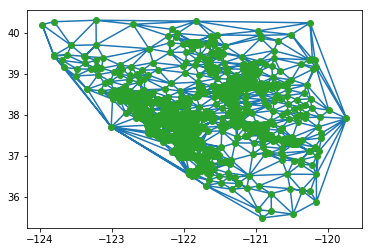

In [209]:
x = tri.points[:,0]
y = tri.points[:,1]
plt.triplot(x, y, tri.simplices)
plt.plot(x, y, 'o')
plt.show()

In [444]:
a = (1,2)
b = list(a)
b

[1, 2]

In [488]:
coordinates_list = []
gVertexSeq = g_giant.vs()
for v in gVertexSeq:
    coordinates_list.append(list(v["Coordinate"]))
coordinates_array = np.array(coordinates_list)

In [489]:
tri = Delaunay(coordinates_array)

In [490]:
tri.simplices

array([[ 693, 1881, 1857],
       [1883, 1807, 1424],
       [1206,  693, 1857],
       ...,
       [ 417, 1078,  668],
       [1078, 1371,  668],
       [1078,  498, 1371]], dtype=int32)

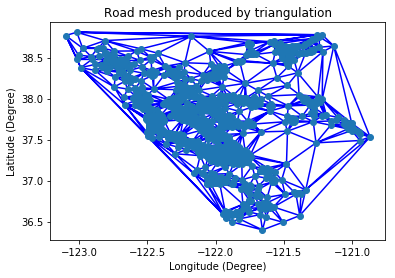

In [763]:
x = tri.points[:,0]
y = tri.points[:,1]
plt.triplot(x, y, tri.simplices, color = "b")
plt.title("Road mesh produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.plot(x, y, 'o')
plt.show()

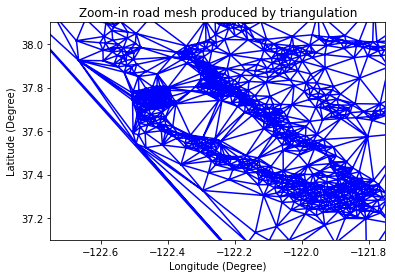

In [762]:
x = tri.points[:,0]
y = tri.points[:,1]
plt.triplot(x, y, tri.simplices, color = "b")
plt.title("Zoom-in road mesh produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
#plt.plot(x, y, 'o')
plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))
plt.show()

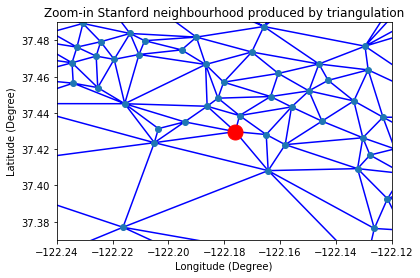

In [821]:
# (-122.1759822222222, 37.42968588888888)
x = tri.points[:,0]
y = tri.points[:,1]
plt.triplot(x, y, tri.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Zoom-in Stanford neighbourhood produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((37.43-0.06,37.43+0.06))
plt.xlim((-122.18-0.06,-122.18+0.06))

plt.plot(-122.1759822222222, 37.42968588888888, 'r.', ms = 30)
plt.show()

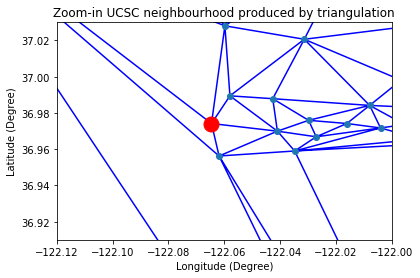

In [822]:
# (-122.06456181081083, 36.97416881081081)
x = tri.points[:,0]
y = tri.points[:,1]
plt.triplot(x, y, tri.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Zoom-in UCSC neighbourhood produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((36.97-0.06,36.97+0.06))
plt.xlim((-122.06-0.06,-122.06+0.06))

plt.plot(-122.06456181081083, 36.97416881081081, 'r.', ms = 30)
plt.show()

## Q12

In [259]:
from scipy.spatial import distance

In [247]:
igraph.EdgeSeq(g_giant)[1000].tuple

(136, 392)

In [250]:
igraph.EdgeSeq(g_giant)[1000].tuple[0]

int

In [265]:
igraph.EdgeSeq(g_giant)[1000]["mean_travel_time"]

1465.74

In [248]:
g_giant.vs[1]

igraph.Vertex(<igraph.Graph object at 0x11fc87228>, 1, {'name': '73', 'Display_Name': '2100 Fieldcrest Avenue, Fairfield', 'Coordinate': (-122.05216156249999, 38.292827187500016)})

In [264]:
g_giant.vs[1]["Coordinate"]

(-122.05216156249999, 38.292827187500016)

In [261]:
a = (1,2)
b = (3,4)
dist = distance.euclidean(a,b)
dist

2.8284271247461903

In [675]:
def calculate_flow(dist, time):
    speed = dist/time
    flow = 2/(0.003/speed + 1/1800)
    return flow    

In [676]:
# calculate the flow for each edge and add an attribute flow to each edge
g_giant_flow = g_giant
gcc_EdgeSeq = igraph.EdgeSeq(g_giant_flow)
i = 0
for es in gcc_EdgeSeq:
    vertex_id_1 = es.tuple[0]
    vertex_id_2 = es.tuple[1]
    coordinate_1 = g_giant.vs[vertex_id_1]["Coordinate"]
    coordinate_2 = g_giant.vs[vertex_id_2]["Coordinate"]
    dist = 69*distance.euclidean(coordinate_1, coordinate_2) # each degree of latitude and longitude is about 69 miles
    time = es["mean_travel_time"]/3600 # convert second to hour
    if dist == 0:
        continue
    flow = calculate_flow(dist, time)
    es["Flow"] = flow
    i = i+1
    
g_giant_flow.summary()

'IGRAPH UN-- 1898 555250 -- \n+ attr: Coordinate (v), Display_Name (v), name (v), Flow (e), mean_travel_time (e)'

In [271]:
igraph.EdgeSeq(g_giant)[2251].tuple

(1150, 1150)

In [677]:
gcc_EdgeSeq[10]["Flow"]

3265.7845351465344

In [300]:
16%2

0

In [302]:
# print the flow for all the edges
i = 1
for es in gcc_EdgeSeq:
    if es["Flow"] is not None:
        flow = es["Flow"]
    else:
        i = i+1
        continue
        
    if i % 12 == 0:
        print("{:.0f}\n".format(flow), end = "")
    else:
        print("{:.0f}\t".format(flow), end = "")
    i = i+1

3281	2706	3157	3043	3312	2969	3040	3327	2858	3243	3266	2494
3024	3042	3107	3030	3202	3229	2846	3160	2447	3031	3234	2765
3277	3163	2646	3169	3270	3262	2951	3069	3193	2951	2887	2920
3137	3179	3234	3074	3148	3147	2692	3210	3317	2950	3169	3296
2949	2913	3163	2717	3254	3302	2499	3172	2889	2744	3082	3231
3236	3005	2771	3066	2757	2806	3141	2980	3316	3238	3151	3183
3286	2816	3054	3294	3171	3242	2753	2671	3240	3081	2827	2554
2581	3299	3226	2922	3098	3131	3119	2497	2957	3256	3156	2822
2677	3272	2878	2674	2785	3309	3126	3031	3099	3137	3160	3018
2902	2969	3286	3159	3148	2941	2700	3165	3096	2827	2500	3276
2914	3117	2927	3206	3078	3169	3208	2791	3017	3186	3230	3301
2167	2892	2788	3184	3158	2521	2918	3140	2985	3196	3254	3223
2860	2600	2749	3148	2199	2617	2418	3189	3055	2924	2946	3195
3330	2886	3016	2754	3321	3127	3067	3052	3107	3107	3085	3034
2715	2754	2715	2757	2851	3112	2674	2699	2641	3088	2770	2658
3242	3024	3150	3406	3189	3101	3167	2990	3313	3075	2707	2621
2440	3263	2981	3060	2751	3100	3144	2898	

3064	3189	3236	2946	2605	3252	3231	3221	2311	3083	3125	2635
3192	3245	3260	3000	3232	3087	3184	3153	2969	2849	3147
3244	3066	3091	3077	3219	3095	3036	3151	2798	3101	2959	2826
3194	2917	3013	3054	2894	3131	2901	2659	3014	3079	3116	2584
3121	2995	2591	2414	2436	3277	3183	2806	3130	3018	3231	3005
3164	3123	2683	2983	3224	3111	2287	3201	3188	3268	2915	3220
2895	3196	3271	2636	3240	3018	2863	3070	3236	3153	3173	2371
2415	3229	2604	3139	2744	3093	3100	3138	3232	3099	3171	2800
2962	3182	2182	3283	2974	2857	3036	3328	3010	3283	2414	2533
2321	3043	2751	2949	2937	2952	3045	2714	3269	3005	3256	3037
3048	3045	3283	3209	2840	3173	3228	3089	3207	3246	2423	3101
3238	2805	3197	3158	3198	2990	3204	2542	3356	3317	2248	2638
2172	3167	3028	2394	3073	3179	3235	3262	3299	3292	2972	2952
3121	3105	3141	2706	3230	3258	2712	3296	3168	3059	2941	3044
3174	2882	2742	2938	3176	3055	3080	3240	2862	3204	2683	3084
2571	2481	2935	3293	2610	2583	3014	2982	2661	3193	3158	2686
2897	3120	3022	3177	3213	3164	3285	3070	3212	

2925	3035	3136	3278	3141	3264	2663	3023	2571	3155	2604	3081
3219	2606	3173	2625	3120	2263	2964	2582	2330	2725	2944	2978
3129	3126	3195	3184	2867	2976	3097	2919	3176	2659	2800	3112
2951	2642	3203	3071	2694	3153	2965	2840	3047	3197	3264	3269
3121	3270	2849	3116	3223	3049	3099	3164	3060	3148	3018	3076
2840	3176	3224	3197	3156	2763	3126	3155	3099	2576	2947	2765
3043	2967	2565	3102	2864	3067	3202	3028	3140	2179	2527	3005
3175	3015	3144	3125	3343	3304	2803	3231	2855	2375	3132	2630
3300	2958	3082	3260	2905	2624	3155	3249	2699	2524	3208	2541
3234	3040	3146	2894	3161	2578	2660	2790	3062	3237	2914	2814
3061	2620	3165	3065	3205	3259	3136	3114	3183	3085	2640	2615
2985	2821	3144	3320	3006	2948	2958	2937	2825	2705	3104	3161
2964	3117	3172	2929	3256	3249	2888	2925	3261	3263	3218	2395
2274	2672	3192	3230	3122	3312	3046	2583	3171	2942	3060	3251
3189	2989	2833	2896	3020	3217	3300	2449	3040	3252	3171	3097
3162	3186	3184	2776	2685	3079	3073	2411	2725	2555	2864	2736
3197	2908	3051	2768	3054	2779	3172	3309	

3015	2885	2856	2625	3283	3281	3060	2948	2637	3084	2732	2996
2913	3069	3251	2573	2832	3256	3141	3186	2669	2600	2739	3153
3220	2778	3003	2904	3255	3015	3248	3272	3183	2902	3216	3095
2750	3026	2714	2212	2856	2900	2761	3165	3171	2864	2533	3243
3180	2903	3174	3299	2990	2997	2871	2986	3114	2761	2992	3189
3081	2797	3231	3159	3080	2846	3049	2995	3241	2975	2555	3026
2313	3136	3303	3065	3282	2933	2148	3206	3136	3131	2789	3089
2770	3361	2999	3112	3135	3238	3039	3307	3301	3140	3274	3244
2860	3283	2327	3057	2762	2419	2928	1789	3047	3159	3046	3070
3166	3130	3199	3204	2432	3151	2963	3316	3185	3106	3049	3201
3152	3171	2786	3072	3097	3207	2727	2851	3092	2664	3218	2990
3163	3144	2850	2621	3291	2981	3016	3282	3251	2805	3150	3208
2887	3123	3219	2913	3132	2797	2473	2784	2984	2975	3240	2468
3226	3075	3232	2796	2487	2973	3024	3023	2728	3061	2606	3178
2196	3050	2757	3033	2685	3224	2854	3090	3199	2869	2502	3119
2615	2672	2991	2853	3004	3288	3084	2742	3114	2910	3059	3078
2864	2732	3136	3307	3104	2691	2661	3074	

3131	2684	3297	2773	3233	3094	2873	2383	3225	3251	2372	2947
2892	2497	2960	3181	3189	2901	3074	3024	2858	2423	3250	2573
2931	3176	3159	2625	2935	3239	3291	3020	3014	2960	3275	2831
3142	3296	2845	2933	3103	3145	2956	2923	3035	3239	2930
2506	3266	3165	3221	3070	3190	3082	3345	3280	3120	3270	3166
3095	2750	3087	2457	3246	3088	2898	3065	2613	2240	2888	2839
3149	3134	2678	3095	2832	2588	2867	2672	3082	3108	2939	2540
3085	2989	2977	3186	2826	2736	3076	2824	3162	2930	2532	3046
3019	3146	2900	3067	3249	2479	2505	2962	2568	3082	3068	3004
2450	3206	3242	3195	3165	3049	3127	2952	2850	2525	3220	3019
3195	2887	2856	2769	2757	2849	2998	3068	3284	3174	3281	3297
3089	2706	2920	2997	3106	3200	3083	2960	3072	3202	2795	2974
2645	2782	3213	2621	3223	3096	2816	2479	3285	2780	2856	2716
3043	3105	2750	3156	3090	3138	3250	3217	2908	2907	3087	3131
2713	2546	2647	3024	2956	2664	3231	3190	2472	3223	3329	3058
3045	3269	2837	3222	2427	3195	3257	3336	3264	2720	3254	3164
3072	2907	3150	3178	3229	2764	3244	2793	3009	

3138	3231	2862	2936	3026	3039	3059	3146	3155	3115	3083	2863
2824	2834	3215	3063	3177	2766	2835	2405	2946	3097	3184	2526
2902	3221	2556	3262	3026	3172	3106	3225	3127	2905	3159	2859
3330	3109	3079	2697	3131	3216	3199	3173	3254	3002	3077	2728
3131	3205	2812	3182	3037	2812	3154	3096	3110	3153	2710	3145
2964	3168	3115	2967	3148	3147	3216	3004	2972	2389	3002	2741
3199	2791	3166	2902	3198	3035	3215	2916	2997	2626	2952	2815
3120	3030	3056	2875	3099	3231	3156	2388	2951	2424	2719	3201
2946	3221	3142	3004	3130	2997	3111	3161	3238	2594	3183	3036
2732	3247	2938	3270	2801	3216	2736	2686	3168	2715	3098	3147
2943	2994	3123	3222	3051	3216	3140	3327	3115	3077	3161	3254
3208	3204	3205	3161	3285	2556	3403	2764	2867	3192	3106	3160
2941	2958	3022	2913	3179	2195	3208	2687	3283	3138	3074	3218
3274	3067	3224	2391	3034	2967	2654	2793	3176	3202	3310	3078
2516	2723	2841	2938	3087	3078	3029	3016	3285	3195	2913	3247
3265	2646	3095	3228	3321	3191	3188	3115	3027	2901	3077	3138
3203	2763	2942	2850	2606	3089	2814	3028	

2276	2780	3204	2983	3110	2660	2868	3059	3042	3052	3210	3199
3331	3150	3036	2497	2618	3268	2875	3216	3292	3033	3085	3198
3113	2997	3247	3019	3161	2862	3250	3169	2957	3265	3087	2555
3286	2588	3184	3089	3238	3170	3311	3112	2883	2320	2924	3093
2505	2785	3230	2569	3131	2958	3234	3162	2630	3210	3035	3218
2994	3186	2864	3077	3096	2972	3087	2325	3199	3235	2731	3155
2941	3080	2641	3228	2905	2732	3228	2755	2718	3233	3087	2874
3099	2485	2474	3097	3307	3291	2909	2947	2733	2777	2728	3060
2973	3041	2868	2968	3093	3233	2771	3032	3144	2879	2821	3272
3189	3129	3047	3176	3090	3146	3083	2529	3328	3101	3099	3224
2752	2818	2476	3054	2992	3027	3091	2996	2837	3166	3208	2926
3219	2735	2877	3264	3134	3171	3265	3259	2975	3213	2949	3271
3287	3018	3005	2984	3179	3155	3126	3029	3188	3257	2499	3044
2947	2900	2317	2917	2681	3099	2431	2882	2811	3285	2438	3303
2972	3321	2849	3176	3191	2833	3012	2562	3423	2502	3018	2989
3194	2784	3165	3052	3257	2562	2812	3207	2797	3223	3158	2480
2758	2382	2972	2937	2933	2583	3197	3239	

3121	2743	3240	2879	3129	2733	3085	3180	3009	2964	3114	3275
2458	3093	2781	3101	3277	3023	3109	2968	2708	2960	3101
2693	2952	3110	3234	3026	3227	2448	2979	2908	2450	2472	2889
2818	2988	3201	2887	3170	3145	3150	3158	3252	2997	2903	2946
2278	3071	2952	3082	2719	3190	3019	3126	2846	2947	3253	3072
3231	3007	3268	2246	2214	3221	3083	3213	2769	2840	2509	2970
2572	3019	2975	3148	3254	3056	2559	3110	2711	2908	2897	3108
2838	2206	2980	3018	2739	2669	3313	3150	3067	3150	2598	2201
3156	2988	3003	2948	3297	3281	2972	3049	2812	3111	3182	3205
3282	2724	3160	2705	3215	3333	3152	2635	2387	2784	2957	3216
3006	2941	3173	2915	3217	3031	3205	2784	3069	2875	3210	2871
3361	3163	3045	2650	3131	2829	3247	2878	3279	3031	2813	3060
3154	2933	3140	3055	3096	2835	3178	2910	3069	3187	3165	3308
2516	3047	2864	2749	3092	3260	3196	3090	3036	2789	2695	2981
2809	2792	2951	3254	2927	3104	3146	2612	3112	3238	2742	3121
2952	3029	2517	2779	3105	3050	3076	2607	2360	3315	3169	3245
3102	2989	3311	2712	3159	2940	3204	2949	3232	

2623	3005	3171	2780	2028	3296	3013	3076	3021	3210	2909	3119
3023	3068	3095	2223	3018	2786	3340	3215	3177	3100	3140	3201
2991	2884	3260	3181	3148	3127	3320	3248	3114	2173	2941	3182
2621	2802	3053	2992	2819	2398	2942	2724	3281	2802	2657	3267
2138	3277	3160	2867	3235	2948	3159	3163	3110	2344	3281	2682
2795	3089	2618	2924	3248	2799	2810	2863	2394	2670	3170	3041
2701	2781	3107	2455	3316	3165	2985	2986	2842	3149	3268	2138
3121	3093	3018	3165	2713	2629	3193	3222	2237	2989	3143
3123	3104	3106	3243	3308	3118	3151	2816	3200	2964	3338	3165
3056	3277	3131	2953	3116	3284	3118	2563	3211	3153	2893	2213
3052	2957	3103	3182	3226	3133	3257	2411	3150	3100	3107	3301
3228	2686	2930	3043	2970	3059	3164	2892	3199	2824	3057	3195
2886	2893	3341	2787	3272	3241	2902	3124	2553	3011	3080	2955
3251	2675	3173	3070	3123	3342	3258	3191	3094	3233	3128	3192
2852	2709	3183	3149	2069	3017	2909	2972	3161	3277	2924	3108
3025	3234	2558	2362	3150	3102	2719	2797	2968	2744	2963	3123
2562	3245	2963	2891	3133	3054	3156	3042	2220	

3065	2892	3268	3297	3037	3012	3236	3093	2973	3116	2990	3316
3168	3372	3051	3002	2858	3287	2987	3213	3263	3251	2815	2947
3076	3175	3017	3189	3266	3279	3044	2933	3218	2988	3251	2722
3191	2968	3307	3186	2479	3272	3288	2828	3166	3121	2961	2922
3069	3289	3021	3151	3099	3242	3288	3090	3273	3193	2966	3162
3021	3183	2981	3046	3151	2842	2101	3052	2955	2827	2972	2670
3157	3097	2708	3212	3100	3248	2908	3097	3134	2889	3192	2956
3046	3202	3115	2506	3032	3162	3167	3134	2990	3023	3225	2678
3311	2899	3170	2300	2947	2737	3050	3196	2862	3229	3049	3065
3153	3053	2514	2973	3099	3151	3068	2894	3087	2513	3014	2981
2861	3154	2983	2718	3291	3034	2688	3006	2955	3285	3128	3223
3161	3166	3013	2982	3027	2708	3241	2762	2592	3059	2858	3074
2879	2839	3107	2287	3220	3235	3142	3042	3171	3260	3281	3086
3268	3153	3129	3008	2778	2950	3237	3181	3160	3308	2707	3080
3263	2980	3048	3150	2636	3261	3274	2914	3280	3127	2658	2675
2955	2791	3263	3320	3110	3189	2783	2708	2969	3229	2633	2985
3204	2753	3154	3144	3244	2431	3065	3047	

2915	3073	2728	2755	2664	2778	3040	2818	3024	3149	3249	2599
3182	3191	3262	3203	2452	2907	3076	3202	3199	2975	3240	2860
3059	3087	3121	2891	2371	2576	2702	2993	3166	2784	3156	3138
2976	3071	3311	3205	3231	3192	3024	3213	3171	3100	3192	3263
3139	3168	2735	2983	3207	3212	3009	3120	2430	3176	3161	3435
3173	2823	2630	3130	3082	3105	2862	3280	3197	2845	3215	3292
3004	3234	3235	2297	3326	2992	2984	2757	3096	2995	3083	2953
3248	3218	2975	2977	2449	3155	2972	2833	3165	2806	2546	2745
2078	3040	3069	2605	3116	3182	3068	3133	3147	3154	2931	3089
2553	2466	2463	2958	2563	2952	2809	3033	3229	2764	2943	2817
3144	2719	2552	3221	2771	2809	3149	2624	3080	3083	2792	2925
3199	3206	3193	3345	3152	2597	2862	3101	2459	3265	3124	3199
3260	2978	3137	3063	3226	3331	2629	2891	3236	3185	3263	3210
2886	3234	3291	3176	2983	2945	3259	3093	2949	2718	3276	3198
3070	3291	2569	3106	3021	3270	2886	2980	3060	3014	3299	3109
3012	3204	3191	2805	3037	3047	2932	3233	3200	3172	3156	3060
3188	3195	2827	3063	3179	3186	3121	3085	

2902	3221	3224	3142	2529	3139	3027	2751	2738	3143	3189	2879
2890	3101	3128	3164	3321	2645	2813	2895	3177	3201	3225	2853
2686	2879	3272	2650	3236	3352	2770	2344	2668	2508	3279	2686
2842	3145	2793	2362	2732	2948	3199	3143	3036	3327	2900	2809
3013	2890	2909	2896	3074	2889	3208	2963	3004	3190	2781	3173
3128	2675	2761	3138	2946	2970	2901	3156	2907	3102	3154	2982
3063	3115	2792	2965	2898	3029	2346	3093	2660	3247	3028	3058
3152	3103	3208	2976	3233	3222	3128	2545	3203	3109	2535	3349
2861	2971	3021	3166	3106	2735	2439	2999	3313	3019	2144	3025
3171	3011	3158	3112	3236	3167	2767	3189	2502	2896	3329	2937
2809	2248	2706	2537	3099	2926	3107	2943	3227	2691	3053	3163
2513	3243	3175	3087	2755	3219	3240	3004	2491	2792	3233	3187
2937	3104	3196	3203	2916	2996	3222	3158	3265	2911	3156	3001
2637	2945	3278	2940	3173	2506	3100	2924	2555	3266	3084	2713
3205	3221	2863	3178	2966	3182	3069	3245	3103	2476	3115	2735
3167	3208	2796	3207	3136	2943	3153	2371	3082	3155	2156	2237
2777	3255	2471	3211	2708	3189	3193	3151	

3110	2861	3258	2907	2309	2949	3305	3121	2501	2581	3156	2976
3039	3211	3189	2847	2607	2617	2717	2861	3140	3127	2902	2187
2861	3089	2984	3156	3251	3010	2876	3058	3286	3191	3105	3053
3283	2774	3000	2971	3070	2864	2478	3151	3029	3105	3149	3289
3271	3200	3074	2643	2831	3165	2883	3122	3015	3108	3248	3294
2950	3181	2938	3118	2908	2863	2934	3091	2946	3205	3262	3122
2925	2292	2711	3086	2960	3184	3186	2954	3144	3143	2694	2447
2769	3116	3102	3014	3228	3170	2679	3081	2044	3350	3099	2931
3252	3113	3109	2900	2203	2517	3082	3257	2953	2077	3083	2769
3192	3267	3109	3225	3192	2810	3007	2963	2497	3023	2641	2721
2798	2847	2879	2999	3241	3142	2804	3217	3281	2897	2932	3108
3205	3297	3178	2953	3128	3256	2887	3258	3258	2602	2591	2695
2954	3244	2828	2850	2588	3050	2613	2913	3197	2421	2595	3206
3077	3149	3147	3192	2926	2891	2915	2902	3053	2370	2881	3236
3079	3267	2886	2973	2840	3198	3020	2860	3008	2932	3132	3208
3179	2948	3154	3236	2450	3011	2263	3247	3022	3227	3236	3175
3049	3022	3116	2977	3195	3354	3107	2578	

3270	2970	3242	3012	2941	2509	2876	2927	2715	3107	2949	2992
3097	2873	2875	3015	3106	2965	3176	2993	2998	2173	3134	3202
2742	2793	2904	3305	3211	2862	2886	3136	2294	3245	3179	2920
3209	2805	3010	3209	2596	2576	2818	2991	2809	3192	3280	2424
2999	3220	3170	3184	2635	3278	2312	3013	2650	2928	2948	3276
2448	2976	3112	2944	2503	3019	2962	3184	2859	3129	2572	3127
2590	3128	2905	2820	3151	3138	3098	3146	2897	3148	2780	3075
3221	3190	3325	3115	3188	2868	3138	3054	2772	2367	2855	3027
2929	3118	2457	2860	2928	3324	2677	2797	2637	3027	2424	3125
3016	2578	2307	3197	3122	3161	3035	2548	2610	2897	2871	3218
3101	2884	2933	3258	2497	3079	2881	3244	3247	3332	2811	2926
3141	2670	2633	2925	3323	3000	3144	2657	2983	2526	3141	3027
2898	3113	3184	2929	3174	2672	3150	2431	3163	2887	3013	3251
3018	3017	3305	2970	2918	3173	2887	3154	3106	2985	3244	3156
3089	2727	3122	3104	3209	3139	3090	2988	3223	3278	2951	3153
3104	3315	3101	2993	3081	3212	3164	3304	2974	2887	2805	3160
2967	2996	2901	3198	3297	3174	3093	3103	

3176	2889	3215	3264	2915	2991	3175	2733	3044	2923	2830	3178
3283	2677	3169	2661	2773	2804	2414	3193	3243	3247	3309	2530
3225	2685	2758	3107	3080	3256	2723	3224	2727	3112	3306	2836
3185	3235	3058	3171	3128	3228	3060	2976	2751	3011	3138	2615
3139	3158	2566	2955	2774	2702	2864	2588	3147	3293	2961	2765
3190	2968	2938	3006	2842	3009	3061	3013	2515	2893	3187	3149
3073	3270	2895	3210	3121	3143	3217	3205	2761	3029	3315	3132
3162	3108	3158	3029	3076	2569	3130	2593	3068	3264	3042	3251
3138	2757	3254	3161	2696	2521	3196	2934	3069	2991	2784	2932
3193	3054	2857	2961	3051	3277	2580	3147	3203	3188	3190	3246
3145	3156	3163	3025	2515	2921	3180	2984	3162	2457	3203	3262
2920	3269	2816	2638	3055	2829	3184	3026	2687	3214	2530	3169
2991	3184	2882	3225	3234	2747	3052	3149	3055	2579	3283	3140
3151	3278	2722	2859	2961	3151	3102	3122	2833	3250	2787
3158	3092	3179	3254	3318	3052	3205	2531	3224	3050	2253	3182
2845	3221	2591	3242	2905	3129	2927	3050	3009	3251	3131	3137
2751	2980	3153	3228	3365	3189	2398	3021	2893	

2872	3037	3215	2833	2973	3208	2645	3293	3129	3192	2973	3141
2314	3147	2908	3185	3222	3142	3227	3126	2401	2770	3001	2987
2991	3014	3152	3075	3125	2949	3115	3339	2778	2934	3001	3218
2405	3063	3186	3024	3245	2652	3302	3006	2492	2596	3070	2696
2519	3114	2924	3218	3258	3105	3060	3160	2550	3181	3319	2996
2203	2686	3299	3131	3040	3049	2621	2443	3037	2936	2894	2833
2966	2744	3175	2882	3048	2913	3178	3187	3077	3217	3123	2952
3167	3235	3138	2792	3006	3196	2793	3138	2968	2691	2691	2759
2578	3151	3022	2792	3188	3224	3343	3085	2942	3021	3146	2849
3151	2483	2477	3058	2788	3239	3269	2827	3356	2851	2923	2938
2722	3174	3279	2714	3175	2995	3255	3100	2616	3241	2998	2757
2903	3199	3348	2894	2902	2856	3218	2820	3058	2714	3042	3096
2958	3121	3279	3067	3083	3013	3110	3195	3280	3307	3271	3177
2751	3252	3147	3130	3205	3147	3215	2901	3224	2697	2952	3068
2948	2711	3008	2778	2651	3052	2241	2570	2912	2566	3016	3244
3137	2291	3199	3175	3008	3255	3203	2814	3021	3204	2902	2795
2790	3095	3114	2583	3120	2645	3060	3119	

3304	2481	2984	3235	2955	2992	3066	3287	2556	3206	2893	3024
3164	2946	2910	2779	3206	2882	3194	3253	3193	3036	3211	2844
3005	3044	2970	3187	3142	2600	2610	3148	3254	3210	2879	3158
3095	2887	3092	2576	3021	3045	3057	3189	3048	3116	2665	2416
3273	3129	3152	3162	2894	3254	3140	3103	3231	3210	3059	3259
3053	3202	2864	3217	3001	2708	3214	2820	3252	3276	2905	3117
3273	2793	3001	3122	2939	2989	3202	2847	3192	2973	2852	2466
2827	2798	2836	3264	3283	3190	3144	3030	3170	2671	2994	2949
3314	2863	2964	3318	3218	3084	2853	3118	2624	3378	3202	2906
2982	2865	3126	2258	3203	2584	2837	2945	2702	2900	2750	3206
3119	2867	2999	3042	3164	2759	3073	3012	2790	3003	3266	2861
3009	2330	3049	2916	3189	2975	3042	2956	2697	3133	3113	2815
3111	3268	3159	2859	3096	2620	3180	2793	3170	2847	2856	3084
2936	3170	3369	2914	3211	3042	2274	3126	3184	2589	2696	3204
3140	2888	3012	3109	2350	2789	3253	2326	3238	3064	3327	3185
3091	3172	2863	2972	3124	2325	3213	3136	3200	2500	2841	2881
3231	3159	2999	2783	2926	2785	3192	2735	

3017	2910	2695	3113	3164	2796	2978	3142	2960	3078	3047	2815
2841	2979	3031	3303	3098	3039	2926	3150	2971	2599	3002
3246	3270	2775	3264	2934	3228	3063	3317	3103	3149	3182	3211
3084	3188	3346	2972	2957	2970	3207	3122	2769	2995	3246	3322
2552	3174	3147	2952	3119	3278	3172	2808	2992	3175	2816	2887
2842	3147	2975	3187	3024	2991	3016	3321	3049	3120	3079	3120
3029	2631	3263	3301	3039	2833	3131	3273	2577	2732	2984	3223
3193	2960	2739	3282	3177	3026	3170	2753	2795	3134	3054	2984
3219	3143	3142	2928	3220	2320	3344	3219	3270	3152	2973	3210
3172	2575	3101	2395	2754	3275	2752	3070	2925	3192	3200	3288
3038	3199	2825	2911	2827	3202	3033	2380	3060	2940	2576	3020
2901	3142	3160	2889	2957	2634	3156	3234	3014	2852	2999	3065
3059	3193	2950	3197	3280	3012	2826	3107	3138	3151	2764	3301
3066	2768	2894	3210	2727	3203	2581	2972	3309	2889	2974	3215
3087	3214	3214	2876	3293	3422	3252	2179	3242	2802	2846	2936
3170	3011	2260	2939	3132	3050	2645	3332	3092	3120	2590
2974	2481	3236	3299	2605	2645	2978	3088	3307	2992	

2943	2872	3074	2979	3243	3121	3015	3357	2929	3293	3310	3343
3075	3261	3272	2959	3041	3096	2932	3220	3194	3106	3297	3098
2679	3202	2745	3133	2438	2348	3029	2974	3128	2810	2775	3244
2948	2985	3024	3038	3130	2715	3018	3093	3071	3114	3187	2751
2917	3370	3208	3258	3122	3055	3038	3099	3167	2545	3245	2896
3080	3143	3089	3281	3304	3158	3250	3180	2897	3038	3299	2953
2886	3185	3092	3185	2836	3084	2832	2941	2894	2869	3004	3030
3091	2146	3053	2690	3288	2662	3274	3110	3156	3124	3030	2935
2967	3224	3086	3235	3245	3084	2567	3102	3329	3215	2363	3177
3022	2574	2833	2774	2541	3171	3132	2845	2717	3209	3134	3261
3231	3248	2904	2866	3224	1912	3107	2848	2799	3041	3257	3028
3164	2950	2923	3176	3249	2602	2965	3107	2913	3296	2963	2795
2797	3004	3080	2910	2928	3158	3350	3233	2715	3172	2857	3181
2484	3286	3117	3223	2906	3174	2971	2991	3130	2893	3007	3095
2911	3261	3125	2911	3307	3040	3129	3301	2896	3303	3161	2532
3283	3060	3151	2957	3105	2972	3112	3007	3156	2253	3187	2986
3005	2494	3139	2469	3027	2902	2871	3010	

3135	2690	2715	2834	3126	3332	2418	2876	3170	2968	2545	3229
3257	3037	3095	3117	2860	3118	3217	2668	2501	2913	3010	2691
3168	2965	2968	3194	2636	3300	3242	3216	3070	2726	3129	3245
3224	3278	3078	3169	2399	3159	3226	3115	2779	3237	2968	2461
2988	2779	2699	3221	3123	3001	3102	2730	3155	3029	2987	2585
2836	2950	2956	3168	3126	3336	3074	2872	2873	3065	2727	3232
2892	3086	3168	2588	3191	2936	3112	3222	3174	2886	3068	2711
2889	3264	3149	3088	2479	3129	2869	2866	2840	2667	3246	3223
3160	3197	3067	2997	3018	2926	3062	3129	2818	3054	2873	2717
2849	3037	2883	2700	3273	3120	3159	3142	2834	3301	3130	2561
3123	2862	3236	2854	3133	3317	3085	3214	3262	3239	2644	3141
2980	3129	3100	3284	2664	2944	2859	3068	2840	3108	3074	2806
2968	2955	2924	3101	2739	2947	3066	2755	3152	2798	2956	2934
2808	3224	3059	3172	3162	3083	3247	3007	2747	3289	2975	3171
2928	2843	3195	3310	3204	3233	3141	3139	3097	3123	3020	2409
3149	3060	3054	2694	3079	2723	3188	3194	3054	2375	2681	3330
2954	2982	2858	3223	2586	3221	3107	2998	

3270	2847	2938	2491	2755	2322	3348	3187	2926	3243	2687	3266
3059	3167	3118	3005	3194	3066	3309	3131	2921	3026	3190	2955
2563	2905	3042	3193	3302	3120	2874	3224	3264	3271	3142	2951
2994	3099	2705	3008	3332	2915	2870	2992	2943	3125	3143	3286
3290	3031	3241	3126	2946	2627	3166	3190	3280	3036	3107	2614
3225	2980	3019	2952	3301	3153	2984	3032	3236	3090	2257	3126
2732	3165	3226	2814	3088	3075	3165	3436	3132	3158	3220	2981
2477	3178	3206	3128	2618	3147	2801	2933	3275	3168	3202	3114
3117	2943	2786	2919	2997	3168	3262	2800	2464	3337	2994	2542
2975	2560	3173	3345	3281	2999	2468	2974	2527	3245	2989
3224	3306	3338	2941	2809	3021	2937	2946	3206	3277	3147	2896
2877	2847	3057	3111	3185	2993	2678	3124	2895	3187	2396	3188
2992	2994	3268	3197	2757	3033	3188	3282	2711	2819	3087	3230
2940	3158	2280	2932	2656	3128	2877	2380	3027	3198	3184	3285
2855	3033	3196	2881	3076	3146	3161	3006	2599	2676	3044	3334
2945	3318	2866	2890	2972	3248	2891	3151	3128	3072	3135	3161
3170	2552	3020	2973	3066	3080	3150	3234	3110	

3122	3270	3156	2996	3077	3281	3125	3052	2931	3127	2788	2948
3197	3214	3027	2336	3064	3218	2669	3246	2935	2919	3163	3112
2979	3016	3052	3180	2239	3152	3086	3269	3277	3202	3067	2807
3202	3332	2473	3011	3249	3125	2771	2994	3073	3213	2792	3258
3183	3303	3071	3044	2813	2891	2849	3240	2935	3072	3016	2770
3060	3240	3170	2897	3196	3155	3049	3105	3200	3260	3029	2666
2559	3058	3025	2911	2918	3015	2973	3300	2518	3217	3120	2802
3036	3246	3202	2969	3191	3078	3174	2984	3151	2958	3236	3072
3101	3135	3235	3134	3233	3097	3214	2552	3210	2393	2941	2971
3109	3201	2736	3190	2962	3161	2843	3146	2904	2877	3131	3117
2550	2901	3104	3200	2818	3021	2897	2967	2760	3187	2948	2910
3247	3231	2709	2866	3070	3309	3043	3136	2773	2839	3086	3071
3252	3044	3100	2474	3109	2372	2417	3188	2511	3250	3074	2825
3006	3205	3260	3184	3006	3232	3142	3205	3060	3076	3063	2907
3212	3250	3287	3224	3202	3085	3202	3232	2529	2999	3144	3114
3016	3049	2951	3180	2636	3093	3171	3106	3139	3037	3003	2730
3100	2169	3211	3143	3121	2938	3145	2863	

3180	3099	3128	3213	2584	3098	3097	3272	2814	3282	3158	3045
3298	3158	3171	3226	3194	3156	3181	3100	2418	2847	3122	3098
3169	2905	2896	2851	3131	2568	2829	3037	2949	2856	3184	3140
3244	3106	3025	3118	3273	3239	2944	3066	2851	3250	3192	2957
3158	2952	3037	2630	3078	3318	2295	3058	3207	2940	2944	3086
2720	3295	2701	3097	3164	3113	2679	3080	2767	3090	2378	2683
3054	3211	2903	2997	2726	3071	3182	2723	2499	2984	3144	3239
2218	2999	2805	3203	3316	2889	2241	3099	2937	2929	3350	2775
3296	3091	2934	3214	3218	2771	3076	2189	2809	2846	2743	3129
3245	3108	2799	2996	3245	3322	2614	2306	2925	3248	3212	3115
2484	2680	3226	2864	3099	3328	3152	2567	2854	2994	2194	2999
3198	3037	2699	3215	3246	3202	3162	3152	2606	3142	2972	2720
3196	3126	3165	2209	2864	3071	2802	3163	2273	3109	2954	3048
2825	3131	2289	2691	2766	2906	2951	3064	2783	3312	3215	3083
3127	3269	2564	2963	2916	2939	3234	3172	2693	3329	3086	3102
3317	2999	2650	3232	2567	2465	3071	2643	2982	2456	2927	3162
3177	2887	3302	3185	2942	2673	2120	3296	

3240	2990	3263	2642	3006	2909	2515	3112	3240	3241	3308	3233
2966	3085	2882	3247	3186	3092	2239	3169	3259	3245	2766	3285
2988	2982	3146	3244	2696	2508	3062	3133	3204	2789	3216	2892
3186	2658	3207	3222	3331	2748	2990	2867	3176	3216	3243	3248
3247	3304	3141	3104	3193	3308	2764	2467	3052	3007	2939	3247
2093	3078	3148	3203	2821	3048	2836	3188	2940	3334	2908	2770
3120	3195	3084	3170	3278	3149	3187	2777	3069	2961	3125	2910
2751	2408	3076	3044	3356	2869	3253	2988	2738	3202	3098	3210
2663	2758	2768	3050	2731	3131	2582	3080	2940	3019	3156	2762
3041	3123	3051	2734	2742	3213	2892	3192	2315	3264	3033	2927
2542	2819	3322	2156	3185	2726	2884	3186	3195	2695	3083	3120
2968	3122	2574	2983	2854	2950	2724	3044	3107	2892	2467	3133
2804	3173	3061	3240	2647	3213	3090	3236	2855	3218	3133	3056
3186	2822	3126	3314	2534	2671	2329	3228	2957	2948	2867	3248
2693	2839	3029	3261	2644	3077	3078	2596	3130	2911	3106	2694
2839	3181	2780	2415	2938	2945	3042	2453	3240	3118	2781	3272
3290	3174	2860	3232	3171	2871	2981	3113	

3276	3159	3143	2771	3191	3195	2938	3283	3276	3076	3143	3148
3133	3212	3117	3146	3019	3148	2822	3050	3112	3001	3254	3256
3321	3078	2859	2992	3274	2749	3139	3150	3256	3012	2883	2765
3282	3162	2366	3223	3186	2842	2747	2605	2842	3175	3336	2696
3103	2984	3144	3268	3195	3070	3068	3219	3348	3008	3155	3265
3239	2976	2771	3181	3113	2829	3123	3277	3186	2375	3336	3099
2740	3256	3091	3121	2825	2643	3293	3076	2833	2771	2729	2801
3109	3098	2873	3069	2481	2885	3295	2999	2827	2968	2937	3171
3245	3031	3151	3247	3271	3188	2958	3136	2501	3249	2649	3173
2770	3232	3061	3248	3126	2849	2992	2851	2653	3323	3260	3081
3296	3025	3295	3106	3100	2992	2564	2561	2847	3110	2761	2850
3260	2867	3100	3137	3202	2631	3264	3276	2663	3166	3089	3251
3295	3198	3325	3202	2784	2670	3030	3273	3237	3093	3105	3269
2512	2690	3224	2786	2923	3324	3021	2984	2389	2734	3086	2845
2951	3182	2885	3057	3222	3180	2944	2221	3284	2234	2474	3170
3002	3217	2749	2887	3292	2842	3266	3088	3141	3151	2468	2510
2993	2486	3005	3127	3315	2515	3120	2881	

3102	2419	3092	3257	2828	2832	3067	2700	3294	2906	3051	3126
3151	2479	3273	3201	3221	2677	2372	2682	3169	3076	2708	3066
2691	3188	3024	2956	2856	2914	2690	3175	3113	2977	2878	2720
2976	3217	3072	3156	3236	3231	3320	3206	3005	2994	3102	2929
2939	3045	3186	2733	2550	3131	3265	3081	2980	2945	3102	3162
3124	3190	3176	3190	3299	2518	3155	3097	2392	2798	1988	3250
2443	2107	2707	2168	3211	3221	2636	3326	2661	2397	3259
2454	3208	3227	3174	3136	3072	2251	3218	2549	3227	3047	2735
2473	3210	2667	3265	3168	3163	3262	3119	3101	2808	3024	2925
2966	2830	2926	3217	2907	3231	2417	3166	2597	3219	3271	2930
3221	3197	3050	2799	3300	2832	3026	3047	2967	3004	3195	3207
2999	3310	3094	2990	2942	3090	3166	3039	2745	3159	3183	2820
3053	3079	3123	3209	2932	3065	2947	3092	2532	3078	2980	2310
3119	1995	2684	3243	3109	2843	2650	2340	2991	2865	3252	2795
3104	2933	3047	2515	2893	3005	2812	2976	3121	3024	2701	2940
3109	3119	2944	3266	2805	3144	2845	3148	2903	3374	3096	3293
3227	3092	2602	2891	2972	3057	2967	3072	3007	

2876	2966	2497	2877	3293	3268	2961	3096	3337	2965	3002	2984
2792	3210	3008	2958	3347	3090	2944	2921	3029	3076	3232	3272
2735	3228	3119	3114	2793	3036	3132	2969	3195	3196	3050	3085
3009	3125	2919	3180	2787	3023	3277	3167	3239	3007	2258	3145
3125	3073	3187	2944	3190	3128	3188	2944	3019	3124	3066	3026
2906	3171	3157	3276	2471	2863	2887	3030	2681	3070	3264	3197
3186	3183	3119	3185	3115	3286	2887	2572	3020	3179	2695	3160
3203	3177	2810	2987	3177	3001	2790	3344	3186	3042	3036	2720
2937	2916	3037	2771	2712	3296	3156	3099	3003	2391	2915	3079
3174	2937	2792	3282	2694	3191	3293	3081	3254	3175	2824	3374
3190	3400	3042	2961	3104	3116	2572	3081	3099	3211	2931	3153
3121	3205	3006	2999	3221	3146	3210	3224	3008	3118	3222	3194
2699	3013	3009	2738	2988	2881	3212	3153	2746	3100	3264	2618
3339	3186	3000	2609	3247	3077	3112	2684	2833	2994	3181	3044
3035	2982	3206	3126	3030	3012	2867	2660	2898	3284	3095	3099
2548	3188	3024	3069	3316	2623	2951	2944	2967	2853	3189	2908
3036	2986	2603	3081	3060	3007	3147	3223	

3279	3202	3209	3236	2603	3047	3205	2550	3264	2729	2227	3234
2938	3071	2946	2802	2758	2967	3339	3036	3107	2316	3212	3001
3288	2520	3086	2983	3196	3168	2465	2830	2443	2464	3013	2826
2266	2807	2972	3314	2680	2787	3101	2937	3236	3016	2857	3067
3169	2883	3007	3023	3065	3124	2833	2904	2813	2891	2864	3089
3143	3016	2598	2545	3043	3192	2570	3107	3139	3151	2230	2793
2822	2921	3116	3021	2973	3059	3257	2048	3035	3160	3213	2584
3135	3100	2906	3214	3161	2520	2749	3155	2822	3164	3120	2869
3219	2743	2978	2693	3077	3027	3174	3060	3077	3255	2932	3174
2843	2869	2804	3001	3082	2821	2931	3095	3010	3033	2932	2971
3006	3204	3156	2954	3128	2854	3077	2973	3068	3287	3129
2683	2875	3172	2959	3019	3106	3311	3098	3013	3301	3054	3079
2853	2770	3083	3282	2598	2831	2922	3037	3171	3013	3043	3174
2822	3013	3246	3025	3286	2247	3225	2766	3065	3206	3126	2815
3075	2957	3209	3097	3019	3083	2688	2814	3103	3198	3044	3237
2932	2643	3222	2794	2115	3122	3178	3133	3149	2893	3219	3176
2464	2525	2825	3117	3275	3140	3070	2578	2745	

3248	3271	3186	3197	3197	3089	2316	2859	3214	2764	2741	3164
2616	3254	2581	3131	2897	2999	2972	2956	3222	2812	2964	2821
3048	2990	2533	3081	3082	3290	2607	3070	3202	2843	2865	2907
3232	2875	3261	3249	3167	3234	3144	3389	2728	3113	2484	3221
2790	3216	3081	2565	2995	3271	2599	2651	3061	2711	3209	2733
3266	2737	3249	3315	3208	2949	3011	3166	2691	3191	3254	2791
2682	2887	2839	3040	2761	3190	3165	2566	2710	2728	3247	3261
3249	2989	3266	3026	3021	2554	2794	2491	3124	2716	3201	3175
3155	3141	3014	3203	3206	3142	3297	3273	3250	2742	2786	2458
2464	3305	3284	2731	3028	3142	2961	3259	3090	3250	3171	3174
3006	3202	3293	2486	2589	3060	2316	2817	3319	2902	3207	3076
3094	3212	3065	3110	3214	2928	2934	3053	2709	2838	2813	3188
3257	3381	3064	3213	2921	3356	3329	2978	2896	2681	3279	3089
3100	2390	3267	2914	2332	2957	2823	3142	2459	3197	3083	3077
3101	3281	3023	3152	3238	2834	2902	2927	3078	3202	3145	2931
3160	3254	3258	2915	2454	2346	3212	3042	2387	3117	3222	2968
2897	2753	3227	2744	3095	2992	3062	2699	

2981	2281	2996	3148	2861	2764	3015	2846	3258	2296	3079	3115
3049	3136	2320	3183	3133	3150	3210	3015	3163	2987	2548	3289
3071	3052	3180	2939	3053	3252	3210	3347	3110	2662	3174	2897
2846	3199	2529	2560	3132	3142	3043	3100	3159	3185	3184	3118
2657	2964	2999	3071	2567	2941	3321	2530	3106	2969	2508	2958
3233	3036	3150	3101	3283	2737	2571	3244	3199	3065	3291	2578
2709	2802	3219	3004	3192	2512	2903	2743	2378	2971	3111	3016
3165	3087	3249	3251	3074	2732	3000	3011	2916	3290	3258	3215
2869	3194	3146	2655	3265	2876	3061	3191	3184	3307	2558	2845
3280	2915	2501	2980	2608	3246	3250	3165	2722	3049	3251	2544
2752	3126	3242	3138	2844	3246	2950	3023	2928	3266	3058	3145
2657	3275	2643	3323	2931	3153	3086	3269	3101	2282	2953	3286
3166	2773	2039	3256	3181	2863	2602	2613	2397	2690	3217	3282
3094	2559	3218	3249	3056	2908	3113	2972	3075	2436	2978	3002
2366	3047	3145	3085	3121	2905	3141	3264	2205	2502	2966	2945
3251	3056	3073	2608	2647	3169	2284	2887	2715	3082	3264	3100
2946	3073	2803	3135	3057	3314	3222	2724	

3198	3180	3243	3222	2981	3287	2919	3154	3228	3001	3254	3061
2949	2617	3024	3015	3055	2728	2869	2743	2769	3173	3034	3170
2733	2423	2980	2975	3195	2961	3344	2964	2740	3241	3136	2889
3000	3253	2636	3198	2469	2960	3136	3246	3004	3141	3095	2627
3078	3233	3014	3203	2749	2686	3108	3004	2827	3288	2982	3189
3245	2832	3254	2890	2507	2887	2991	2563	2788	3034	3069	3166
2435	3179	3014	3099	2768	3166	3227	2961	3116	2944	3249	3187
3206	3134	3264	3039	3018	3121	2884	2886	3225	3079	3080	3169
3166	2983	2997	3162	2949	3107	3222	3135	3038	3082	2848	3061
2917	3225	2799	3067	2651	3012	2986	3234	3018	2773	3187	3195
3202	2888	3129	2972	3076	2765	3222	3233	2798	3138	3206
3121	2927	3100	3227	2846	2573	3004	2332	3246	2205	3180	3306
3052	2570	3190	2916	2924	3078	2742	2669	2794	3138	3041	2693
2468	2888	3137	3217	2917	3161	2723	2834	3082	3097	3069	2958
3177	2886	3079	2689	2796	3184	3167	3097	2660	2992	2736	2940
3227	2993	3019	2765	2847	2164	2782	3150	2395	2837	2349	2466
2903	3260	3221	2979	3070	3277	2744	2555	2688	

3263	2284	3143	2756	2984	3160	2902	2872	3049	3236	3281	2938
3386	2444	2594	3221	3356	2920	2633	3227	2570	2191	3232	3133
2789	3187	2457	3144	2643	3167	2989	3000	2690	2629	2410	3232
3110	3182	3062	3280	3154	2910	3258	3164	2333	3253	3222	2865
2915	3157	3257	2865	3212	2635	3212	3188	2740	3059	2441	2937
2863	3175	2555	2892	2772	3080	3107	3169	3235	3332	2995	3184
2979	3042	2050	3062	2810	2663	1999	3015	3000	2719	2799	2704
2612	2909	2926	3217	3269	3137	3206	2523	2434	2789	3003	3103
2633	2473	2997	3157	3144	3004	2840	3026	3222	2722	2878	2905
3305	3202	3192	3126	3253	2818	2427	3203	2899	3254	2632	2880
2628	2946	3122	3176	2718	3142	2162	3001	3143	3133	3152	2747
2900	3115	2988	2397	3169	3211	2601	3254	2406	2897	2686	3165
3070	3058	3129	2858	3248	3068	3280	2534	3093	2530	3164	2762
3225	3087	3211	3074	3255	2780	3233	3000	2968	3152	3200	2844
2986	2801	3188	3057	3219	3044	3145	3193	3000	2470	2727	2948
3101	2940	2963	3040	3287	2774	3179	2248	3291	3298	2966	2535
3080	3059	2987	2952	3063	3239	3278	3238	

2702	2949	3212	2720	3296	3026	2885	2435	2523	2855	3337	2830
3080	3034	2895	3101	2840	3110	3260	3279	3164	2832	3000	3081
3167	3178	3257	2897	2510	3285	3246	3258	2548	3116	3040	3214
2638	3220	2982	3088	2632	3131	3077	2907	2772	3162	3184	2364
3013	2995	2659	3277	3259	3232	3208	2966	3177	3212	2923	3142
3185	3109	3126	2953	2630	3186	2867	2992	3277	2867	3114	3045
3109	3268	2894	3120	3172	3107	3039	3153	3181	3168	2839	2745
2905	3303	2692	3099	3224	2881	2855	3098	3009	2951	3246
3218	3260	3147	3085	3129	2569	3019	1930	2842	2240	3314	3176
3189	2790	3135	3109	2940	3230	2179	2864	3170	2887	2475	2746
3163	3042	3108	3081	2379	2221	2706	3268	2878	2930	3395	2273
2868	3024	3055	3042	3244	2860	2979	2928	3032	3198	3212	3083
3261	3171	2918	3089	3076	3038	3256	3244	2895	2858	3477	2813
2759	2815	2597	2678	2511	3169	3003	3008	3199	3166	3058	3069
3205	3026	3015	3016	3122	3210	3045	3098	3148	3021	2970	2692
2954	3001	2524	3113	2800	3120	2785	3147	2867	3227	3271	3202
2997	3220	3333	2806	3192	3089	3067	3204	3143	

3193	3105	3227	3177	3106	3004	2911	3171	2906	3257	2406	2823
2825	2231	2572	2956	3003	3207	2302	3159	3288	2144	3252	2696
3231	2337	2796	2814	3090	3090	2982	3169	2650	2996	3212	2621
3190	2742	2590	3152	2557	3229	3124	3240	3001	3277	2825	3147
3291	3086	2835	3076	2797	3151	3057	3173	2951	2846	2946	2956
2375	2918	3304	3210	2923	3030	3020	2888	3276	3095	3174	2770
3111	3017	3157	3203	3072	3111	3263	2408	2981	3056	3182	3169
3176	2553	2659	3266	3201	3038	3183	3122	2568	2982	2921	3203
3155	2936	2521	3116	3320	3174	3071	3161	3175	3066	2957	3180
2661	3122	3129	2968	3108	3248	2792	3093	3194	3080	3210	3080
3243	2942	3182	2973	3194	2472	3191	3222	2672	2980	3055	2513
3072	2463	3075	2827	3133	2779	2446	2747	3222	3078	2917	2369
3061	3257	3120	3211	3055	2941	3254	3194	3169	3001	2831	2909
3075	2994	3220	2878	3216	2964	2358	3067	2884	2975	2895	3185
3206	3226	2734	3239	2945	3133	3290	2662	2991	2996	2918	3195
3248	3115	2892	3135	3215	3241	3235	3135	2515	2977	2353	2980
3110	2865	2868	3276	2729	3323	3187	3103	

3131	3226	3038	2823	3253	3262	2409	3252	3183	2793	2994	2549
3009	3229	2827	3181	3255	3186	3370	2816	3053	3141	3216	3117
3094	3029	2863	3130	3131	3149	3323	3186	3149	3096	3295	2994
2298	2751	3155	3119	3172	2875	3286	3164	2604	3179	2890	2611
2638	3258	2983	3031	3124	2772	3194	3009	3176	2878	3222	3253
2949	3023	3195	3258	2538	2935	2799	3148	2815	3252	2825	3224
3030	2648	3308	3192	3089	3106	3127	2937	3037	3137	2878	2878
3004	3213	2747	3265	2831	2764	3178	3067	3255	2425	3034	2792
3038	2460	2223	3234	3186	3114	2616	3086	3249	3149	2875	2269
3150	3257	3287	2867	3256	3094	2782	3213	3092	3048	3160	2956
2900	2989	2863	2612	3339	3296	3134	3115	2831	3252	3048
2974	3196	2726	3019	3082	3247	3069	3254	3284	3087	2939	3146
3259	2700	3048	3122	2957	3180	3234	3006	3154	2571	3163	2948
3079	3128	2892	2905	2657	3085	3246	3124	2828	3040	3150	2768
3218	3307	3221	3132	2840	2928	2949	2953	2967	3243	2710	2860
3111	3111	3262	3174	3233	2827	3227	2842	3296	3129	2914	3270
3093	3154	2726	3117	2434	2993	3147	3060	3164	

2912	3074	3251	3027	3097	3213	2880	3119	2762	3179	2897	3115
3080	3076	3128	3214	3282	3174	2403	2804	3313	3096	2765	3022
2954	2970	2765	2826	3012	3124	3028	2783	3117	3223	2495	3043
3141	2479	3192	2724	2905	3154	2661	3069	2847	3236	2907	3007
3219	3287	3182	3179	2681	3074	3179	3048	3238	2948	3109	2683
3064	3121	2724	2649	3062	3155	2719	2906	3076	3262	2757	3080
2865	3165	3241	3331	2906	3131	3276	3227	3250	3061	3032	3287
3215	3183	3026	2947	3135	3086	3293	2826	3026	3114	3151	3155
3171	2519	3073	3227	3073	3440	2900	3150	3126	3002	2850	2999
3225	2982	3251	2906	3000	3143	3199	2753	2956	3101	2930	3178
3014	3235	2829	2801	2408	2502	2689	3135	3123	2920	3219	2941
2986	2925	2936	3173	3178	3151	3010	3266	3158	3072	3266	3086
3263	2553	3143	3204	3327	3095	2841	3166	3257	3123	3117	3042
3159	2972	2814	3171	2823	3002	3130	3118	2900	3000	2870	3030
2585	2928	3053	2981	3114	3304	3273	3263	3045	2598	2931	3237
2624	3151	3041	2485	2926	3163	3054	3285	3007	2555	3269	2669
2666	3217	3238	2589	2824	3034	3026	3213	

3032	3123	2409	2482	3158	3244	3252	3016	2622	2775	2825	3202
2974	3087	3171	2962	2953	3226	2979	3248	3107	3075	3122	3177
2995	3110	2899	2742	3203	3214	3250	2968	3378	3213	2964	3321
2935	2905	3244	3094	2383	3206	3258	2597	2782	3068	3121	3250
3007	3065	2507	3059	3133	3160	3223	3093	3007	3028	2142	3213
3146	3290	3019	2794	3096	2621	3278	2491	3180	3184	3116	3140
2854	3295	3026	3147	3030	3129	2509	2931	3217	2953	2257	2898
3306	3212	2801	2734	2859	2858	3279	2938	3130	3102	2915	3015
2645	3185	3089	2950	2951	3049	3298	2939	2809	3232	2849	2970
3128	2978	3215	3038	2686	3095	3351	3104	3180	3078	3189
2815	3301	2912	3134	3148	3143	2909	3032	3184	2865	2887	3168
3061	3062	3022	3161	2750	2940	3210	3282	3220	3093	3250	3152
3278	2854	3178	2929	3156	3049	2707	2653	3197	3117	3198	3034
3123	2954	3272	3204	2977	3018	3098	2557	3087	3141	2290	3023
3009	2591	3173	3052	2962	3222	3185	3212	3249	2851	2885	3133
3208	3211	3035	3027	2782	3222	2220	3170	2331	3119	3034	2704
2975	2686	2506	3300	2875	3268	3197	2874	3026	

3323	2904	2966	3231	3209	2669	3130	3154	3076	2923	2644	3097
2891	2986	3113	3197	3278	3122	2918	3059	3094	2882	2907	3043
3147	2780	2349	2563	3105	3001	3052	3061	3175	3023	3179	3325
2902	3014	3123	3003	3272	3243	3092	3022	2713	3008	3154	3076
3185	2878	2800	3125	2985	2855	2998	2659	3103	3195	3040	3279
2323	2773	3208	3173	3153	3296	3257	2984	3024	3011	2765	3117
3160	2796	3160	2926	3030	2802	2820	3127	2823	2998	2177	3126
3057	2965	3201	2199	3274	2975	3063	2852	3288	2710	3206	3198
3209	3066	2996	3146	2440	2982	2704	3113	3176	3055	3203	3089
2878	3205	3153	2949	3038	3338	3383	3281	3205	2726	3266	3111
3291	3248	3123	2325	3235	2765	3057	2592	3221	3280	3225	3111
3180	2805	2198	2819	2926	3171	3305	3157	3078	3223	3021	2983
2265	2775	3202	3183	2737	2512	3137	3324	2924	2642	3082	3087
3110	3253	2753	3144	3131	3193	3201	2484	2846	2825	2707	2228
3130	2871	2561	2908	3067	3339	2756	3066	2943	2544	2976	3254
3241	3041	3254	2731	3245	3220	3289	3246	2809	3124	3216	3310
3222	3155	2979	3248	3005	3037	3012	2517	

3117	3162	2730	3209	2611	3236	3140	2986	3050	3156	3067	3227
3165	3177	2978	3238	3178	3081	3200	2611	2521	3103	2470	3121
3331	3221	3146	3043	3312	3277	3321	2911	3082	2967	2251	3072
3295	3220	3044	3268	3276	2830	3126	2914	3259	2998	2981	2886
2714	3242	2946	3191	2854	3160	2885	2758	2618	3274	3053	3198
3211	3254	2879	2892	2734	2963	3029	2864	2790	3035	3160	3084
2314	3212	3076	2866	2479	2855	2214	3129	3099	3121	3267	3142
3252	3257	2820	3298	2817	2785	3153	2958	2835	2534	2286	3164
3161	3108	2940	2983	2954	3189	3264	3039	3125	3084	3122	3102
3215	3162	3229	2907	2992	3143	3225	2885	2575	3103	3057	2998
3006	3112	3045	3167	2248	3224	3074	2281	3024	3245	3155	3235
2537	3247	2649	2661	3149	3074	3154	2538	3053	2427	3219	2450
2364	2861	2402	3204	2591	3035	3276	2995	2808	3216	3041	3081
2661	2894	3071	3068	2949	3071	3202	2943	2999	3035	3263	3096
3112	2674	3209	2776	3278	2981	3167	3071	3182	3209	2304	2784
3289	3341	3173	3239	3303	2926	3198	2817	2444	3058	2992
3228	3295	3078	2543	2702	3178	3151	2698	3211	

3237	3095	2955	3308	3195	3076	3067	2719	2857	2694	2995	2534
3041	3129	3179	3108	3217	2954	3093	3098	2857	3207	3023	3130
2948	2721	2828	3105	3113	2978	3120	3186	2867	3301	2863	2756
2557	3145	3089	2880	3255	2275	3173	3246	3164	2746	2909	3034
2752	3087	3099	2690	2686	2375	3070	3092	3084	2431	2553	3061
3118	3147	3133	2211	2577	3167	3167	2920	2899	2968	3004	2866
2906	3062	2869	3059	3156	3252	3290	3014	2787	2959	3337	3169
2163	3382	3098	2745	3227	3123	2564	2521	3009	3111	3263	2977
2958	2830	2701	2980	3179	3098	3263	2806	2878	3263	3038	2946
3173	3181	2518	3280	2900	3378	3041	2822	2840	2417	2396	3069
3140	3271	2945	2918	2775	2601	3084	3242	3003	3174	3371	3153
3026	2913	3126	2905	3171	3110	3052	2968	2883	3057	3037	3162
3257	3149	2974	3232	3071	2961	2929	3180	3241	3281	3047	2699
3115	3255	3198	2407	3038	2582	2775	3266	2927	3084	3300	3152
2825	3014	2632	2448	2816	3210	3151	3017	3061	3080	2820	3261
2924	2990	2984	3000	3286	3162	3090	3198	3061	2793	2928	3117
3113	3161	3140	2360	2854	2660	3300	2859	

2650	3237	3196	2902	2856	2851	2912	2758	2434	3202	2780	2589
3219	3148	3183	2876	3008	2768	3202	3050	3166	3089	3109	3131
2808	3054	3177	3200	2956	3210	3077	3195	3140	2722	3183	3110
3067	2930	3280	2776	2881	3004	2997	3258	2690	3170	3232	3088
2913	2941	2880	3101	3135	3227	3166	3017	2972	3100	3326	2729
3024	3287	2967	3260	3123	2552	3055	3040	2781	3188	3255	2838
2852	3074	3068	3113	3230	2822	3228	3077	3172	3075	2993	2950
3287	3127	3237	2972	2725	3066	2415	2971	3135	2759	2980	3119
3215	3162	3080	2891	3232	2485	2946	3135	3004	3119	3055	2829
3118	2776	3049	3113	2759	3305	3123	3204	3189	3028	3183	3087
3176	2839	3205	2630	3191	3063	2999	2869	3190	3223	3210	2570
3030	2745	3311	2971	2870	3156	2905	3209	2717	3016	3001	3080
3119	2858	3292	2981	2739	3173	3136	3133	2593	2851	2778	3191
3195	2752	2432	3031	3080	3091	2769	2850	2755	2775	2195	2958
2609	3208	3089	3203	3198	2524	2630	3049	3121	3187	2923
3114	3240	2617	2648	3130	2552	3246	2740	3024	2866	3096	2853
2970	3102	3244	2925	2791	3080	3338	2959	3241	

2859	3055	2986	2688	3295	3120	2721	3011	3221	3142	3182	3270
2986	3246	2658	2909	2988	3452	2947	3218	2944	2965	2735	3200
3111	3197	3333	3263	3097	2387	2783	3249	3027	3010	3114	3152
3095	2704	3084	3135	2650	3206	3162	3205	2259	3028	3061	3021
2949	2672	2952	3236	2890	2664	3157	3183	2972	2400	3193	3197
3122	2756	3081	2878	3146	3188	2526	2999	2505	2738	3293	3240
3106	3160	3082	3295	2936	3031	3142	3231	3421	3018	3178	3305
2853	2714	3124	3352	3112	2339	3036	3080	3126	3012	3173	2963
3121	2682	3078	2866	3136	3239	3214	3159	2788	3198	3229	2851
2879	2940	3180	2829	2757	3338	3084	3258	2630	2918	3041	2986
3226	3100	3046	3021	3241	2901	2642	3033	3191	2646	3141	3139
3118	2911	2766	3163	3260	3176	3262	3239	2844	3065	3189	3254
2835	2653	2866	3208	2984	3163	3292	2528	2968	3239	2830	3185
2076	3221	3112	3170	2804	3172	3107	2930	2665	2953	3151	2769
2778	3192	3206	3065	2943	3173	2201	3001	3166	3233	3170	3117
2962	2460	3033	2549	3240	3231	2958	3222	2989	3195	3190	3241
3152	2890	3191	3129	3129	2895	3146	3078	

2755	3179	3187	3016	3134	2988	3202	3002	2867	3271	3255	2963
2924	3048	3225	3169	2949	2991	3083	3093	3098	3086	2649	2355
3095	3163	2052	2804	3207	3103	3307	3068	3218	3062	3215	2834
3139	3069	2986	3268	2987	3169	2779	3234	3262	2824	2715	2791
2053	2861	3182	3172	3149	2539	3279	3182	2656	3172	3210	2999
3134	2863	2863	3073	3311	3183	3125	2652	2823	3021	3282
3141	3135	3219	3163	3180	2379	2706	2890	3071	3039	2760	2709
3117	2128	3047	2980	2792	3057	3184	2827	2927	2581	3154	2694
3233	3066	3149	3349	2597	3289	3251	2894	2943	3312	3194	3146
3258	3272	3127	3296	3010	3184	3273	3180	3126	2818	3222	2504
3273	2389	2533	3005	3018	3177	2928	3055	2976	2574	3078	3311
3146	3442	2919	2652	2537	2788	2824	2886	3208	3191	2966	3120
3134	3153	3181	2952	3002	3194	2599	2762	2509	3051	3184	2849
3069	2078	3259	3204	3085	2945	2728	3213	3079	2847	3228	2789
2838	3030	3100	3325	3063	3096	2699	2942	3092	3017	2424	3065
2786	3173	3044	3078	2811	3259	3215	3221	3020	3162	3217	3175
3158	3271	2946	2467	2894	3213	2594	3179	3258	

3159	3246	3223	3237	3162	3170	3119	3227	3150	3119	2398	3021
2280	3253	3241	2912	2770	3046	2853	2690	3207	3167	3199	2797
3114	3184	2591	2769	2639	3078	3164	3229	2736	3225	2968	3146
2792	3074	2806	3139	2989	3006	2805	3079	2996	3202	3187	3074
2989	2970	3320	3053	3133	3237	3244	2995	3270	3224	2832	3012
3120	2949	2845	2888	2934	3011	3020	3165	2979	2911	3037	2655
3146	3179	2867	3197	2936	2784	2423	2897	2854	3014	2861	3240
3201	2144	3216	3086	3203	3184	2655	3115	3248	2908	2586	3222
3208	3051	3268	2748	2941	3192	2999	3013	2886	3118	3253	3258
2791	3234	3145	2550	2758	3040	3278	2921	3293	2730	3293	3200
2578	2335	3056	3248	2834	3020	3256	2247	2373	3254	3221	3200
3210	3123	2718	3037	3169	2857	3027	2405	3080	2934	2702	3313
3136	3151	3158	2693	2705	3202	3135	3185	2568	3072	3137	2899
2729	2967	2871	3159	3171	3115	3141	3063	3017	3051	3193	2567
3201	3179	2120	2908	3272	3250	2764	3032	2900	2711	3086	3089
3200	3234	3238	3073	2848	3059	2862	3142	2864	2847	2370	3285
3285	3100	2569	2991	3060	2835	3168	2850	

3281	3416	3022	2945	2965	3059	3145	3300	3149	2957	3072	3278
2933	3242	2937	3049	2951	3052	3087	3146	3063	3262	2723	3226
3042	3000	3060	2936	2836	2798	3086	2800	2971	3099	3068	3091
3206	3216	3105	3059	2871	2370	3176	2790	3224	3062	2860	3110
3023	3258	3173	2651	3303	3245	2660	3143	3314	3264	2808	2549
3261	3196	2790	3092	2799	3224	3229	3298	2548	3266	3137	3279
3264	3193	3066	2524	3070	2915	3180	3142	3072	2595	2890	3138
2816	3147	3035	3038	3280	2543	3081	2948	3286	2944	3214	3109
2597	2874	2753	2874	3235	3134	3231	2792	3223	3259	3256	2752
2542	3198	3093	3112	2991	3202	2586	2943	2409	2653	3224	2808
3312	3036	3148	3183	3024	2995	3282	2984	3141	3312	2702	3264
2999	3048	3158	2868	3151	3224	3188	3181	3171	2964	3053	3320
3082	2703	3018	2903	3314	2865	3209	3080	2712	3208	3260	3200
2972	3246	2835	2961	2468	3221	3209	3161	3070	3362	3001	3049
2939	3241	3179	3164	3269	2812	3239	3217	3102	3030	3129	2854
3027	3092	3016	2828	2882	3147	3067	3070	3161	2376	3047	3066
3103	3210	2450	3336	3174	3111	3054	3023	

3197	3227	2661	3159	2831	3040	2753	2344	3036	2778	3154	3069
3266	3241	3270	2799	2714	3185	2517	2725	3018	3261	2564	3085
3155	2847	3167	2881	2859	2603	3084	3305	3192	3286	3111	2211
1885	3200	3040	3228	2975	3261	3154	3217	2847	3107	2965	3151
2928	3207	3163	2909	3069	2859	3072	3149	3028	3030	3050	3228
2797	2672	2548	2755	3223	3022	2397	2943	3357	3297	3143	3239
2565	2632	2889	2792	3173	3106	2805	2603	3197	2848	3371	2559
2745	2742	3243	3277	3158	3106	2493	3218	2742	2690	2605	3323
2979	2803	3136	2869	2999	3355	3200	2353	3220	3288	3251	2965
3138	3062	2938	2972	2993	2322	3170	2874	3240	2593	3258	3287
3124	2653	3168	2779	3220	2696	2694	3213	3182	3129	2811	3022
2158	2493	3014	3135	2814	3035	3145	2723	2936	3199	3087	3294
2845	3253	2679	3028	3261	2978	3171	3336	3273	3124	3063	2938
2645	2589	3055	3010	2928	3309	3196	3129	2978	3162	2744	2777
2656	3059	3112	2978	2750	3025	2893	2775	3064	3032	2585	3167
2696	3019	3260	3139	2356	3234	2720	2822	2147	3220	3158	2866
3202	3339	2862	2367	2764	3208	2948	3258	

3281	3218	3180	3089	2956	3194	3241	2609	2713	3200	3046	3038
3237	3228	3113	2137	3077	3212	2971	3098	3216	3005	2849	3096
3253	2953	2979	3043	2811	2094	3083	2294	2622	3172	3043	2469
2948	2950	3249	2305	2313	2873	2576	2186	2827	3279	3049	3110
3292	2415	2823	3100	3207	3032	2826	2974	2598	2516	2938	3213
3179	3112	2736	3143	2779	2937	2745	2816	2320	3079	3188	2994
3003	3034	3213	3153	2889	3203	3212	2714	2817	2955	3087	3135
3182	3132	2499	2843	2631	2978	2942	3105	2933	3137	2972	3287
2577	3209	3262	3144	2301	3259	3256	3197	3210	3126	3358	2648
2906	3093	3117	3135	3076	3133	3196	3021	2258	3250	3152	2804
2710	3221	3178	3177	3167	3029	2667	2881	2589	3183	3194	2875
2964	2962	3363	3087	3170	3165	2314	3188	2829	2748	2878	2985
3146	3124	3169	2795	3205	3115	3056	2901	3149	3259	3089	3014
3213	3047	3208	3091	3113	3041	3181	3237	3113	2376	2854	3101
2640	2891	2589	3146	3012	2436	3034	3192	3174	2363	3143	3217
2932	3250	3151	2298	2986	3303	3266	2983	3051	3181	2775	3058
2836	3114	2488	3248	2795	2584	2874	3057	

3275	3166	3148	2933	2983	3281	3251	3102	3133	3215	3239	3120
3212	3010	2853	2500	3295	3209	3101	2460	3051	3006	3112	3121
2897	2804	2873	3178	3280	2822	2872	2821	3040	3060	2131	2796
3073	3143	3284	2786	2982	3189	3297	2585	2878	3243	3096	3208
3146	3134	3085	3176	3329	2757	2423	3048	2962	2801	2433	3138
3172	2954	3102	2565	3256	2962	3335	3250	3199	3153	2888	3179
3092	3016	3189	3013	2360	3268	3065	3057	3153	2928	3005	2945
3069	3106	2435	3043	3167	3105	3128	2552	2585	3086	3172	3210
3066	3157	2613	3147	3296	3033	2777	3159	2877	3281	2972	2595
2942	3073	2475	2985	3228	2781	3026	3073	3263	2604	3230	3041
3183	3295	3217	3140	2901	2561	2677	3070	3243	3098	2384	2703
3277	3036	3175	3221	3098	3215	3098	2733	3104	3170	3101	2740
2475	3234	3286	2790	3047	2989	3082	3268	3195	3248	3163	2945
2876	3290	2872	3177	3068	2768	3156	3250	3285	2937	2983	2538
2490	2391	2963	3274	3213	3120	2986	3140	2868	3226	2895	2936
3069	2964	3084	3189	3171	3081	3245	2882	2591	3090	3027	2837
3185	2979	3077	2289	3248	3078	2975	3283	

1836	3128	3029	3030	2501	3077	2626	2814	3170	3245	3129	2970
2797	3281	3005	2868	3125	3179	2917	2840	3183	2957	3187	2630
3106	3110	3038	2426	3172	2638	2557	3211	3064	2922	2967	3214
2900	2830	3286	3282	2907	3112	2935	3025	2706	3075	2874	3140
2989	3151	3183	3265	3227	2912	2980	3193	3146	2794	3192	3031
3122	3198	2644	3194	2472	2396	3014	2954	3198	3263	2923	3100
2706	2998	3288	3062	2918	3204	3172	3218	3202	2934	2145	2782
3288	3179	3294	3275	3223	2810	2616	3208	3029	3254	3184	3083
3114	3223	2938	2849	2838	2958	2967	3112	2700	3078	3256	3057
3289	3001	3012	2457	2893	3202	2540	3102	3069	2691	3214	3029
3147	2942	2838	3288	3211	2721	2946	3040	3168	3174	3260	3227
3100	3001	3139	3114	2712	2895	2465	3230	2818	3153	3076	3214
2959	2754	3044	3164	3026	3047	3202	2825	3090	2825	2791	3082
2769	2997	3287	2633	3093	3024	2868	3114	2974	3164	2791	2503
2916	3190	2766	2658	3205	3060	2422	2992	2988	2677	3087	2588
3124	3088	2955	3250	2887	2565	3038	3016	3054	3224	3074	3074
3179	3152	2933	3264	3000	3175	3294	2654	

2798	3004	2672	2824	2905	3122	3064	3246	2872	2747	3075	2829
2525	2962	2680	2952	3027	3238	2895	2949	2830	3052	3100	3062
3010	3036	3214	2786	3140	3229	3176	3184	3205	3242	3188	2887
3244	3178	3230	2962	3041	2755	3228	3032	3324	2995	3051	3245
3229	3167	2268	2370	3144	2777	2506	3193	2809	2840	3254	2880
2739	3011	2681	3000	3186	3351	3024	3029	2681	3225	3134	2657
3092	2920	3142	2837	2683	2681	3150	3231	3133	2990	2960	2833
3002	2807	2607	2762	2870	2816	2957	3249	3046	3145	3090	2976
3265	2898	2720	2616	2975	2425	3130	2505	2602	3060	3024	3183
3174	3132	3097	2989	3280	3137	3085	3201	3150	3041	3085	3285
3259	3086	3327	2452	3188	3100	3124	3071	3305	2583	3047	3047
2749	3028	2534	3002	2516	2946	2914	3020	2910	2855	2418	2745
3158	2900	3159	3012	3204	2965	3157	3169	2748	2818	3217	3237
3244	3075	2954	3151	2882	3143	2870	2697	3084	2727	3019	3037
3126	2961	3076	2657	3002	3010	2927	2774	3255	3098	3086	2671
2883	3266	2857	2994	3002	3185	3027	3113	2916	3069	2742	3067
3138	3126	2950	3002	3213	3182	3239	2864	

3212	3005	3168	3256	3069	2717	2973	2744	2694	2794	3228	3048
2809	3282	3298	3107	3168	3209	3161	3044	3147	3246	2853	3227
2974	3087	2940	3267	3142	2977	3181	3250	3080	3024	2888	2767
3129	3084	2806	2882	2847	3038	2853	2897	2903	3193	2823	2851
2747	2694	3219	3167	2785	3063	2904	3037	3210	3041	3155	3333
3243	3055	2616	3217	2637	2938	3063	3130	2742	2586	3255	2853
2545	3018	2454	3189	2784	2913	2950	2820	3208	2488	3010	3190
3045	3184	3180	2273	2794	3143	3145	3052	2655	2876	3202	3246
3291	3249	3047	3051	2960	3018	3139	2651	3155	3126	2746	3306
2957	3073	3124	2983	2940	2752	2529	3247	3297	3037	3162	2581
3164	2667	3114	3139	3154	3234	3035	2828	3082	3071	3142	2367
3119	3125	2859	3101	2951	2756	2981	3211	3046	2602	3271	2747
3201	3051	2759	3092	3228	2806	3285	2863	2998	3090	3180	2561
3152	3161	3183	3167	3127	2882	3141	3220	2895	3110	3096	3098
3201	3334	2481	3072	2984	3056	3115	3118	3166	3182	3148	3229
3123	2339	2922	3246	2932	3042	3112	2839	2818	3159	2959	3217
2787	2923	3014	3091	2795	3226	3240	2910	

2876	2955	2724	3058	3026	2754	3167	3057	3057	2915	3209	2515
3163	3148	3098	3125	3200	2202	3238	3241	3033	3180	2822	2499
2623	2784	2925	2974	3064	2992	2828	3251	2663	2524	3267	3195
3022	2623	2479	2461	3157	3135	3156	3118	2905	3216	2830	2980
2250	3218	2975	3157	2742	2694	3166	2844	2910	3229	2935	3318
2855	2517	3077	3121	2813	3023	2609	3246	2758	3180	3085	3206
2969	3134	2399	2992	2746	3115	2865	3074	2685	2408	3065	3038
3276	2145	2492	3271	3058	3225	2759	2658	2751	3005	2590	3176
3254	3258	2966	2564	2852	2886	2631	2797	3162	3112	2178	2643
3189	3111	3155	3107	2951	3014	2697	3179	3017	3149	2888	2838
2746	2844	2861	3124	3195	3008	3040	3244	2520	3130	3210	3091
3016	2896	2885	3009	2724	3229	2679	3129	2719	3167	3131	3051
2939	3100	3104	3055	3062	3060	3126	3262	3210	2709	2776	3302
3300	3066	3159	3035	3110	3097	3187	3093	2821	3044	3153	3049
3208	3207	2517	3187	2756	3114	3069	3105	2732	3150	2947	3121
3254	3025	3255	3060	2885	3016	2985	3324	3124	2666	2553	2894
2734	3064	3039	3163	3112	2611	2698	3223	

3181	2907	2733	3269	2921	3432	2960	3268	2924	2923	3372	3312
2644	2894	3126	3079	3049	3074	2790	3252	3160	3144	2226	3240
3033	3124	3051	2875	2628	3164	3091	2667	2619	3164	3028	2982
3163	3184	3103	3210	3082	3052	2857	2931	2959	3208	3185	3169
3045	3180	3144	3209	2928	2841	2741	3184	2507	2581	3251	3189
3300	2841	3032	2954	3197	2890	3131	2870	3368	3224	2410	2973
3260	3183	3183	3008	2832	3000	2452	3397	3201	2908	3093	3022
2995	2291	2531	3256	3166	3084	2843	3125	3110	3076	3242	2696
3348	2908	3136	3086	2928	3266	2810	2676	3310	2838	3251	3157
3036	2925	3032	3056	3155	3172	2989	3239	3307	2793	2918	2577
2803	2748	2370	3187	3033	2917	2973	3249	3202	3254	3226	2632
3322	2517	2639	3134	2079	2976	3246	3166	3337	2092	2629	2731
2825	3025	3126	3031	2774	3027	2946	2758	3176	2989	3041	3059
3198	3014	3011	1965	3122	2706	3077	2825	3176	3215	3060	2667
3113	3160	3088	3336	3082	2718	2939	2510	3027	3192	2981	2532
2972	2737	3328	3029	3027	2975	3313	2702	2786	3064	3006	2597
3068	2913	2325	2961	3105	3131	3153	3010	

3205	2909	3012	3158	2748	3248	2819	2866	3199	3184	3232	3124
3285	3217	3326	2872	3062	3263	2983	3103	3112	2570	2821	2828
2809	3258	3088	3078	3188	3233	3118	2776	3164	3088	3122	3250
2977	2681	3142	3245	3316	3243	3191	3281	3174	3042	3205	2885
3038	2853	2869	3143	2988	3103	3144	2663	2891	3230	3294	3085
2733	3151	3250	2924	3248	3034	2703	3096	2270	3222	3092	3250
2986	2856	3111	3118	2822	2988	3157	3219	2769	2983	3033
2956	2849	3220	3217	3226	2546	3110	3245	3165	2685	2739	3139
2693	3166	2942	2208	3015	3074	2827	3117	3379	2781	2982	2759
2971	3020	3221	3032	3101	2788	3289	2800	2882	3193	2449	3199
2998	3142	2460	2848	3168	2896	3084	3174	3144	3083	2856	3314
3260	3201	3221	2879	3170	3223	2913	2890	3193	3261	3060	2921
3330	3087	2895	3143	3192	3136	2740	3213	3251	3101	2955	3148
3040	2970	3217	3235	2532	3184	3158	2934	2812	3258	2931	3050
3162	3142	2986	3125	3204	2038	3102	2785	3140	3187	3202	2812
2622	3115	3172	2905	3130	2852	2610	3242	3431	3070	2616	3257
2659	2922	3076	2922	2148	2962	3194	2757	2860	

3029	2853	3222	3195	3155	3174	2898	3227	2299	2371	2222	3179
2922	2822	3176	3135	2836	2980	3319	3183	2755	2994	3023	2498
3094	3065	3338	3005	3117	2985	3196	3010	3120	2852	3237	3064
3075	2949	2765	3040	3140	3328	2969	2378	3133	3014	3122	2891
3058	3011	3006	2911	3003	3368	3054	2367	3061	3127	2851	2852
3181	2914	2744	3301	2976	3207	3342	3300	3183	3329	2906	3268
2908	3026	3139	3250	2475	3268	3156	3156	3073	2842	2666	3252
3202	3040	2944	2853	3130	2613	3128	3289	3278	3062	2937	2439
3022	3155	3245	3171	3170	2527	3074	2879	2740	3256	3207	2976
2947	2414	3084	3112	3170	2815	3018	3221	3154	3127	2743	2204
3170	3002	3032	2500	3053	2939	3111	3066	2955	3123	2786	3066
3088	3222	3086	3193	3082	2897	3300	3177	2970	2898	2876	3124
2974	3115	3002	3258	3179	3245	3308	3107	2700	2839	3019	3012
2960	3211	3077	3359	3224	3051	3104	2898	2885	2867	3068	3267
3238	3152	2958	3133	3237	3153	2515	3331	2975	2967	2593	2824
3022	3061	3143	3096	2634	2571	2503	2831	3146	2922	3083	2904
3326	3118	3150	3222	3156	3260	2876	2982	

2688	3194	2917	3088	2903	3135	3157	2525	3300	3073	3286	3087
3123	2888	2821	3037	2638	2855	2839	2791	2884	3155	3271	3209
3203	3111	3175	3048	3141	2613	3135	3085	2976	3237	2924	3237
3241	3211	2358	3254	3024	3119	2804	3226	3277	2810	3152	2864
3184	2793	2351	2833	2691	2870	3156	2945	2856	3014	3158	2937
2949	3013	3156	2790	3348	3217	2771	3258	3188	3135	3161	2454
2726	2585	3177	2871	3032	3019	2913	2939	3040	3133	2476	2906
3040	3067	3292	2591	3179	3008	2939	2923	3132	3170	2620	2464
3211	3053	2902	3242	2681	3017	3156	2981	2908	2816	3139	3138
2488	3019	3003	3218	3331	3211	3250	2908	2979	3038	2848	3157
3189	3235	3226	2953	3084	2289	2806	2405	2996	2881	3193	3227
3249	3128	2765	3142	3205	3175	3170	3081	3233	2190	3214	3181
3176	1995	2916	3161	3146	3221	2903	2898	3146	2743	3320	2886
3008	2877	3196	3012	3153	3052	3308	3303	3336	2931	2893	3105
3088	3050	2893	2659	2181	3124	2861	2887	3082	2938	3196	2974
2780	3270	3163	3050	3079	3206	2971	3070	3200	2601	3059	2945
2969	3122	3205	3236	3144	3275	2736	3236	

2849	3199	3055	3241	2783	3007	3327	2448	2773	3191	2912	3094
2812	2213	3109	3061	3008	2952	3047	3264	3157	3100	3201	3208
2773	3139	3106	3239	2968	2703	3073	2799	3176	3120	3275	3284
3008	2642	3022	2921	2292	2995	3300	2749	3338	3152	3277	3253
3134	3104	3113	2652	3141	3047	2926	3206	3157	2957	2869	3205
3199	3185	2980	2235	3053	2921	3106	2270	3140	3283	3086	3208
3124	2805	2953	2934	3234	2728	2904	2742	3198	3151	2519	2635
3103	2959	3141	2619	2861	2403	2457	2674	2800	3058	2954	3092
3292	2954	2549	2958	3021	3104	3051	2993	2992	3255	2761	2390
2692	2976	2991	2810	3149	2993	2838	3255	3297	2373	2738	2912
3168	3064	2917	3205	3095	2544	3097	3139	2902	3297	2243	3197
3292	3354	3310	3067	3134	3035	2671	3012	2893	3145	2738	2464
2918	3133	3207	2355	3066	3199	3246	2413	3094	3017	2827	3051
3099	3086	3173	2963	3270	3122	3130	3175	3268	3253	3020	3051
3037	2925	3111	3088	3103	2963	3107	3205	3159	2851	3377	2912
3204	3040	3100	2966	2893	2850	2829	3068	3222	3134	3238	2931
2940	3261	3049	3185	3162	3208	3310	2635	

3008	3192	3260	3235	3250	3319	3187	3083	2952	3178	3097	3180
2706	3149	3247	3190	3002	2581	3073	3234	2623	2731	2972	2949
3210	3298	3246	3248	3043	3101	2950	3289	2263	2899	3041	2949
2975	3143	3076	3452	3141	3022	3062	2985	3309	2855	3050	3101
3073	3122	2992	3187	3133	2824	3126	2965	2928	2959	2904	2809
2903	2974	2595	2507	3046	3060	2331	3157	2915	3089	3209	2833
2406	2720	3211	3037	3110	2951	2965	2673	3085	3074	3226	3080
2320	2979	3309	2733	2830	3011	2808	3266	3033	2746	3257	2929
3011	3237	2885	2640	3056	2704	3200	3263	3071	3004	2985	2874
3107	2948	3118	2638	3191	3090	2156	3099	3233	3031	3229	3214
3114	3143	3026	3224	3195	2565	2932	2503	2990	2980	3228	2886
2384	2980	3234	3003	2822	2752	3198	2945	2807	2955	3232	2944
3185	3302	2828	2800	2588	3260	3102	3269	3272	3452	3318	2986
3259	2769	3194	2811	3039	3109	2893	3054	2812	3066	3132	2821
3122	3060	3077	3051	3132	3221	3189	2702	2670	2985	3035	2968
2786	3231	3146	3112	3173	2972	3205	3207	3231	3160	2913	3258
2959	3286	2267	3225	2984	3148	2539	3138	

3024	3028	2461	2844	3099	3137	3090	3239	3076	3157	2946	2319
3200	2950	3072	2606	3185	1883	2848	2524	3174	3107	3169	3042
2886	2963	2935	2883	3229	3226	3174	3095	3078	3063	3016	3344
3130	2997	2677	3254	2788	3059	2885	2203	3257	2975	3262	3150
2754	3192	2698	3094	3053	3141	2974	2417	3179	3033	3082	3004
3280	3035	2918	2647	3133	2799	3122	3280	3180	3049	2550	2512
2844	3245	3253	3199	2302	2864	2643	3082	3015	3261	3103	3182
3005	3118	3115	2883	3208	3346	3217	2708	2925	2909	2774	2622
2911	3292	3227	2462	3191	3217	2771	2900	2939	3082	2987	3001
3124	2561	3282	3192	3063	3171	3126	3102	2833	3304	2598	3042
3078	3281	3130	2943	3324	3287	3138	2761	3232	3256	3076	2951
3166	2706	2778	3135	2986	3039	3234	3011	2989	3299	3083	3252
2875	2867	3158	3165	3231	3221	3139	2935	2923	3267	2583	3159
3049	2477	2783	2933	3247	3121	3152	3181	3157	2993	2936	2477
3117	2811	3215	2986	3058	2693	3040	3094	2854	3193	3015	3156
3237	2342	3171	3057	3243	2545	3200	3045	2931	3004	3349	2576
3015	3128	3325	3236	3255	2988	3033	2915	

3183	2950	3236	3131	2695	3091	2901	2720	2894	3123	2821	2948
3166	3108	2573	3159	3225	3014	3333	2342	2857	3223	2466	2797
2921	3139	2814	3032	2538	3081	3096	2702	2897	3212	3307	2908
3270	3163	3098	2810	2964	3231	3382	3057	2781	3277	2755	3130
3189	3219	2808	3242	2992	3072	3186	3156	2852	3064	3091	3244
3237	2975	2816	2733	3063	2998	2781	3172	2842	3104	3137	3167
2607	2440	3262	3125	2931	3033	3201	2920	3137	3099	2849	3108
3248	3076	3074	2830	2638	3140	3213	3045	3125	2557	2431	3260
3182	3087	2684	2976	2808	2312	3241	3144	2943	2776	2584	3307
2625	3287	2796	3243	2807	3084	2474	2968	2992	3183	3032	3033
2581	2942	3243	3023	3190	3108	2841	2987	3050	3220	3278	2876
3054	3162	3031	2737	3211	2920	2766	3204	2948	3260	3262	3270
2717	3204	3071	3055	2692	3185	3155	3167	3166	3101	2970	3266
2713	3051	2904	3226	2980	3163	2996	3291	3246	3168	2725	2901
3238	2831	2788	2807	2317	3221	3194	2847	3445	3140	3100	3176
3040	3029	3216	3051	2976	3327	2924	2878	3087	3172	2377	2743
2481	3064	3245	3162	2746	3149	2419	2638	

3230	2551	3070	3053	2892	3260	3082	3275	3231	2848	3249	3070
3329	3139	2723	2637	2869	2970	3060	3259	3291	3294	3204	3222
3241	3293	2731	3068	2744	2985	3084	2971	3036	3016	3288	3011
3207	3171	3127	3184	3291	3110	3286	3018	3167	2646	2735	3169
3255	3316	3222	3068	3172	2236	2539	3245	3200	3340	3123	3310
2307	2979	3114	2649	3237	3219	2900	2995	3011	3025	3081	2815
2494	2841	3306	3203	3069	3068	3058	3193	2533	3112	2836	3242
3082	3198	2614	3108	3245	3106	3015	2975	2950	3003	3084	3041
3221	3276	2956	3347	3016	3258	2891	2965	2846	3002	2649	2967
2923	2976	3054	3154	3095	2940	3149	3232	3139	3270	3254	2522
3055	2274	3340	3320	3161	2757	2421	2998	2820	3175	3178	2603
3144	2503	2921	3096	3170	3037	3254	3118	2871	2833	3057	3209
3250	3013	2656	2990	3258	2994	2961	3218	2686	3102	3113	2970
2861	2916	2613	3216	3078	2939	2586	3204	3282	3116	2798	2879
2894	3239	2545	3209	2879	3203	3230	3301	2559	2555	3046	3180
3174	2896	2498	3067	2591	3055	2408	3127	3084	2898	2803	3227
3056	2889	2658	2820	3155	2402	2949	3149	

3195	3172	3279	3242	3028	3249	2932	3260	3230	2802	2613	2534
3130	3026	3042	3229	3206	2954	2847	3047	3146	2474	3101	3060
3328	2597	3104	3051	2976	2976	2941	3220	3236	2952	2669	2548
2889	2423	2950	3017	3235	2925	3267	3236	3214	3218	2919	3209
2962	2926	3271	2683	3405	2671	3233	2899	3295	2985	3050	3013
3232	2419	2622	3332	3066	3175	3030	3330	3216	3052	3348	3180
2938	3135	3030	3255	3214	2723	3146	2996	2399	3156	3089	3174
3164	3196	2874	3177	2818	2233	2894	3252	2696	3178	2599	3172
3054	2591	2196	3182	3211	2868	3241	2814	3031	2979	3132	3131
2237	3227	3095	2593	2884	3184	3063	3043	3136	3247	2626	2963
2823	3209	3072	2892	3062	3072	2585	2282	3012	3310	3188	2601
2979	3034	3334	3287	2882	3112	2680	3232	2899	2973	3054	3039
2887	3230	3264	3231	3122	3119	3208	3264	2933	3116	3155	3125
3118	2341	2939	2704	3286	3064	2885	2966	2949	2776	2964	3164
3228	3246	3303	3108	3216	3065	3004	2444	2887	3064	3137	2765
2983	3169	2914	3241	3260	2905	3109	2071	3250	3119	3129	3114
2828	3103	3327	3230	3064	2828	2486	3064	

2885	2890	3122	3348	2891	3200	3218	2822	3093	3040	3110	2978
2282	2954	3236	3085	3058	2808	3259	2246	3146	2702	3305	2958
2427	3130	3094	3171	3126	2916	3150	2683	3084	2325	3111	3235
2763	2877	3221	2909	3069	3301	3228	2789	2778	3014	2944	2802
3116	3168	3072	3153	2708	3237	3209	2655	2695	3019	3179	3013
3178	2610	3269	2820	2066	3287	3266	2388	3137	3142	3151	3069
2876	3391	3249	3027	3154	3130	3069	2991	3267	3044	2640	3241
2915	3157	2977	2943	2587	2647	3094	3200	3163	2562	3173	2221
2753	2801	2675	2957	2963	3024	2769	2982	3123	2640	2957	3306
3279	3056	3197	3183	2354	3076	3192	3318	2825	3296	3137	3068
3181	3073	3121	2632	3293	2984	3223	3217	2895	3093	2760	3261
3256	3005	3209	3172	3241	2811	2797	3059	3099	3179	3121	2928
3053	3136	2859	2848	3202	2769	2819	2933	3181	3082	2923	3202
3129	2587	2938	3115	3044	2838	3316	2967	3243	3304	3208	2899
2836	3154	2852	3350	3102	3063	3324	2957	3036	2719	2927	2668
3249	3148	3206	3177	3221	3106	3133	3162	2992	3234	2444	2941
2886	3250	3168	3104	2665	2658	3152	3124	

3173	3294	3138	3032	3029	3153	2529	3168	3306	2950	3240	3234
2134	3363	2954	3108	2081	2389	3207	3260	3240	2967	3092	2718
2740	2986	2974	3186	3051	3187	2908	3231	2919	3186	3031	3056
2752	2785	2491	3062	2894	2644	3239	3322	3020	3223	2560
2504	2917	3104	2884	2947	2928	2871	2621	3102	2713	3006	2800
3324	2547	3314	3176	2964	3138	3246	3248	2826	2641	2712	2908
2424	2483	3244	3356	2967	3194	3253	3151	3113	3048	3166	3164
3070	2897	3125	3081	2754	2581	2999	3101	2986	2873	3164	3166
2675	2920	3129	2712	2760	3181	3091	2521	3008	3007	2472	3171
2589	2311	2854	3021	2960	3340	2979	2936	2730	2920	2989	3106
3150	3141	3142	3260	3186	3136	2679	2454	3147	2632	2860	3191
3127	3048	3383	3046	2999	3258	3188	2732	3001	3129	3025	3098
2949	3207	2385	2716	3427	3191	3054	2596	3325	3260	3186	2608
3149	2515	3190	2470	2879	3226	3253	2594	3131	3325	3184	2659
3147	3077	2979	3129	3129	2839	2993	3009	3119	2895	3165	2858
2550	3224	2565	2694	2984	3233	3279	2908	2579	3063	3217	2855
3203	2807	2946	2814	2931	2877	3087	2643	2927	

3056	3035	3116	3001	3072	3082	3142	2840	3116	2931	3151	2883
3313	3197	2990	2918	3048	3098	3109	3353	3023	2730	2770	2780
3136	3171	3301	2526	2949	3069	3217	3307	2528	2960	3230	2882
3270	3154	3050	3003	2854	2372	3187	2604	2960	3136	2937	2906
2807	3089	2911	2993	3079	2632	3034	3269	3062	2605	3017	3113
3109	3192	2897	3102	3214	2872	2339	3069	3221	3249	2809	3199
3228	3158	2744	3029	2723	3313	3083	3333	3043	3128	2720	2538
2911	2844	2981	3159	3035	2210	2663	3128	2952	3092	2919	2984
3148	3177	2594	2297	2877	3221	2297	2353	2871	3177	2753	3011
2702	3017	3139	3173	2426	3095	3170	3266	2969	2806	2785	3154
2767	3055	3302	3300	3128	3112	3146	3286	3273	3271	2440	2273
2818	2744	3198	2000	2815	3105	3171	3077	3353	3233	2910	3062
3045	3137	3157	3234	2669	3048	2990	3092	2713	2971	2982	2940
2858	3009	2602	2407	3037	3021	3197	2850	3069	3081	2844	2017
3085	3069	3126	2794	2715	3161	2717	2945	3015	3130	2815	2526
2962	2777	3207	3226	2927	3248	3125	3223	2878	3176	3250	2407
2871	2282	3084	3193	2768	2954	3089	3223	

2834	2909	2456	3026	3153	3293	2800	2535	3230	3198	2550	2487
2473	3223	3141	3093	2157	2745	3051	3030	2978	2872	2956	2462
3152	3049	3256	3009	3197	3140	2857	2434	3172	3067	2785	3106
2670	2899	3212	3008	2949	2844	3138	2653	2652	2452	3106	3150
3239	3114	3084	2817	2869	3244	2573	3000	2770	2944	3123	2739
2554	3280	3252	2760	2404	3040	3254	2781	2601	3049	3240	3043
3005	3202	3235	2631	2856	2970	2521	3204	3143	2822	3073	3320
3100	3264	3152	2715	2814	3021	2699	2788	2782	3338	3103	3284
2779	2971	2389	3219	3019	2985	2826	3334	3102	3074	3217	2905
3250	3238	3139	3089	3245	3251	3103	3105	2784	2976	3108	3107
3048	3015	2382	3107	3129	2829	2723	3214	2901	3269	3027	3032
2590	2403	2004	2988	2550	3066	3178	3021	2989	2987	2575	3304
3079	2959	3359	3122	3252	3073	2630	2552	3216	2757	3149	3273
2262	3038	2452	3094	2509	2831	3052	2812	3045	2949	3088	3231
3267	3108	3333	3003	2566	3103	2523	3217	3138	2639	3090	3181
2848	3105	2378	2805	3101	2905	2801	3182	2625	3222	2948	3115
3106	3080	3139	2822	2978	3136	3288	2963	

3018	2767	3192	2706	2848	2820	3095	2246	3008	3228	3140	2851
3207	3066	3126	3330	2995	3280	3278	3220	3105	3188	3034	3252
3026	2590	2484	2964	3275	3240	3256	3176	3319	3241	3167	3208
3209	3244	3072	2807	3042	3246	2958	2723	3216	2103	3094	3299
3267	2848	2977	3022	2948	3148	3239	3233	3162	2443	2930	3076
3210	2786	3207	3212	3112	3109	3015	2900	2816	3170	2714	2836
3182	3189	3002	2644	2804	3110	3157	3182	3230	2869	3162	3280
2968	3125	3156	3089	3245	2935	2980	2975	3183	2445	3162	3167
2473	3087	3125	2988	3088	3203	2676	2609	2284	3175	3261	3210
2403	2658	3035	2833	3192	3223	3089	3116	2619	3082	3242	2299
3070	2220	2911	2903	2970	3059	3066	3184	3157	2965	3185	3338
3208	2925	2857	2709	2772	2739	2277	2501	3264	3004	3178	3248
3186	2845	3262	3179	3298	2729	3239	2574	3180	2919	3279	3120
3343	2004	3174	2823	3254	3054	3198	3206	2947	3113	3330	3020
2645	3289	3118	3059	2979	2882	3198	3168	2548	3180	2910	2539
3147	3171	2938	2411	3016	3135	3249	2974	2966	3003	3011
3073	3153	3156	3014	2784	2051	2805	3147	3028	

3195	3191	3221	3073	3068	3106	3228	3254	3212	3293	3094	2773
3046	3048	3087	3092	3016	3197	3166	2972	2686	3119	3186	2511
3109	2996	2467	3036	3125	2993	3087	2950	3104	2942	2854	3221
2595	3104	3223	3167	3292	2945	3090	2898	3277	3036	2552	3180
3194	3213	3309	3190	3268	3306	3123	2851	2950	2135	3047	2989
3072	3203	3242	2486	3090	3148	2994	3128	2878	2887	2767	3044
2566	2978	3128	3199	2879	3099	3119	2933	2798	3026	3137	3131
3080	3254	2739	3279	3202	2996	3141	3208	3039	2863	3317
3296	3133	2929	3305	3001	2585	3121	3061	3141	2521	2801	2595
3199	3305	3219	2809	3156	2318	3051	3154	3227	3268	3191	2926
2988	3273	3226	2514	3233	3076	3032	3150	3307	2923	3211	3240
2701	2993	3167	3162	3136	2928	3165	2856	3286	3158	2905	3265
3035	3166	2993	3264	3166	2848	2912	3060	3219	2664	3227	3026
3211	3204	2857	3298	3017	2741	2799	2904	2900	2792	2862	3081
2839	2728	2982	2950	2949	2198	2869	3155	3093	3039	3253	2886
2441	2780	3076	2902	3109	2617	2918	3248	3117	3281	2539	2929
3281	3138	3172	2517	2463	3074	3181	3071	2708	

3316	3162	2480	2824	2949	2980	2583	3202	2578	3324	3283	3154
3150	3152	3083	2719	2830	3012	3416	3062	2769	3188	3090	2889
3016	2978	2934	3136	3036	2941	3242	2700	3091	3199	2973	3077
2704	3261	2412	3323	2773	2542	3096	2926	2705	3209	3018	2963
3119	2829	2742	3165	3157	2405	3260	3006	2379	3165	2807	2974
3218	2819	3001	3164	2774	3090	3206	3157	2729	3260	2887	3294
3191	3192	3220	3266	2445	3140	2335	3206	3037	3212	2986	3093
3017	2662	3289	2906	3101	3207	3261	2975	2760	3338	3130	3302
3091	3073	2820	3280	2326	2587	2626	2898	2674	3281	3111	2147
2825	2765	2909	3145	3054	3159	3249	3079	2625	3112	3228	3120
2897	3133	2957	3226	2400	3286	2565	3242	2917	3104	2612	2847
3288	2996	2921	2991	2742	2732	3159	3051	3146	2960	2616	2393
2887	3059	3133	2554	3202	3312	3302	3089	3033	3106	2866	3122
2885	2575	3128	2971	2705	3147	2987	3141	3109	3159	2431	2360
3074	3202	3061	3147	3145	2951	2851	3226	3187	2840	3057	2918
2874	2572	2772	2432	3117	3178	2975	3158	3064	3137	3182	3126
3150	3142	2730	3233	3259	3246	3159	3156	

3003	3268	2893	2536	3129	3097	3009	2883	2436	3004	3010
3126	3075	3251	3116	2667	2968	3253	3075	3146	3030	3020	3116
3231	2925	2938	2892	3064	2698	2885	2913	3141	3012	3186	3123
3316	3097	3124	2949	3107	3108	2956	3149	2419	3176	3167	2584
2215	3243	3320	2809	2879	3202	3002	2425	2795	2606	3303	3211
2661	3165	3222	2261	3306	3043	3161	2507	2618	3120	3078	3113
2993	3174	3267	3115	3251	3068	3209	3268	3020	3041	2975	3175
3214	3241	3190	2624	3245	2797	3053	2918	3138	2997	3075	2953
3072	3102	2567	3307	2883	2659	3186	3183	2953	3283	2987	2622
3232	2886	3038	3273	2916	2429	3016	2873	3024	3084	3122	3142
2910	3269	3224	2780	3250	3250	2907	3138	3054	2465	2510	2972
2811	2919	2804	2906	2564	2955	2976	3090	3201	3280	3073	3077
3059	3201	3025	3007	2787	3164	3250	2632	3024	2726	3028	3043
2980	3035	3151	2603	2827	2881	3109	2501	3207	2947	3157	3021
2907	3212	2725	3074	3244	2759	3082	3225	3287	2960	2963	3233
2908	2378	3096	2811	3173	2845	3287	3116	3269	2746	3038	3063
2943	2633	3100	2943	2628	3234	2929	3270	2263	

3242	3327	2940	3131	3232	2641	3281	3191	3093	2800	2744	2502
3235	3180	3281	3261	2715	3026	2461	2724	3198	3254	3178	2613
2696	2830	3081	2410	2664	3038	3049	2922	3048	3160	2714	2970
3206	2888	2859	3115	2831	2941	2400	2435	3079	2984	3184	2862
3312	3006	2336	3182	2941	2784	2689	3088	3195	3183	3013	2880
3186	3138	3003	3039	3192	3013	3380	3122	3209	2607	2776	2794
3081	2460	2884	2629	2495	2958	3271	3097	3121	3238	2587	2897
3212	2076	2149	2613	3093	3049	3085	3226	3237	3015	2891	2709
2991	3252	2726	2196	3063	2608	3178	3158	3231	3096	3223	3264
2912	2992	3019	3171	2947	3098	3147	2238	3138	2908	3201	3086
3218	3147	3013	2845	2867	3254	3213	2927	3035	2916	3137	3198
2951	3103	3267	3067	3144	2562	2729	2818	3189	2267	3169	3172
3120	3204	2658	2960	3081	2909	2902	3043	3150	2939	2774	2965
3101	2243	2477	3300	3137	2862	3149	3226	3229	2638	3073	3016
3259	2737	3148	3186	3222	3196	3170	3175	2714	2652	2280	3021
3082	3069	3039	3092	2390	3295	3196	3069	3112	3101	2922	3130
2847	3158	2614	3019	3240	3183	3020	2896	

3175	3220	2929	2623	2938	3096	3194	3199	3231	2701	3139	2338
3134	2861	2897	3168	2775	3188	3261	3152	2934	2965	3132	3112
3158	3049	3214	3082	2874	3078	3023	3095	2260	2935	3176	2810
3192	3162	3196	3112	3108	2994	2942	2478	3217	3033	3096	2907
2932	3024	2816	3091	3229	3138	2713	2421	3293	3147	2999	2602
3064	2281	2666	2857	2976	3063	3010	3065	3137	2924	3005	2586
3077	3074	2630	3147	2855	3042	2789	3168	3038	2807	2645	3300
2958	2521	3213	2875	3030	3194	3201	3170	3308	3033	2928	3171
3169	3207	3284	3205	3050	3211	3233	3194	3162	3193	3040	3125
3211	2958	2965	2987	3279	3103	2865	3192	3198	3052	2759	2696
2951	3206	3129	3211	2738	2987	3154	2996	2569	2931	3199	3019
2747	3045	2976	3123	3338	2945	3142	2415	3106	3002	2795	3163
3105	3146	3111	3162	2865	2533	3248	2463	3278	2672	2634	3167
2833	3156	2647	3098	2834	2872	3081	2916	3214	2929	2991	2806
3241	3093	3172	3239	3107	3260	2778	2772	3289	2925	3212	3235
3026	3320	2997	2463	2932	3108	2618	3157	3030	2940	3059	2923
2481	3087	3006	3022	2545	3095	3194	3157	

3132	3263	2078	3106	3272	3044	2985	3241	2727	3167	2866	2957
2819	2335	2888	3044	2999	3072	2456	2370	3184	3150	2938	3339
3220	3035	2939	3272	3058	3014	3185	3258	3011	3193	2982	2965
3134	3099	2969	2992	3164	3036	2763	2962	3199	3198	3286	2871
3319	3229	2927	3181	3179	3064	2702	2601	3101	2381	3224	2991
3254	3122	2833	3221	2444	2850	3156	2918	3193	3110	3009	2915
3034	2614	2390	3018	3099	3060	2936	3066	2666	3339	3068	3237
2484	3106	2982	2894	2745	3084	3025	3141	2702	3237	3165	2697
2589	2611	3232	2930	2998	2816	2872	3187	3252	3063	3078	2990
2832	2838	3118	2959	3209	3036	3176	2143	2754	2853	3205	3068
2963	2996	2712	3075	2744	2615	3135	2976	2875	3013	2877	3241
3253	2856	3209	2801	3102	3205	3280	3134	2626	3142	3287	3047
2751	3086	3274	3302	3217	3181	3255	3030	3215	2939	2266	3037
3314	3033	2959	2813	3279	2850	2640	3000	2671	3027	3122	3051
2381	3122	2329	3226	2333	3220	2903	3320	2842	2992	2853	2916
3244	2624	3092	3009	3014	3026	3071	2548	2712	3223	3195	3234
2918	3168	3153	2571	3225	3235	3073	2827	

3032	2987	2568	3153	3128	3166	3153	2601	2585	2606	2835	3130
3263	2910	3269	2880	3053	3222	2901	3184	3115	3195	3194	3099
3334	3057	2929	3257	3087	3306	3116	3042	2951	3177	3145	3244
2905	3169	3282	2888	3234	3014	2915	3275	2764	3287	2985	2429
3144	3062	3159	3086	2973	3069	3083	2612	3203	3162	3195	2706
2866	3013	2860	3140	3076	3103	2497	3110	3251	3248	3246	3037
3156	3079	3125	2963	3028	3221	3207	2960	3139	3204	3114	3285
3098	3170	2862	2800	3051	2840	3130	2574	3284	2839	3000	3045
2724	3142	2970	3003	2986	2494	2905	3288	2568	2960	3302	2376
2912	3264	3097	3308	2973	3086	3139	3052	3005	3022	2801	2893
2787	3052	2696	3117	3045	3170	2865	2514	3160	2842	2665	2846
3255	2961	2854	3101	3191	2515	2739	3123	3123	3061	2863	2702
3127	3161	2522	3129	2815	2995	2745	2876	3078	3176	3264	3035
3082	3263	2117	2922	2627	2397	3210	2692	3097	3256	3013	2870
2873	3170	2896	3009	3161	2441	3171	2869	2742	3009	3245	2655
3081	3036	2945	2713	3318	3004	3088	2232	3119	3003	3095	2440
2190	3131	2672	3080	3041	3214	3303	2908	

2893	3105	2390	3157	3112	3009	3153	2217	3091	2959	2739	3117
2977	3233	3230	2661	2988	2845	2706	2774	3055	2993	3213	2621
2944	3036	2618	3172	3008	2838	3283	3397	2766	3209	3204	3147
3056	2980	3287	3066	3183	3131	2794	2636	2574	3046	3045	3013
3187	3071	3306	2822	3103	3184	3262	2738	2755	3130	3164	3154
2571	2922	2862	3260	3128	3003	3094	2986	3055	3153	2916	2865
3188	3243	3196	3154	2961	3174	2602	3063	3084	2980	3090	3237
3090	2961	3203	2728	3130	3113	3060	3140	2986	3146	3301	3056
2498	2328	3075	3205	3237	3145	2566	3277	3108	3095	2978	3203
3162	3235	3045	3022	3274	3171	2857	3033	3111	2584	3219	2889
3151	3079	2590	2866	3210	2989	2929	2829	3119	2711	2812	2989
2842	3218	2633	2468	3213	3153	3166	3089	3209	3181	2233	3285
3017	3106	3157	3228	3172	3270	3245	2376	3186	2289	2219	3058
2949	2851	2954	2874	2883	2769	2990	3085	3087	3153	3016	3311
3027	3131	2789	3060	3020	2215	2443	2990	3217	3003	2901	2881
2881	2932	2930	2928	3256	3089	3060	3069	3150	3033	3183	3046
2211	2822	3234	3143	3310	3050	3001	3319	

3256	3059	2823	3284	3202	3238	2959	2529	2850	2460	2744	2714
2883	2991	2878	2826	2747	2747	2730	2954	2769	2823	3030	3319
3212	2952	3161	3119	3194	3370	3164	2636	3072	3204	3169	3203
3199	3232	2839	3010	3008	2891	2721	3187	2784	3283	3178	3104
3212	2550	2633	3013	3139	3095	2945	3125	2879	2984	3031	2862
2650	3242	3120	2507	2850	3033	2735	3043	3255	3134	3066	2860
3141	3069	3062	3075	2694	3153	3121	3264	3268	3198	2344	3051
2997	2739	2915	3322	2762	2834	3226	3284	3085	3074	2927	2667
3015	3275	2966	2742	2442	3058	3193	2536	3314	2968	3201	2683
3079	2759	2810	3117	2962	2707	3198	3123	3123	3229	3158	2916
2883	2570	3187	2490	3249	2794	2958	2807	3145	3094	2606	3183
2230	3304	3177	3200	2961	3231	2829	2826	3287	2517	3124	2404
3103	2007	2812	3140	3089	2568	2722	2533	3022	2805	3267	3262
3060	2996	3198	2370	2852	3009	2848	3062	2928	2993	2899	2172
3021	3228	2707	3201	3161	2524	2438	2456	2708	3281	3000	3009
3118	2613	2428	3031	3030	2754	2926	3223	3197	3147	3080	3296
2928	2549	3171	3097	2861	2503	3034	3150	

2141	3142	2970	3034	3075	3173	2461	3312	2570	3289	3250	2956
3281	1949	2463	2784	2632	2639	3059	3206	2060	3053	2687	2704
2694	2925	2824	2942	3216	2806	3164	2771	3074	3030	3117	3101
3149	3247	3286	2982	2968	2293	3222	3062	3233	3176	3211	2780
2315	2792	3018	2914	3036	3053	3221	3066	2740	2877	2606	3184
2996	2682	3183	2800	2793	2686	2948	3267	2848	2568	3184	2918
3234	3144	3091	2938	3084	2906	3234	3117	3148	3053	3297	2919
3039	3224	3251	3082	2152	3042	3197	3111	3183	3005	3250	2618
3024	3199	2775	2371	3216	2995	3155	2657	2915	2478	2509	2392
3159	3314	3247	3280	3071	3386	3237	2900	3239	3098	3164	3212
2791	3213	3106	3044	3180	2970	3130	3271	3177	2652	3004	2718
3005	3101	2864	3277	3229	3129	2227	3057	3207	3092	2742	3260
3196	3163	2667	2321	2741	3183	3167	3263	3229	3150	2465	3194
3066	3074	3205	2957	3152	2945	3061	2848	3243	3190	2804	2738
3224	2870	3256	3039	3028	3123	2807	3190	2701	3190	2991	3091
3229	3139	2721	2938	3112	2818	3142	3049	2368	2975	2734	2994
2943	3049	3336	3094	3140	3145	3206	3087	

3211	3104	2704	3268	3206	2509	2600	3254	3213	3012	2707	3062
3222	3220	3185	3308	2678	2820	3225	3139	3186	2980	3307	3141
2871	3105	2868	2750	2860	3169	2638	3153	3214	3103	2958
3245	2663	2765	3003	2910	2668	3100	3159	3265	2815	3225	3117
3137	3173	2953	3165	3118	3260	2804	2831	2538	2763	3170
3009	2789	3151	2647	3044	2887	3220	3167	3239	3065	3091	3398
3029	3155	2456	3269	3007	3075	3091	2964	2658	3068	2703	3291
2986	3082	3277	2832	3176	3232	3129	3057	2969	2767	3000	3131
2979	3174	3256	3118	2274	3188	2939	3230	2747	3249	2766	3082
3188	3106	3382	3276	3025	3102	3256	3149	3277	3113	3079	2880
3106	3083	2651	3051	2920	2288	2908	2736	2883	2926	2765	2916
3249	2847	2993	2859	3008	3067	3060	2980	2954	2443	2875	3093
2938	3224	3172	3085	2608	3189	3331	2528	3325	3218	3264	3182
2917	2895	2733	3168	3130	2772	2833	3102	3003	2660	2760	2329
2666	2545	2866	2851	3064	2647	3264	3161	3112	2985	2475	3088
2522	3099	3043	3212	3137	2993	3048	2567	3218	2919	3202
2985	3112	2543	3155	3078	2857	3146	2775	3089	2913	3094	

2993	3132	2598	3019	3190	2961	3268	3293	3038	3044	3222	2784
3266	2787	2618	2986	3102	2970	3067	3188	3152	3265	3225	2081
2724	3099	2389	2918	2939	2930	3028	3155	3281	2320	3202	2797
2490	2998	3134	3094	2973	3106	2943	3262	3277	1769	3077	3231
3077	2693	3107	3124	2857	3113	2542	3111	2996	3154	3209	3238
3317	2566	3138	3215	3028	2934	3168	2565	2780	3218	2874	3167
3059	3053	3011	3144	2970	3015	2991	3179	3413	3154	3001	2927
3217	3148	3181	3187	3142	3096	3157	3172	3043	2576	2629	2929
3025	2510	2849	2900	2853	3250	2507	3065	2999	3142	3108	2945
3227	3024	3028	3040	2996	3197	2657	2532	2808	2632	3087	2981
3210	3065	2649	2242	2297	3205	3148	2833	3025	3292	2792	2979
3210	3243	3259	2669	2520	3141	2999	2758	3271	3291	3140	2809
3119	3069	2416	2949	2279	2970	3264	3135	2990	2980	3232	2872
3126	3235	3035	3278	3033	2295	2806	2738	3274	2766	3092	3012
2595	3189	2975	3081	3192	3079	2484	3215	3084	3221	3163	3195
3263	3102	3176	2944	3161	2476	3248	3158	2356	2975	3311	3058
3250	2707	3255	3240	3265	2916	2975	3118	

3076	3204	2765	3143	2864	2961	3208	3025	3261	3072	2871	3265
3256	2673	3253	3166	3205	3053	3039	2967	3096	2905	2707	3100
3236	3162	3155	3215	3195	3331	2982	3007	2730	2759	3019	2483
2309	2864	2619	2886	2906	3043	2841	3187	2620	3109	2784	2994
3150	2941	2613	3110	3196	3189	2803	2892	3226	3316	3198	2698
2859	2904	2548	3080	3142	2955	2906	3214	2473	2496	3060	3161
3249	3129	2843	3154	3158	3103	3113	2620	3102	3111	3434	3023
3090	3171	2967	2939	2752	2894	3087	2892	2824	2878	2754	3228
2957	2415	3003	2384	3019	3056	3158	3052	2951	3293	3099	3011
3084	2412	3207	2926	2760	3261	3285	2791	2992	3318	2930	3134
3067	3118	2786	3113	3161	3150	3094	3250	2628	3072	3159	2792
3079	3248	3218	2966	3073	2758	3252	3229	3146	2393	3113	3065
2900	2767	2991	3030	3025	3255	3016	3152	3176	3306	2967	2893
3214	2822	3184	2992	3096	2928	3099	3176	2855	2940	3311	2926
3179	3084	3120	3009	3003	3178	2404	2921	2500	2635	2651	3106
3031	2754	2396	2456	3266	2521	2956	2998	3001	2254	2946	3211
2721	2979	2917	3095	3346	2905	3022	2930	

3008	3013	2951	3084	3197	3252	3305	2939	2989	3141	3242	2930
3208	2986	2917	3069	2946	2916	3088	3198	2250	3284	2862	3105
3132	2487	3203	2994	3225	3087	3203	2820	2554	3299	2934	2680
2853	3071	2414	3261	3316	2362	2856	3074	2746	3239	3233	3028
3262	3117	3047	3330	3189	3144	3061	3163	3205	3267	3160	3127
2907	3117	3203	3103	3125	2486	3119	2701	3195	3201	3052	2765
2800	2784	3153	3069	3299	2689	3138	3324	2894	2698	3209	3222
2135	3258	2680	3194	2745	3258	2187	3111	2817	3060	3174	3037
3099	3067	3243	2968	3064	2948	3005	3092	3015	3035	2954	2890
3110	2724	3235	3190	3176	3179	2968	2954	3039	2807	3030	2966
3203	3042	3085	2962	3037	3081	3126	2947	2910	3089	3187
2888	3426	3166	2904	3195	2589	3219	2999	3048	2899	2968	3225
3002	3131	3221	3109	3105	3085	3136	2851	3105	3013	3050	3107
3115	3084	3046	2928	2318	3210	3147	3268	3264	3249	3372	3135
3111	3033	3195	2851	2725	3136	3109	3217	2963	3241	2900	2211
2492	2930	2234	2923	2714	3248	2894	2947	2812	3242	3076	2880
3155	3105	3181	3040	3127	2848	3133	3312	3188	

3257	3053	2741	3135	3210	3076	3144	3009	2773	3279	2912	3066
2876	2205	3129	3317	2922	2841	2608	3073	3317	3024	3144	3000
3197	2360	3185	3046	3230	3124	3219	3234	2889	3256	3014	3009
3109	3059	3030	3238	3130	3093	2966	2665	2875	2829	2684	3205
3253	3198	3128	2900	3140	3156	2923	3044	3108	3079	2528	2959
3098	2760	3108	3131	3225	3246	3203	3155	3275	3099	2807	3143
3197	3164	2777	2423	2966	2770	2592	2809	2863	2844	3066	3050
3077	2755	2909	2870	3049	3276	2877	2379	3192	2748	3089	2967
2884	3228	2660	2627	3267	2736	3009	3243	2577	3322	3100	2760
3095	3166	3147	3234	3121	3048	2017	3076	3098	3130	2480	2257
2928	2958	3128	3114	2865	3222	3159	2540	3208	3175	2577	2972
3163	3014	2748	2775	2982	2908	2643	3286	2903	3201	2990	3140
3116	3271	3009	3247	3260	2847	2990	3350	3167	3130	3261	3238
3076	3326	3121	3276	3090	2879	3295	3280	2534	2958	2468	2952
3110	3207	3142	3340	3007	3148	3015	2803	3252	2800	3126	3229
2631	2537	2825	3273	2943	3008	3224	2544	3273	2553	3128	3054
2719	3236	3054	2913	1738	3217	3154	2833	

2817	2950	3074	3135	2420	3092	2964	2468	2708	2981	3258	2681
2860	3120	3139	2989	3017	3036	3297	2710	3158	2993	2840	3140
2710	3183	3113	3211	3140	3287	3066	3294	3108	3004	3018	3037
3249	3160	2991	3100	3213	3147	2943	3339	3136	3115	3251	3105
3300	2993	2744	3208	3155	2797	2945	2985	3289	2945	3248	2802
3273	2832	3103	2945	2528	2808	2884	3213	3025	3036	2977	3319
2921	2789	2550	2941	3229	3003	2687	3034	3322	3231	3046	3067
2787	3108	3099	3127	2666	3047	3102	2888	3257	3045	3073	2624
3022	2737	2960	2799	2622	2773	3015	2414	3027	3262	3210	3183
3097	3039	3090	3178	2584	2905	2865	3131	3143	3011	3126	3265
3271	2549	3108	2752	2929	3238	3148	3244	2948	3112	3332	2738
2883	3095	3342	2764	3163	3052	3247	3294	3260	2958	3043	3279
3226	3360	2980	3057	2979	3242	3102	2813	2964	3285	3069	2774
3210	2955	3016	3038	3099	2278	2951	2539	3166	3227	3110	3152
3081	3081	3305	2962	3226	2894	3024	3123	2664	3063	2955	2579
2473	3289	2856	3291	3182	3193	3204	3025	2883	3211	2904	2677
3109	2947	2520	2819	2953	2343	2914	2774	

3147	3119	2994	3219	2503	3195	2994	2913	3058	2885	2883	3129
3056	2862	3242	3129	2983	2902	3227	3179	2497	2521	3173	3068
2898	3090	3185	3273	3107	2699	3266	2594	2899	3170	3164	3266
2881	2947	3017	3111	2730	2968	2909	3211	3273	3012	2996	3025
2870	2270	3100	3215	3154	3223	2904	3247	2782	2996	2888	3163
2899	3349	3227	2510	2764	2828	3184	3211	2611	3257	3178	2938
2972	3146	3043	3253	3008	3107	3263	2839	2813	2862	3045	2839
2746	3008	3137	2528	3090	3163	2956	3116	3230	2803	3072	2847
3053	3268	3013	2752	3135	2897	2923	3076	3236	2870	2738	3085
2738	3133	3226	2752	3099	2915	2837	2271	3190	2756	2867	2858
2972	3010	2921	3210	3234	2820	3027	2912	2937	3165	3026	2743
3167	3176	3253	3241	3159	2891	2873	3250	2857	2851	3171	3284
3070	2943	2986	3137	2938	3140	2980	3037	3158	3053	3181	2831
3081	3040	2922	2773	2525	2936	2374	2962	2935	3147	2993	3096
3078	2624	2857	3287	3033	3197	3041	3119	3254	3227	2837	3138
2439	3150	2758	3102	3181	3074	3276	2797	3060	3268	3155	2890
2950	3142	2616	3062	2788	2590	3165	2833	

3039	3148	2951	3084	2420	3332	2977	3107	3119	2582	2937	3245
3088	3002	3164	3197	2624	3171	3198	3271	3147	3106	3115	3113
2961	2973	3105	3003	3266	3279	2859	3195	3137	3067	2872	2987
2508	3307	3069	2653	3081	3205	3204	2899	2487	2953	3067	2626
2822	3098	2784	3001	3191	2779	3163	3240	3027	2856	3101	3151
3317	3311	3265	3305	3290	2797	2837	3368	3220	3277	3261	3196
2537	3269	2812	2554	2678	2531	3275	2527	3261	2454	2703	2987
3045	2875	3035	2804	3193	2998	3131	2988	3023	2767	3049	2745
3192	2746	3182	2952	2981	2802	2983	2526	2973	3050	3068	3021
3078	3045	3189	3232	3077	2964	2592	2792	3086	2865	3173	2989
2821	2976	2584	3043	2628	2802	3067	2866	2718	2820	3248	3098
3199	3156	2699	3201	2893	3073	2667	3126	2952	3147	3127	3273
3186	2991	3090	3189	3197	3299	3137	2963	2597	2453	3070	2996
3211	2971	3172	2798	3336	3190	3203	3043	3022	2525	3230	3199
2734	2920	3065	3148	2957	3096	3140	2933	2883	2733	3260	3049
2851	2479	3078	3104	3294	3106	2871	3198	2914	3134	2929	2940
3158	3122	2573	2832	3322	2876	3152	3119	

2801	3247	2022	3061	2522	2928	2434	2672	3177	2982	3306	3113
2840	3179	3203	3147	3306	2509	2853	2815	3264	3079	3051	2960
2700	2222	3214	3003	3175	2347	3292	3193	3263	3270	3203	3228
3268	2906	2462	3038	3106	3131	2529	3058	2902	3171	3245
3194	3160	2250	3202	2775	2624	3293	3111	3159	2952	2586	2432
2401	3094	3073	2676	3241	2754	3094	3252	3174	3142	2994	2906
3014	2581	2230	2958	3072	2608	3149	2817	3231	3266	3072	2846
2572	2783	3129	2805	2693	3114	3152	3274	2483	3236	3165	3211
2924	2858	3186	3150	3314	3144	2563	2885	3094	2503	3042	2945
3186	3117	3134	3089	2294	3110	3171	3268	2948	2980	3311	3044
2976	2920	2932	3280	2636	2905	2989	2902	3190	3257	3205	3306
2892	3282	2645	3181	3050	3268	3197	3278	3035	3243	2444	2968
3019	3191	3241	3034	2938	2972	2966	3057	3030	2913	2925	3275
3208	3115	3231	3176	2979	2907	3172	2283	3169	2592	3223	3253
3086	2956	3201	3190	2949	2966	2684	2747	2943	2845	2947	3035
3238	2938	2580	2919	3176	3251	2292	2651	3375	3196	2508	2656
3082	3132	2813	2542	2572	3027	3252	3133	3262	

3155	3077	2819	3235	2153	3165	2548	2920	2339	2712	3062	3167
2873	3171	3244	3169	3170	3216	3123	2897	3048	2947	3069	3301
2534	3089	3017	3318	3240	2368	2601	3135	2860	3262	3258	3169
3229	2564	3011	2914	2882	3035	3199	3215	3240	2791	3252	3049
2460	2935	2712	3231	2620	3115	3004	2825	2932	3231	2780	2910
2617	2957	2947	2341	3192	3135	2879	3273	2172	3249	3231	2874
3084	3402	2363	3308	3338	2422	3125	3174	2581	2885	3151	3235
3293	3081	2462	3110	3121	3005	2986	2511	2676	3263	2667	3200
3243	2232	3177	3170	2862	3009	2601	3051	2982	3208	3045	2954
3310	2610	3230	2090	3249	3084	3164	2944	3090	3249	3045	3261
3177	3067	3131	3217	3198	3032	3089	2653	2707	3298	3001	3003
3068	3142	3186	3202	2828	3095	3227	3099	2974	3142	2746	3171
2647	2101	3247	3279	3134	3033	3233	3002	2580	3264	3057	2768
2479	3157	3187	2943	3171	2903	2560	3233	3062	3238	3095	3190
3022	2953	2875	2849	3180	3064	2867	2829	3000	2770	2444	3059	2956	2861	2382	3146	3056	3089	3109	2979	3350	2626	3271
3233	2965	2553	3215	2668	3138	3156	3186	2304	

3036	3204	2622	3170	2675	2712	3144	3068	2569	2980	2304	3059
3178	2788	3193	2423	2954	2910	2920	3259	3156	3212	3065	2770
3128	3204	2867	2751	3086	2406	3230	3155	3194	3224	3224	2519
3155	2746	3204	3132	3016	3068	2475	3043	2990	2917	3193	2834
3232	3203	3251	3024	2641	2928	3015	3138	3135	3130	2997	3124
3071	3100	3051	2890	2837	2858	2971	2758	3037	3268	2894	3141
3275	3043	3251	3288	3080	3194	2911	3275	3122	3183	2731	2351
3035	2880	2886	3140	3074	2961	3163	3178	2453	3293	3195	3058
3311	2718	3202	3288	2702	3083	3203	3285	3086	3112	3169	3006
3212	2896	3034	2761	2865	2949	2911	3066	3062	3112	3168	3211
3104	2959	2975	2950	2540	2981	2889	3164	3235	3094	3208	3109
3147	3128	3142	3286	3142	3119	3163	3201	3242	3304	2782	3033
3191	3236	3131	2813	2945	3285	2709	3204	3218	3174	3182	3228
3064	2554	2971	2478	3185	3335	2912	2829	2573	3226	3062	2892
2910	2637	3360	3308	2530	2591	3069	3134	3082	3016	2918	3362
3229	2476	2775	3010	3171	2521	3141	2973	2558	3165	3205	2834
2739	3135	3120	2968	2995	2827	3176	3149	

2667	3150	2828	2986	2591	3260	2568	2641	2969	3196	2978	2682
2887	3271	2976	3182	2697	3257	3078	2976	2868	2283	3170	2744
2786	2757	2965	2841	3158	3138	2632	3010	2213	3202	2900	3197
2720	2666	2723	3185	3233	3125	3149	2720	3213	3155	3239	3007
3149	3289	3204	2981	3193	3172	2763	3224	3101	3139	3233	3156
2868	2881	3168	3005	3030	3117	3350	3092	3251	3227	2369	2870
2895	3262	3158	3014	3105	3122	3074	3148	3343	2920	2300	3174
3143	3211	2962	2504	2865	2514	2973	3220	3159	3243	3170	2899
3214	3174	2908	2483	3050	2836	2603	2861	2896	2902	3078	3178
2434	3054	3066	3206	2517	2889	2910	2816	3288	3024	3288	2864
2826	3078	3028	3243	3088	2937	2934	2863	3034	3119	3005	2777
3030	2751	2874	3191	3178	2989	3194	3202	3151	3268	3265	3158
2480	2929	3152	3306	3003	3328	2805	2764	3013	3030	2909	3016
3121	3278	2970	3280	3107	3027	2740	2715	3087	2509	3219	2812
3109	3020	2990	3057	2946	3198	3060	3169	2617	3285	3126	3091
3142	2776	3228	3090	3187	2941	3133	2695	3086	2877	3082	2674
2502	2902	3127	3176	3103	3199	2979	3055	

2921	3124	2638	3025	2973	3278	3023	3214	2899	3242	3118
2611	1914	2920	3019	2783	2903	3055	3166	3254	3167	2746	3303
2527	2804	3160	2854	2806	2751	3228	3045	2511	3092	2904	3333
3162	2577	3092	2558	3184	3032	3210	3220	2977	3307	3229	3230
2736	3275	3146	3197	2688	3173	2592	2914	2763	3222	2827	3278
2825	3134	2871	2736	3073	3010	3132	3152	2924	2524	2939	3316
2926	3089	3465	3327	3035	3093	2812	3060	3187	3055	3019	3258
2980	3311	3059	2833	2686	3214	3288	2864	3248	3178	2908	3156
2561	3022	2900	2898	3192	3180	3168	2893	3063	2638	2857	2865
2885	2866	3108	2929	2974	2897	3535	3078	2404	2780	3076	2925
3044	2995	2817	2977	3097	3295	3237	3194	2669	3078	3349	2962
2854	3091	3233	3214	3340	2984	3141	2648	3301	3134	3212	3180
3218	2814	2868	3039	3192	2716	2199	3105	2852	2786	3045	3174
3115	3037	3128	3008	2722	3328	2942	3036	2985	2323	3203	3040
3197	3083	3140	3179	2901	2855	3021	2715	3084	3294	3044	3148
3037	2889	3302	3034	2832	3140	3324	2964	3070	2811	3181	3044
3124	2890	2965	3089	3187	2873	2788	2771	3287	

2821	3061	2965	3151	3216	3299	3171	3117	3094	3198	3190	3247
3257	2999	2692	2939	3157	3041	2839	3243	2957	2690	2931	2859
3176	3218	3213	2995	2994	2888	3094	3117	3044	2851	2931	2834
2753	3010	2669	2884	3056	3034	2736	3116	3021	2928	3244	2820
3027	2861	3099	3171	3107	2941	3136	2822	2863	3044	3067	3166
2616	3209	2950	2720	3134	2576	2734	3030	3003	3173	3140	3188
3046	2856	3275	3275	3220	3084	3256	3245	2935	3132	3013	3125
3039	3083	3197	2997	3072	2849	3212	2766	3232	3168	3128	2989
2349	2591	2430	3076	3270	2986	2956	3068	2991	2980	2534	3200
3064	2473	3220	2837	2443	2710	2936	3069	3000	3057	3258	3128
2999	3077	3300	3105	3167	2940	3054	2929	3257	2035	3041	3184
3303	2838	3053	2979	2589	3090	3224	3145	3211	3193	3072	2632
3123	3176	3078	2954	2878	3159	3032	2291	3154	3070	2814	3228
3070	2378	2192	3177	3112	3097	3094	2533	2503	3223	3181	3177
2842	2475	3261	2856	2867	3206	3258	2912	3328	3137	3097	2583
2942	3214	2985	2450	2969	3028	3241	2043	2911	2692	2996	3087
2846	2828	3189	3015	2696	2982	2895	3189	

2600	3205	2689	2910	3196	2801	3005	2865	3220	3325	3215	3223
3171	3186	3169	2968	3203	3127	3114	3080	3168	2543	3086	3007
2932	3263	3111	3019	3119	3121	3236	2629	3022	2934	2793
3166	3161	2695	2895	3158	3118	3176	3153	3127	2501	3130	3022
2203	2728	3006	3067	3231	2810	2910	3156	2917	3095	2960	2754
2774	2798	2915	2604	3090	3256	3117	3264	2912	2468	3220	3109
2951	2806	3113	3191	2503	3266	3224	3144	2634	3233	2438	3244
3226	3322	3048	3050	2982	2845	3268	2755	3081	3217	2706	2882
3179	2908	3185	3189	3078	2989	3240	3196	3015	3118	3206	3026
3218	3001	3108	3073	3243	2717	3145	2921	3128	2710	2754	3097
3144	3086	2817	2953	3160	3016	2772	3198	2917	3226	2886	3193
3175	3110	3173	3102	3191	2944	3093	3218	2730	2973	2815	3025
3187	3145	3230	3032	3286	3108	3242	2864	2793	3049	2992	2500
3148	3170	3142	3222	2273	3068	2677	2868	2924	2792	3128	2649
3254	3211	3031	3021	3136	3131	3206	3167	2762	3204	3284	3167
3212	3096	2806	2999	2736	2965	3226	3060	3021	3275	3048	3202
3338	3111	3188	2466	3002	3267	3104	2526	2825	

3228	3280	2740	3324	3267	3001	3051	2761	3146	2239	3282	2718
2908	3115	2783	3215	2915	3086	2764	3255	3062	3068	3304	2898
2663	2510	3169	3318	3187	3056	3135	2980	3134	3212	2754	3173
3112	2892	3291	3051	3119	3216	2892	2964	3107	3117	3115	2999
3123	3075	2989	2567	2933	3118	3218	3237	2823	3167	3316	3009
3215	3032	2567	3179	3296	3173	2731	3077	3177	3079	3123	3122
3135	3237	3040	3024	2989	3187	3312	2856	2855	3376	3060	3118
3200	3162	2833	3125	3260	2326	2887	2393	2616	2990	2502	3107
3025	2484	3248	2294	3002	2895	2752	3016	2817	3215	3034	3020
3073	3134	2924	2759	2952	3268	3125	2857	3180	3112	2892	3028
3224	3122	3105	3150	3167	3079	3162	2975	2575	2729	2956	3173
2801	2692	3114	3041	3029	2908	3220	3206	3116	2920	3109	3255
3088	3246	3293	3203	3076	3086	3194	3080	3294	2923	2361	2542
3172	2780	3022	2380	2773	2787	3023	3229	2979	3181	2757	3015
3134	3184	3206	3170	3255	3040	3185	3160	2748	3137	3139	2964
3098	3057	3087	2888	3233	3282	2994	3283	3219	3252	3081	3037
3003	3261	3317	2622	2745	3203	2820	3290	

3274	3180	2828	3264	3279	2941	2858	3015	2674	3152	2894	3154
2921	3059	2470	2922	2987	3252	3192	3105	2145	3190	2928	3066
3168	3166	2739	2827	3230	3086	3072	2850	2897	3270	2699	3146
2822	2950	2849	3190	3080	3010	3284	3169	2747	3102	3180	3239
2965	1974	2950	2884	2726	3208	3240	2878	3086	2903	2958	3230
2692	2801	3140	3038	3150	3224	3187	3257	2709	3172	3048	2485
2716	2983	3001	2545	3295	3182	3050	3022	3072	3242	3071	2560
2968	3140	3064	3153	3199	3193	2524	3250	2707	3133	3175
3048	3063	3245	3257	2864	3118	3165	3304	2623	2616	2967	3070
3113	3121	3087	3205	3304	2872	2808	3150	2999	3061	2903	3140
2606	3099	2995	3204	3163	2879	3235	3224	3257	3264	2920	3085
2921	3187	3064	3005	2606	3097	2893	3242	3268	3088	3063	2895
1883	3107	2989	2794	3269	2521	3077	2946	2951	2991	3065	3339
2828	3347	2756	2892	2872	3105	2903	2914	3173	2858	3238	2987
3226	2758	3125	2473	3123	2990	2716	3229	3091	3256	3058	3305
2547	2968	2425	2858	3117	3261	2410	2536	3012	3178	2387	3143
3153	3171	3058	3187	2965	3250	3059	3200	3014	

3035	3150	3226	2939	3026	3360	2953	2799	2662	3268	2711	2978
2641	2524	2607	3100	3272	3135	2981	2421	3185	3117	3171	2393
2667	3174	3241	3192	2417	2807	2566	3184	2860	3207	2832	2215
3020	3145	2673	3251	2939	3169	3071	2608	2555	3053	2464	3200
2969	3054	3055	3015	3178	3237	3264	3171	3098	3285	3179	2701
3094	2943	3227	3179	3249	2665	3010	3125	2577	3274	2550	2612
3361	3146	2441	3167	2893	2917	2724	2662	3183	2990	3099	3062
2547	3201	3231	3046	3110	3088	3275	3231	3239	3155	2708	3179
2860	3141	2875	3268	3082	2459	3230	2902	3202	2386	3013	2918
2967	3217	3187	2799	3105	2935	2809	2759	3012	3166	3095	2597
2914	3158	3026	2633	3081	2935	2868	2193	3156	2818	2704	2952
3215	3117	3240	3253	2796	2948	3307	3245	2759	2811	3048	2991
3141	2764	3236	2936	3055	3236	3000	3011	3152	3170	2875	3285
3258	3218	3302	3019	2969	3023	3144	3031	3094	3321	3156	2928
3248	2494	2846	3223	3293	3242	2572	2909	3251	2802	2498	3171
2490	2956	2856	3220	2685	3248	3073	2951	2909	3113	3340	3281
3007	3277	2405	3180	2725	3097	2588	2663	

3086	2334	3003	3156	2786	3271	3253	3054	3140	2854	2835	3214
3282	3243	3307	3178	2682	2368	3227	3119	3215	2832	2933	3210
2868	3246	2260	3089	3083	3231	3121	3076	2936	2777	3053	3178
2375	3127	3099	3102	3138	2755	2974	2819	2617	2616	3007	2703
3086	3191	3255	2627	3248	3170	3193	3266	3238	2733	3194	2611
2902	3075	3273	2901	3086	3278	3126	2533	3184	3171	2501	3067
2743	2897	3031	3211	3321	3202	3125	3045	3188	3347	3047	2969
3048	2985	3174	2830	3205	3050	3068	3003	3062	2934	3187	2912
2779	3046	3200	3158	2909	3117	2803	2629	3280	2902	3205	2941
2931	2894	3175	3229	3291	2736	3178	3106	3269	3258	3261	3191
3014	3143	3029	2696	3187	2761	3033	3142	3071	3152	3139	2859
2894	3091	3264	2942	3150	3264	3134	3003	3294	3115	3250	2933
3044	2844	2774	3251	3117	2704	3142	3221	3275	3161	2986	3038
3296	2677	3070	3042	2835	3110	2804	3212	2851	3043	3097	3046
3202	2996	3117	3088	3153	3259	2881	3338	3107	3154	2721	3127
2958	2564	3158	3154	3218	2691	2993	2471	3074	3248	2703	3220
3277	3289	2376	2725	2627	2981	2840	3018	

2951	2410	2298	2967	3112	3283	3132	2840	2893	3067	3029	3188
2985	2844	2694	3088	3150	3294	3163	3237	3037	2545	3165	2931
2828	2176	2800	2623	3126	2957	3167	3226	2903	3168	2909	3024
3191	3026	3120	2509	2196	2713	3006	3087	3240	3022	2923	3138
3086	2824	3286	3194	2921	2608	3359	2991	3007	2765	3225	3242
3309	3067	2799	3010	3263	3151	3175	2975	3237	3295	2833	3146
3244	2720	3024	3106	2996	2992	2927	3201	3200	3037	3101	2901
3128	3067	3235	3222	3207	3004	2942	3048	3293	3284	3115	3026
2468	3198	3117	3316	2735	2796	3228	3094	2851	3040	3090
3333	2690	3270	2849	2953	3088	3052	3077	3153	3202	3301	2977
3057	2724	2943	2969	3018	2769	3430	3240	2361	3235	3037	3262
2970	3162	3395	3133	3283	3022	3155	2934	3147	1904	3208	2318
2812	3015	3060	3309	2769	3138	3301	3158	2807	3092	2490	3233
2570	3058	3011	3021	2830	2718	2922	2979	3179	3104	3049	3414
2919	3073	3009	3068	2857	3160	3117	3265	2684	3250	2946	3144
2758	2831	2992	2570	3228	3213	2994	3171	2757	3323	3285	2797
3133	3263	3086	3221	2883	2979	3170	2485	3009	

2857	3302	2689	3149	3262	3229	3201	2879	3095	3033	3146	3087
3330	2586	3343	3213	3041	3009	2831	3004	3217	2587	3024	3246
3194	3123	3100	3171	3201	3073	2950	3122	2941	2683	2699	3303
2981	3182	3297	3010	3165	3016	3050	3037	3228	3224	3196	3002
3278	3022	2993	3415	2664	3272	2812	2810	2644	3146	3287	3089
2947	2672	3205	2736	2764	3164	2745	3242	2935	2415	2871	3077
2947	3016	2912	2526	3292	2987	2704	2892	2943	3223	2950	2968
2865	2853	3031	3293	3228	3062	2783	3014	3070	2933	3200	2888
2907	2921	2830	3065	2667	3086	2850	3185	3281	2800	3084	3112
3256	3165	3295	3071	2861	2731	2908	3271	2659	3010	3314	3242
3050	2999	3020	3274	2999	2881	2882	2934	3152	3157	2649	3062
2649	2087	2939	2852	3148	3157	2304	2965	3395	2872	2815	3019
3224	2572	3018	2944	2858	3217	3111	2693	3217	3167	3064	2852
2875	2286	2935	3186	3233	2942	3171	2669	2905	3080	3188	2760
3226	3185	3107	2976	3142	3148	3202	3043	3208	3191	3087	3172
3181	3184	3038	3217	3212	3174	3075	3378	3177	3148	3089	3206
2385	3064	2877	3144	3100	3233	3066	3145	

3236	2917	3292	2966	3225	2985	3245	2868	3230	3204	3110	2086
3220	3242	3111	3146	2794	3156	3066	3220	2818	2817	2890	2602
3323	3267	3194	2988	3103	2782	3197	2362	3239	3037	2827	2527
2663	2871	2840	3143	2816	3006	3303	3209	3061	2607	3144	2887
2304	2820	3108	3195	2721	2687	3036	3011	2919	3319	2979	3229
3157	3223	3080	3130	3166	3232	3208	2872	3271	3140	3294	2867
3194	3012	2371	3095	2561	3165	3316	3069	3011	3271	2580	3223
3099	2426	3268	3032	2765	3079	2522	2631	2935	2492	2559	2545
2681	2974	3106	3073	3297	2787	3133	2865	3219	2944	3040	3301
3212	3046	3035	2910	3165	2815	2872	3149	3281	2769	3136	3002
2974	2807	3006	3303	3082	3113	3164	2782	3078	2846	3364	2994
3007	3062	3138	3093	1994	2876	3256	2531	3157	2770	3292	2555
3180	2734	2679	3106	3218	3181	3162	3084	3265	3226	2997	3257
2946	3240	3176	2923	2805	3041	3157	3249	3249	2698	2829	3213
3242	3086	3221	3223	3258	3118	3117	3187	2353	2978	2620	3262
2822	2975	3008	3230	2885	2990	3189	3072	3300	3129	3180	3231
2937	2883	3015	2998	3308	3126	3000	3322	

2804	3246	2713	2639	3032	3100	3212	3261	3084	2902	3055
3168	3192	3256	3169	3034	3064	2515	3243	3229	2882	3339	3204
3178	2631	3191	3283	3057	3461	2995	2187	2736	2746	2760	3107
2858	3116	2991	2995	3182	3225	3120	3145	2661	3034	2093	3228
2416	3080	3331	2958	2834	2820	2339	3134	2549	2813	2930	2962
3013	3185	3140	2479	3247	2977	3016	2528	3229	3028	2638	2376
2805	3200	2383	3034	3002	2604	3161	2438	2266	3149	2907	3149
2995	2809	3086	3073	3111	3269	2761	3187	3252	3116	3252	3199
3210	3096	3057	3087	2569	2878	3190	2963	2565	3361	2970	2269
3060	3111	2692	3127	3200	3278	3097	3322	2876	3006	3230	3095
3167	3090	2617	3169	2254	3103	2764	2994	2955	2928	3112	3092
3037	2943	3131	3035	2860	2878	3213	3104	3188	3321	2265	2561
3304	2779	3102	2949	2818	2729	3205	2952	2973	2893	3240	3115
3183	3055	3263	3269	3094	2950	2723	2555	3218	2700	2979	3128
3260	3266	3265	3331	2829	2796	2574	2465	3044	3182	3091	3232
3140	3095	3062	3111	3061	3112	3087	2941	3306	3103	2769	3107
2990	2813	2866	2757	3235	2853	3305	2524	3174	

3174	3086	3236	2835	3103	2964	2804	2863	3130	3142	3066	2171
2345	3287	2903	2834	3196	3174	2942	2484	2667	3050	3315	3086
3147	2954	2900	3012	3211	2867	3196	2983	3100	3271	3250	3168
3055	3243	3092	3156	3176	3070	3138	2723	2750	3143	3046	2938
3046	2543	3278	3247	3084	3210	3194	2908	3219	3183	3329	2548
3038	3017	2894	2948	2534	3037	3167	2918	3236	3258	2821	3245
3028	3134	2961	3278	3254	3149	3129	2935	3197	3170	2551	2426
3259	3205	3115	2841	2906	2946	3284	3277	3213	3148	2295	2467
3080	2680	3223	2985	3056	3105	3226	3190	2818	3300	2942	3153
2745	3071	2771	3232	3304	2912	3252	3260	2884	2583	3354	2018
2560	3273	2918	2948	2998	3190	2930	3304	3196	3009	3079	3060
3154	3126	2840	3124	2559	3217	2767	3158	2590	3248	3214	3145
3193	2468	2679	3225	2601	3219	3242	3244	2306	3258	3294	3201
2694	3141	3051	3097	3205	3235	3084	3065	2662	3077	2501	2866
3027	3011	3225	3070	2859	3113	3083	2789	3139	3303	3274	2710
2724	3239	3133	3302	3208	3184	2134	3168	2790	2962	3257	2862
2600	3176	3244	3051	3161	3244	3108	3118	

3106	3337	3093	2827	3293	3079	3267	2709	3096	2855	2620	3098
3259	2909	3175	3242	2552	3279	2441	3130	3222	2948	3098	2430
2519	3091	3055	3144	3134	3113	2937	3142	3115	3166	2562	3032
2630	2612	2954	3202	2526	3024	3167	2805	3297	2594	3274	3175
2942	3413	3202	3082	3088	2861	3163	3031	3220	3099	3026	2417
2603	2902	3252	3088	3214	3266	3121	2693	3083	3323	3201	2752
2818	3321	2729	3234	3240	2619	3311	3248	3216	3293	3067	3167
2961	3146	3159	2987	2475	2507	3280	2826	2458	3069	2937	3192
2977	3230	2824	3053	3257	3238	3246	3132	3106	2900	2601	3333
3022	3218	3113	3213	3221	2976	3080	3078	2671	2875	3153	2943
3083	2959	3143	3116	3247	3134	3007	2415	2871	3007	3053	3049
3238	3339	2557	3082	3043	3242	3078	3233	3159	3120	3290	3137
3020	2978	3328	3122	2580	3152	3054	3201	3058	2909	2143	3231
2894	2755	2845	2925	3157	3032	3028	3045	2229	3060	2954	3066
2777	2655	3007	3150	3155	3069	3272	3176	3310	2988	3286	2901
3023	3055	3000	2583	3234	2849	2304	3120	2488	3192	3150	3104
3171	2438	3050	3227	3095	2734	2977	3037	

2929	3308	3152	3174	2505	2945	2229	3164	1722	3323	2849	3279
3077	2920	2906	2947	2899	2937	3176	3296	2891	3265	2614	2770
3086	3172	3184	3241	3219	3031	2956	2540	3290	3108	3040	3062
2568	3036	3296	2764	3163	2913	3228	2745	3108	3299	2759	3193
3061	2980	3051	2797	3240	2867	3050	3254	3005	3251	3117	2480
3228	2990	2680	2644	3168	2171	3049	2386	3262	2908	2989	2998
2537	3070	3006	3261	3037	3100	3144	3183	3233	3177	3041	3156
2693	3176	3239	3009	2698	3167	2613	2865	3048	2419	2619	3067
2239	3033	3080	2905	2655	2763	3255	2692	2772	3147	2913	3108
3162	3029	3005	3265	2897	2489	3225	3210	2792	3297	3195	3301
3109	2837	2817	3183	3083	3143	3151	2679	2984	2898	2916	2267
3261	2991	3080	2841	3219	3071	3280	2782	3248	2187	2995	3078
2958	3077	2532	3247	2897	3203	2496	3129	2952	2059	3074	2863
2948	2617	2651	2802	3199	2509	3150	3207	3145	3250	2808	3202
3075	3157	3090	3263	3039	3146	2984	3238	2700	3286	2821	3026
2853	2924	3177	3226	2991	3118	3128	3069	3104	2849	2730	2259
3088	3325	3145	2958	3105	2772	3129	3004	

2998	3156	2867	2826	2136	3252	2928	2983	3086	3084	2863	2716
3270	3098	3213	3117	2856	2791	2631	3231	3120	3147	3258	3215
2351	3010	3089	3313	2925	3085	2947	3168	2946	3063	3058	2895
2496	3180	2746	3196	3209	3182	3214	2412	3260	3246	3159	3118
3277	3094	2794	3144	3327	3219	3128	3434	3148	3158	3268	3150
3029	3176	2651	2680	3048	2751	2384	3296	3034	3249	3175	3122
2580	3016	3148	3307	2861	3064	3283	3168	3044	2618	2471	2971
2898	3231	3232	2424	2682	2619	2489	2900	3086	3001	3185	3086
2978	2687	2986	3227	3242	3007	2620	2789	3010	3044	3084	2505
3229	3300	2644	2870	2658	3152	3143	3296	2602	2597	2934	2970
3087	3046	3237	3090	3044	3158	3368	3330	3060	2985	2675	2877
3225	3215	3206	3072	3238	2825	3042	3296	2864	3250	2993	3198
3042	2945	3161	3305	3079	3227	2715	2873	2922	2757	3077	2229
2893	3192	2763	3280	2824	2937	3175	2780	2940	3254	3263	3201
2909	3168	2808	3273	3171	3323	3082	3253	3044	3260	3126	3207
3125	3062	3004	3009	3258	2981	3195	3147	3278	2246	3095	2869
3086	3147	3130	2956	3167	3127	3146	3182	

2441	3253	3201	3056	3264	2798	3265	3243	3253	3158	2810	2756
2915	2993	3023	2655	2875	3192	2678	2938	3223	3091	3008	2994
3309	2365	3023	3226	2928	3118	3201	3098	2790	2687	3303	3047
2960	3181	2931	3157	2544	3001	2806	3176	3194	3252	3267	3071
2856	3146	3116	2539	2865	2875	3092	2826	3160	3242	3169	3181
2302	3272	3147	3258	3170	3274	2789	2883	2606	3113	3044	3273
2993	3081	3154	2619	3322	3281	2485	2395	3267	3040	3150	2569
2736	3157	3272	2423	2980	3012	2661	3086	3031	2678	3127	2971
2674	2897	2856	3113	3229	3127	3184	3189	3135	3019	3255	3098
3316	3096	3145	3087	3285	3227	3284	3299	3176	2319	2953	3216
3197	3248	3050	3292	3121	2968	3178	2828	2881	3263	3033	3235
3108	3042	2807	3208	3272	3043	2571	2849	2665	2639	3128	3311
3063	3205	2713	2873	2671	3016	3170	2220	3193	3466	3204	3095
3089	2851	3041	3191	2813	3090	2899	2940	2638	3133	2898	3192
2703	2801	3203	2864	3251	3116	3155	2654	2579	3189	2980	3009
3051	3155	3232	3169	2975	2768	3220	2816	3145	2958	2753	3223
3231	2714	3198	2940	3150	3268	3284	3025	

3040	3133	2919	2998	3177	2666	2526	3115	3167	3185	2673	3137
3174	3189	2727	2098	3135	2713	3192	2872	2542	3238	2809	2268
3121	2933	3243	2927	2724	3320	2993	2667	3077	2688	3178	3088
2997	3121	3165	3104	3081	3059	2729	3282	3110	3154	2742	3068
3076	2993	2738	2617	2993	2454	2976	3209	2998	3254	3260	3095
2696	3173	2676	3106	3069	3302	3162	3132	3189	2791	3290	2694
3014	3337	2916	2881	2541	3152	3046	2965	3213	2422	2201	2756
2940	2583	3218	3236	3451	2684	2479	3016	3105	3221	3029	3038
3093	3144	3230	2906	3119	3136	3064	2102	2877	3260	2726	3122
3163	2889	2730	2608	3055	3152	2636	3118	3304	3146	3066	3096
3272	2964	3069	3245	3066	3284	3027	3102	2917	2911	3234	3314
2784	3014	2024	3153	2412	3178	3374	3150	3096	3247	3158	3284
2673	2866	3270	3163	3181	2939	3189	2794	3158	3253	2626	3125
3096	3019	2732	3002	3023	2873	3227	3117	2900	2647	2951	3188
3193	2957	2457	3110	3079	3120	2693	3104	3105	2863	2634	3218
2939	3161	3257	3243	3234	3190	3050	3148	3215	2779	3045	2906
3245	2975	3072	3097	3230	2846	2892	2921	

3189	3127	3264	3137	2868	2795	3064	3214	3055	2808	2536	2644
2486	3078	2958	3110	3198	3070	3130	3071	3090	2924	3177	3265
3007	2414	2821	3027	3162	2908	2984	2736	2899	3315	3158	2767
3121	2879	2710	2850	2928	3024	3028	3206	3087	3286	2878	3064
3197	2545	3246	2779	2740	3265	2996	2884	2789	3223	2539	3361
3252	3283	3221	3182	3216	3260	2912	3255	3197	3043	2920	3386
3211	2653	2878	2951	3154	3170	3153	3028	3166	3239	2579	3208
3174	3078	3199	3022	2753	2816	2698	3160	3368	3167	3197	3220
3219	3354	2903	3105	2299	3167	3030	3166	3149	3121	3152	3034
3105	3138	2721	3204	2838	3249	3249	3101	3224	3088	3085	2689
3039	2915	2966	3251	3165	3156	3190	3268	3298	2788	2486	3294
3257	3014	2843	2966	2714	2966	3146	3207	3038	2712	2909	2834
3329	3185	3168	3228	3235	2440	3094	3172	2879	3243	3061	3051
2915	3199	2985	3269	3199	2976	2568	3340	2721	2909	2986	3210
3172	2149	3419	3140	2766	2451	2659	2163	3147	3225	2462	2237
3023	3107	2891	2483	3036	3088	3225	3099	3108	2525	2030	2577
3299	3177	2906	3020	3051	3117	3146	3128	

2852	3246	3251	2627	3278	3274	2923	3195	2220	3138	2921	3251
3161	2959	2935	2909	2548	2919	3205	2790	2843	2743	3062	3105
2348	2463	3255	2923	3297	3059	3152	2458	2931	3088	2854	3340
3204	3108	2798	2918	3268	2871	2764	2444	3173	3092	3283	3019
2842	3154	3330	2957	2568	3061	3170	3069	3099	2596	3093	2779
2529	3097	3092	2591	2748	2988	3133	3348	3165	2867	3220	2767
3011	3067	3227	3173	3250	3007	3116	3085	2779	2210	3193	3263
3073	3083	2846	3125	3193	3216	3070	3014	3127	3354	3156	3234
3133	3070	2973	2443	2522	2308	3096	3130	3249	3171	3289	2882
2699	3056	2638	3098	2461	3283	3179	2925	3349	2983	3043	2914
2551	3194	2814	3172	3109	3170	3241	2862	3109	3059	3326	3222
2961	2649	3194	3108	2889	2989	3201	3072	3258	3244	2354	3249
3311	3306	3211	2323	3148	3019	2800	3030	2914	3207	2258	3266
3078	3044	3273	3030	3109	2983	3273	2621	3184	2806	2763	3229
2890	3235	2860	2961	3079	3196	2975	3235	2740	2368	2771	3076
2893	2521	2833	2542	3003	3161	2760	2827	3081	3238	3107	2929
2638	3090	2951	2575	3040	3104	2782	3238	

3271	3138	3162	3057	3131	2851	2959	3046	2608	3238	3264	3274
3090	3114	2969	3037	3139	3232	3208	3225	3162	3217	3192	3230
3177	3041	2184	3158	2693	3180	3260	2945	3089	2977	2975	2815
3055	2981	3154	3089	2621	3157	2304	3065	3098	2776	2952	2240
3240	3121	2419	2805	2670	2182	2615	2922	2981	3206	3294	3038
3163	2671	2407	2986	3054	2479	2929	3077	2508	3048	2521	3155
2909	3037	2786	3070	2581	2850	3105	3227	3172	3324	2878	2449
3205	3250	2801	3201	2849	2793	3240	3148	3075	2753	3010	3264
3166	2633	2704	3122	2916	2978	2463	3074	3013	3137	3159	3006
3001	1767	2742	3154	2948	3088	3211	3084	2903	3233	3159	2946
3196	3123	3041	2839	2856	2892	2612	3190	3220	3194	3190	2863
3012	3109	3212	3110	2902	3096	2927	3186	2860	3285	3074	3228
3100	3109	3010	2620	3122	2840	3076	2972	2728	2793	2804	2580
3253	2676	2899	3094	2875	3005	3225	3172	2743	3184	3173	2538
3015	3128	3180	3079	2339	3108	3026	2838	3094	3180	3145	3306
2160	2987	3052	3172	3015	3299	3056	3056	3078	2928	3186	3015
3196	3099	3183	2864	2454	3166	3076	2925	

3183	3142	3044	3107	3074	2996	2923	2928	3330	3094	3346	2862
2782	3276	2814	3252	3243	3293	3233	2398	3184	3302	2975	3043
2913	3239	3255	2857	3118	3302	3248	2272	3131	2974	3295	3204
3055	2761	3177	3157	2940	3223	3009	2973	3314	3206	2876	3205
2692	2673	3177	3096	3282	2323	3278	2921	3234	3202	2339	3226
3196	2749	2973	3204	2923	3109	3210	3199	3167	2591	3213	2898
2435	3027	3271	2965	2974	3117	3009	2464	2954	3184	2666	3047
3153	3047	3207	3074	2856	2646	2858	3245	2912	3032	3217	2958
3262	2624	3131	3098	3209	3047	3216	2758	3169	2639	3223	2835
3243	3275	2918	2908	3002	3222	3155	3214	3256	3172	2938	3108
2889	2985	2891	3154	3147	3065	3142	3052	2861	3111	3246	2763
2797	2925	3092	3019	3156	3135	3107	3220	2857	3065	3040	3095
3175	2751	3274	3116	3085	2993	3249	3113	2741	3330	2848	3375
3111	3066	3125	2873	3250	3244	3265	3083	3267	2923	3152	3122
3130	3143	3278	2484	3058	3217	2743	3066	3205	2990	3064	3092
3319	3196	3076	3143	3115	3049	3255	3245	2708	3055	2865	3006
3121	3167	2624	2813	3312	3078	2660	2687	

3205	3164	3206	3401	3199	3082	3088	3237	2920	2577	2233	3271
2731	2881	3158	2898	3142	3019	3284	2437	2445	2396	3245	3159
2779	2813	2988	2399	2589	3071	3080	2819	2497	3191	2705	3087
3253	2634	3186	2716	3035	3087	2628	3262	3221	2795	3084	2829
2533	3212	3112	3119	3101	3102	3044	3123	3258	3024	2779	3042
3030	3212	3133	2987	3276	3082	2528	2976	3169	2798	3201	2295
3207	2900	2512	2954	2778	2559	3051	2847	3020	3010	3147	3059
3137	3235	2802	3200	3139	2887	2945	2493	2857	3103	2755	3254
2990	3276	3277	3197	3200	2268	3129	2969	2991	2609	3110	3185
2829	3260	2878	2905	2970	3169	3182	3241	2844	3009	2849	3253
3146	3013	3186	2909	3023	3093	3035	2844	2928	2641	3235	3158
2983	3145	3134	2927	3058	2331	3117	2408	2866	2855	3143	2984
3136	2515	2972	2210	2711	2750	3192	2933	2811	3154	3100	3094
2833	3119	3067	2588	2873	3078	3086	2654	3226	3282	3083	3194
2497	2709	3124	2571	3003	3207	3228	2884	2860	3157	3254	3305
3144	2950	3116	3074	3287	3051	3087	2972	3216	3081	3228	2724
3187	3110	3257	2940	3182	3091	2864	3164	

2436	2801	2481	3011	2964	3234	3169	3242	3195	2917	2892	2960
3222	3246	2777	3215	2936	3211	2890	3319	3180	2375	3033	3123
3179	2711	3211	3338	3160	3273	3146	3095	2982	3097	2920	2841
3055	3201	3241	3081	2950	3091	3278	3138	3047	3330	3246	3146
3177	2555	2969	3209	3065	3051	2908	3064	2715	3192	2783	3131
3258	3108	3200	3240	2867	3176	3284	3033	2962	2458	3099	3217
3014	3071	3073	2463	2845	2977	3200	2404	3098	2791	2949	2669
3278	2871	3079	2927	3259	2820	2493	2840	3223	2816	2829	3373
3276	3023	3147	3122	3100	3266	2812	2325	3076	2988	2508	3133
2779	3232	3246	3046	3202	2182	3038	3310	2804	2994	2538	3055
3003	3165	3209	3028	3172	3291	2786	3221	3239	2983	2926	2550
2853	3138	2528	2999	2682	2951	3073	2127	2854	3163	2997
3081	2681	3073	3210	2842	2735	2580	2975	3239	3182	3070	3105
2926	2843	2980	2791	3120	3158	3104	2852	2778	3297	2994	3119
3061	2341	3009	3008	3056	2992	3218	2758	3214	2908	3315	3231
3105	3182	3051	3220	2521	2458	3118	2938	3258	2852	3078	2827
2711	3158	2863	3072	3167	3169	3252	2966	3184	

2816	2237	3106	2641	2920	2394	3073	3250	3220	3137	3247	3095
3122	3235	3280	3222	3035	2948	3314	3355	2952	3139	3141	3010
3129	3202	3163	2472	3142	3021	3206	3036	3212	3180	2884	2987
3196	3243	3256	2960	2657	3160	3166	2923	3248	3337	3180	2875
3108	3153	3297	2635	3293	3014	3251	3134	2699	2808	3298	2965
2894	3048	3215	2894	2658	3020	3244	2309	2946	3109	2770
3173	2028	3219	2979	3270	3187	3261	3101	3320	2827	2869	2363
2792	2283	2503	3207	3215	3043	2874	3182	3134	3092	2696	2715
2925	3120	3047	3022	3145	2760	3200	2711	2705	2642	3146	3089
3135	2981	3004	3200	3142	3164	3116	3292	2988	2882	3168	3025
2894	3092	2554	2896	3099	3062	3298	3292	3250	2808	2513	3068
2669	2885	2814	3264	3318	2521	3099	3269	2608	3132	2738	2812
3020	3121	3168	3102	3204	3047	3214	3181	2885	3219	3052	3132
2477	3298	2404	2714	2960	3218	2898	3195	3218	3096	2890	3238
3109	3106	3109	3239	3105	3092	2877	3024	2855	3121	3173	3094
3050	3267	2241	2956	3191	3051	2972	2834	3065	3088	3111	2837
2660	3194	2735	3286	2955	2888	2836	3195	3204	

3140	3308	2838	2592	3168	3281	3050	2983	3216	3140	3270	2985
3277	2881	3190	3105	2655	2954	3060	3174	3318	2462	2995	3287
2545	3196	2793	2640	2444	3226	3277	3025	3081	2638	2805	2993
3115	3275	2410	3266	2961	3123	3278	2369	2952	3205	2565	2729
2615	2952	3234	3182	3029	3041	2884	2835	3189	2749	3063	2824
3138	3159	2915	2486	3151	2705	3186	3104	3037	3324	3133	2314
3106	3237	2563	3122	3022	3182	2431	3190	3201	2399	2446	2714
3060	3061	3241	3171	3297	3156	3300	2220	3134	3008	3054	3302
2977	3245	2692	3175	2752	2928	3198	2824	3139	2867	2963	2753
3112	3109	3001	3083	3253	3177	3166	2963	3105	2592	2731	2772
2803	2646	3055	3020	3136	2873	3142	3062	1939	3055	3087	2814
2977	2885	2255	3077	3315	1783	3270	3004	3193	3217	2571	3219
3076	3182	3134	3257	2984	3061	3022	2754	2748	2304	3274	2943
2696	2600	3250	3063	3084	2987	2938	3040	3264	3181	3099	3073
3009	3174	3179	2963	3037	3140	3346	3202	2862	3002	3292	3215
3003	3091	3331	3142	3044	2570	3048	3271	2531	3278	2857	2775
3204	2590	3253	2940	3107	2978	3157	2832	

3157	2832	2933	3250	2858	3256	3061	2492	3155	2794	3101	3222
2703	2806	2927	3135	3240	2632	3107	3231	3101	3034	3131	2739
3082	3157	3088	3184	3013	2822	2278	2246	3220	3069	3142	3169
3094	3070	2931	3197	2932	2620	2759	2918	3079	3203	2408	2794
3302	2909	3378	3023	2601	2933	2739	3321	3174	3000	2875	3257
2956	2944	2929	3190	3202	2997	3170	2871	2764	2588	2380	2827
3113	3181	2539	2319	3131	3295	3191	2879	2925	2537	2460	3172
2706	2941	3184	3202	3115	3335	3304	2997	2252	3144	3017	3257
3002	3041	3101	3222	3115	2768	3258	3050	2361	3027	2985	3152
3074	2482	3166	3200	2829	3253	3140	3228	3068	3072	2700	3299
2690	2958	2300	3025	3195	3090	3247	2656	3288	3157	3157	2737
2529	3190	3245	2582	3066	3067	3140	3280	3271	3235	2756	3274
2962	2749	3070	3055	2854	3088	3243	2855	2808	3107	2979	3234
2921	3182	2761	3144	2585	3169	2722	2996	2632	3112	3220	2557
2541	2945	3123	2733	3117	2986	3064	2824	3236	3161	3110	2919
2846	3336	3006	3193	3285	2968	3004	2776	3169	3168	2864	3202
2722	2862	3292	2129	2673	3182	3105	3065	

2681	3258	3155	3102	3155	2849	3055	3007	3199	3161	2611	2975
3284	3012	2853	3044	2654	3141	3232	2947	3061	3053	2700	3041
3279	3028	3059	3330	3153	3307	2421	3108	2694	2918	3183	2734
2299	2418	2760	3151	2730	2258	3079	3062	2845	3117	2951	2852
3167	3051	3062	2906	3312	3051	2694	2994	3233	2779	2848	2979
3318	3032	2721	3039	2611	2054	3158	2822	2590	3219	3130	2939
2910	3083	3063	3122	3196	3299	2846	2920	2967	3220	3149	3086
2473	2932	2905	2998	2336	3001	2583	3229	2455	2326	3262	3215
2882	2864	2945	3249	3228	3179	2877	3008	3122	3094	3164	3079
2876	2375	3219	2942	3191	2891	3068	3170	3098	2395	2590	2768
2601	3032	3030	3163	3137	3253	2989	2898	2672	2625	2975	2600
2876	3239	2689	3163	3109	2965	3167	3117	3211	3221	2782	2938
2116	3059	3210	2330	2896	3287	3239	2639	3236	3136	2889	3192
3237	2668	2819	2661	2892	2639	3157	3116	2759	3075	3149	2097
2946	2941	3319	2947	2598	2960	3274	2803	3226	3056	2914	2151
3138	2507	3232	2887	3098	2708	3066	2196	2541	2350	3094	2887
2851	2399	2430	2312	2527	3202	2902	2874	

3270	3311	3020	3151	3298	2986	3249	3125	2812	3078	3166	2779
3321	3043	3211	2780	2987	2773	3002	3214	3040	3189	3069	2940
3097	3294	3128	3154	3128	3104	2877	3264	2478	3256	2985	2752
3107	3124	3112	3212	3154	2595	3136	2699	3312	3240	3132	3270
3230	3187	3252	2808	2900	3114	2754	3222	2919	3261	3146	2308
3036	3347	3029	2614	3029	3057	3340	2908	3084	3074	2407	3186
3182	3090	2791	3164	2767	3123	2867	3164	2956	2712	2762	3196
2527	2595	3236	2174	3033	2580	2943	3200	3108	3248	2912	3026
3243	3233	3269	3317	2517	2986	2486	3049	3036	3099	3104	2952
3153	3126	2899	3093	3303	2975	2814	3228	3059	2972	2412	3228
2486	3134	2919	3176	3236	3034	3193	3185	3010	2926	3046	3021
3125	3267	3072	3269	3061	3063	2982	2961	2878	2767	3040	2889
2981	3096	3028	3202	2941	2822	3101	2823	3007	2848	3125	3162
3266	2957	3294	2832	2807	3218	3176	2958	3045	2902	3267	3087
3270	3107	3162	3197	2221	2804	2796	3189	3137	3281	3274	2964
3256	3026	3207	2611	2601	3251	3028	2711	2818	3241	2956	2871
3237	2828	2804	3167	3211	3279	2822	3101	

2834	2993	3148	3211	2871	3076	3279	3134	2785	3158	3051	2618
3186	2733	2944	3074	3095	3136	3051	3098	3247	3204	2794	3065
3008	3011	3198	3178	2700	2590	3108	2976	2861	3230	3106	3117
3195	2919	2852	2838	2807	3260	2836	3187	3172	3056	3015	3295
3072	2987	2759	2736	3043	3033	3087	2829	3280	2864	2701	2682
3028	3073	2583	3208	2994	3291	3247	3231	2932	3256	3018	2711
3270	2969	3286	2962	2748	3074	2582	2426	3184	2976	2677	2554
3297	2747	3236	3283	3212	3124	3336	2694	3171	2480	3252	3039
3229	3168	3259	3201	2812	2964	2828	2872	2921	3164	3198	2973
2971	2932	2810	3004	2593	3090	3143	3185	2785	3250	3083	3316
2537	3172	3085	3095	3195	3130	3131	3210	3192	3120	2682	3335
3271	3246	3140	3058	3010	3239	2936	2996	2755	3105	3271	2822
3086	2947	2840	3173	3102	2797	2977	2507	2973	2745	2903	3156
3224	3134	3242	3161	3142	3039	2840	3257	3324	3235	2650	2888
3216	3167	2301	1910	3263	3126	2780	2243	2461	2692	2967	3248
3303	3245	3194	2674	3270	2798	3220	2913	2953	3172	2898	3030
3029	2903	2925	2417	3181	3066	3234	3285	

2920	3137	3343	2742	3157	3015	2941	3078	3069	3286	3020	3178
3114	2895	2733	3169	3206	2644	2997	3081	2900	3002	3090	3184
3018	3035	3065	2480	2981	3172	3026	3146	2936	2620	3286	3026
2915	3080	3230	2691	2726	2611	3218	3063	2493	3118	3130	3225
2282	2219	2961	3139	3128	3007	3277	3041	3024	2859	3337	2976
3089	3047	3221	3120	2833	3093	3038	3140	2999	3039	2974	2080
2427	2596	3098	2872	3168	2562	3196	3014	3157	2578	3124	2610
2837	2794	2976	2377	2789	2940	2875	3226	2955	3173	3047	2916
2544	3208	2428	2833	3400	2910	2647	2778	2953	2663	3279	3277
3157	3229	3107	3085	3268	2880	3220	3202	3118	3204	2627	2791
3214	2957	2630	2771	3199	3014	3170	2989	2917	3077	3226	3166
2962	2925	2972	3228	3093	3257	3291	2789	3141	2837	3100	3104
2988	3184	3156	2849	2909	2869	3101	3153	3293	2896	3049	3071
3074	3229	2924	2822	2633	3414	3163	3147	3219	3282	3187	2851
3011	3074	2741	3178	2990	3021	3004	2936	3251	3242	2790	2942
3273	2954	2992	3206	2764	3217	3057	3075	3189	3180	3143	2749
2929	3273	3224	3190	3108	3229	3085	3185	

2556	2973	2764	3145	3059	2846	3114	2741	2996	3064	2952	3131
3283	3032	3207	3245	3146	3053	2625	3198	2897	3086	3115	2388
2863	3269	2572	3286	3187	3225	2968	3005	3218	3133	2656	3094
3092	2984	3241	3018	2877	3252	3063	2930	2976	2912	3197	3124
2930	2701	3018	3082	2880	2765	3085	2731	3197	3063	2748	2200
2784	3192	2973	2963	2907	3138	3280	3114	3145	3108	2842	3258
3099	3255	3325	2470	2972	2756	3148	3083	3108	3205	2723	3073
2627	2892	2720	3053	3033	3167	3019	3143	2673	3076	2823	2650
2796	3306	2850	3218	3163	3034	2867	3185	3004	2884	3025	3233
2504	3094	3104	3042	2760	2771	2784	2880	2906	2774	3252	3230
3165	3289	2975	2939	2642	2660	3181	3082	3112	2529	2897	2835
3336	3048	2977	3081	2800	3029	3118	2888	3264	3168	2796	3011
2994	2887	2860	3195	3246	2886	3021	2938	3155	2320	2632	3348
3155	3130	3268	3099	3333	3217	2371	3081	3089	2659	3186	3256
3353	2924	3212	3258	3107	3076	3122	2697	3023	3062	3202	3266
2868	3118	3107	2707	2139	3164	2998	3168	3076	3121	2796	2861
3081	2592	3078	3006	3017	2973	2754	3050	

2971	3138	2982	2664	2894	2766	2835	2703	3173	3007	3094	3112
2969	3183	3159	3039	2764	3294	3342	3129	3207	3191	3088	3080
3148	3010	3061	1972	2614	2644	3094	3125	3262	2951	2802	2849
2721	3248	3164	3045	3096	3246	2917	2581	2989	3078	3164	3188
2617	3139	3120	3178	2588	3027	3011	2606	2852	3167	3155	3145
2910	3119	3242	2984	3109	3062	3214	3076	2605	2996	3259	3066
2481	2918	3078	2920	3107	3292	3277	2579	3229	3337	3277	2892
3289	3307	2811	3202	3241	3213	3145	2692	3195	2971	3074	2967
2887	2661	2650	2881	2819	3076	2511	2849	2731	3201	3317	3234
2587	3135	3051	3104	3204	3066	3074	3001	2986	3240	3123	3220
2974	3176	3272	3026	2628	2791	3159	2920	3039	3268	3110	3111
2967	3131	3193	3289	3338	2881	3255	2885	3162	2785	3130	2934
2774	3221	3273	2926	3310	3342	2638	3226	3188	2956	2872	3152
3220	3264	3037	2477	3096	3111	3118	2414	2264	2840	2472	3300
3089	2920	3157	2283	3131	3087	2499	2880	3266	2728	3035	3025
2365	2914	3229	2369	3099	2787	3352	3117	3210	2763	2796	3210
2916	2955	3219	2979	3208	2910	2643	2764	

2898	2984	3248	3246	3114	3146	2793	2921	3102	3182	2990	3115
3251	2986	3006	3066	2840	3243	3060	3023	2939	2940	2913	3192
2854	3134	2966	3288	2884	2707	2878	3081	3174	2584	2554	3044
2854	3273	2742	2794	2440	3279	3152	2959	3340	2624	3228	2815
3229	3197	2877	3242	2341	2418	2683	3134	3164	2289	2934	2955
3128	3172	2992	2937	2761	3163	2437	2968	2812	3127	3278
3284	2760	2736	3059	2832	3235	3153	3048	3215	3202	2944	3107
3220	2796	2421	2933	3178	3198	2953	3082	2685	2292	2485	3203
2325	2855	3022	3016	2965	2832	3169	2670	2809	2645	2676	3315
2984	2944	3011	3080	3304	2596	3019	2837	2644	2811	2877	3147
3039	3096	2499	2849	3200	3329	3153	3095	3332	3211	2256	2949
2878	3103	3045	2926	3223	3011	3045	2607	3184	3249	3135	2962
3211	3108	3161	3255	2617	3135	3201	3256	2789	3241	3322	3264
3196	3172	3176	3226	3166	2855	2965	2982	2826	2880	3367	2763
3156	2966	3085	2271	2927	3276	3241	2996	3033	3264	3137	2731
2810	3249	2998	3065	3321	2994	2944	3202	2679	3251	3112	3228
3092	2667	3003	2853	2793	2916	3088	3073	2961	

3088	2991	2381	2847	2842	3071	3101	3042	2849	3082	3175	3143
2954	2983	3163	2994	3140	2810	3172	2739	3110	2933	3067	2953
3276	2952	3309	3221	3167	3176	3149	2353	3258	2957	3038	2904
3225	2306	3048	2946	3241	3208	3016	3151	3144	3120	2905	3289
2979	2801	2529	3033	3103	3324	3236	2976	2463	3215	3118	3372
3309	3207	2626	3160	3060	2759	3122	2963	2776	2649	3166	2663
2053	3035	2030	2955	3221	2869	3036	2977	3016	2371	3256	3010
2669	2853	3000	3087	2650	2912	2629	3183	2995	2810	2902	3196
2219	2703	3233	3247	3110	2919	3205	3192	3234	3233	3250	1387
2462	2805	3033	2829	3008	2745	3096	2490	3227	3074	2903	3153
2965	2361	3043	3057	2944	2823	2918	2710	2882	2683	2865	3190
3113	2778	3030	2919	2646	3219	3282	3193	2986	2966	3136	3220
3222	3120	3290	2970	3210	3065	3254	3142	2952	2358	3026	2352
2703	3098	2891	3190	2985	3113	3253	2373	2846	2539	3185	2637
3235	3025	2598	3205	2600	3113	2640	3071	2685	3075	3146	2937
3122	3195	3170	3082	3062	2830	3229	3098	3145	2852	2953	2809
3000	3092	3068	2919	2688	3187	3179	3246	

2915	3215	3035	3311	2902	3139	2762	2749	2902	3178	3225	3072
2836	3188	3175	2866	3144	3256	2965	3188	2970	2870	2974	2881
2922	2826	2602	3103	3243	3322	3015	3242	2917	3062	3076	3224
3113	3237	2972	2769	2542	3066	3079	3040	3357	3242	2858	3005
3101	2844	3074	3117	3147	3098	2984	3128	3125	3124	3097	2986
3268	2853	2662	3308	2817	2559	2989	3132	2531	3187	3055	3019
2534	3045	3288	2585	3046	3282	3189	3070	2584	3120	3059	3224
2832	2547	2573	2255	3197	3235	2805	2975	3263	2633	3254	3191
2762	2973	3154	3158	2612	2558	2982	2745	2951	3200	3013	3156
3212	3069	3147	2627	2997	3130	3141	3069	2859	2757	2767	2586
2804	2746	3133	3159	3120	3229	2552	3157	2980	2978	3262	2995
2978	2399	3079	2152	3171	3038	2849	2345	3245	3003	3221	3273
3203	2877	3029	3154	2726	3210	3203	3186	3074	2811	2561	3229
3217	2876	2677	2702	2919	3329	3103	2486	3040	2827	2300	2918
2693	3090	3171	2185	3283	2916	2713	3178	3213	3258	3124	3221
3194	2815	2870	2687	3089	3210	2741	2627	3154	3292	3307	2761
3198	3175	3283	2865	2442	2797	3408	2816	

3056	3298	3311	3198	3308	3195	2775	2879	3148	2945	3216	3039
2939	3144	3113	3013	3178	2711	3198	2777	3152	2899	3097	3144
2900	3171	2512	3229	2927	3243	3246	3048	3162	3027	2521	3143
3079	2648	2957	3045	2976	3093	3184	2796	2966	3219	3177	2894
3051	3005	3045	2870	2545	2958	2634	3120	3098	3007	2857	3219
2809	2946	3106	3169	2650	3013	3141	2107	2652	3013	3122	3181
2832	3128	3171	2741	2786	3215	3209	3252	3064	2969	2936	2968
2417	3198	3016	3272	2462	3237	2904	2816	2786	3054	3330	2531
3281	3051	3055	3218	3058	2986	3268	3201	3192	3258	2979	2929
3128	3262	2884	3146	3241	3277	2980	3039	3022	3072	2861	2900
3084	3126	2767	2368	2951	3418	2745	3169	3104	3146	2892	3201
3187	2970	2421	2962	3259	3062	2905	3071	3147	2778	3268	3274
3235	2548	2986	2877	3289	2881	2856	3007	3076	3200	3281	3121
2629	3233	2975	3165	2923	2038	2740	2605	3176	2953	3001	2495
2737	3308	3302	3182	3080	3260	2786	3103	2908	3289	3071	2893
2026	3264	2719	3191	3210	2837	2952	3315	2989	3146	3259	3177
3237	3171	3253	2876	2460	3157	3161	3014	

2900	3315	2684	3055	3129	3125	2668	2909	2624	3122	2886	3045
3001	3114	2874	3194	3132	3013	2833	3208	3160	3146	3224	2987
3334	3130	3260	2284	3190	2612	2813	2984	3059	3081	3138	2656
3105	2794	3149	3178	2468	3284	3081	3048	3189	3070	2827	2553
2632	3083	2863	3009	2900	3263	3194	2999	3244	3302	3204	2240
3346	3285	3178	3204	3211	3105	2925	3128	3081	3014	3009	3125
2786	2554	3197	3152	3171	2611	2879	3126	2939	3207	2198	3328
3183	3167	3284	3153	3284	2650	3237	1600	3132	3301	3311	2955
2836	3222	3131	3011	2993	3253	3054	3259	2243	2951	2637	3158
2730	3073	2481	3196	3143	3143	2680	3059	3239	3024	3036	2989
2594	2810	2896	3029	3181	2699	2613	3153	3149	2385	3108	3164
2874	2394	3120	2905	3070	3112	2725	2187	2995	2353	3140	3064
3036	3281	3204	2462	3254	3155	3201	3254	3281	3227	3002	3222
2432	3068	2826	3014	3094	2850	3166	2850	2817	3316	3125	2907
3195	2982	3115	3103	2983	2446	3194	3182	3223	2156	3079	2871
2622	3291	3232	2904	3089	2615	3087	2803	2805	2935	2968	3158
3220	3018	2306	3155	2368	3236	3294	3226	

2467	3133	2819	3260	3225	3084	3253	2543	2639	3154	3060	2439
3158	2752	3105	2372	3280	3273	2937	3064	3024	3018	3012	2815
2999	2887	2838	2560	3127	3079	3086	3002	2765	3101	2990	3226
3068	3174	3154	3137	3053	2880	3089	3221	3286	2837	2974	3222
2871	2990	3228	3065	3146	3120	3252	3146	3029	3170	3005	3053
2204	3097	2850	2585	3228	2637	3146	3156	2781	2564	3009	3084
2456	2455	2645	3151	3071	3071	2953	3098	3172	2750	2729	3232
2865	2547	2738	3084	2739	3160	2661	2695	2763	3213	2797	3243
3036	3156	2539	3233	3267	2568	2544	1714	3142	3087	2707	3133
2635	3229	3261	2841	3234	2583	2913	2903	3300	3258	3283	2656
3260	2741	3231	2780	2940	3241	3302	2879	2773	3338	3212	3040
3197	2962	3080	3258	3143	2920	3064	3247	3118	2940	2714	3338
3051	2941	3113	3095	3221	3189	3183	2669	3173	3268	3238	3190
3069	2581	3169	3293	3145	2812	3173	3147	3125	3134	3228	3061
2226	2961	3294	3277	3099	3035	3053	3024	3191	3136	2437	2961
2851	3120	3081	3132	3135	2355	2873	3219	3074	2844	3108	2474
3105	3129	2888	3219	2938	3250	3130	2459	

3228	3169	3083	2960	2951	3006	2958	2248	2901	3091	2880	2737
3119	3182	3272	2549	2928	3139	3012	2262	2903	3227	2919	3177
3120	2963	3088	3140	3145	3302	3226	3321	2963	2822	2693	3253
3009	2478	3047	2731	2999	2463	3043	2275	3223	3086	3230	2949
3164	3224	3179	2822	2996	3339	3170	2486	3215	3199	3033	2800
2677	2991	2953	3232	2921	2587	2705	2837	3032	3312	3143	3183
2087	3166	2927	2964	3223	3140	3105	2948	2724	2825	3037	3254
3261	3169	3237	3047	3016	3030	3086	3255	2650	3216	3269	3014
2642	3221	2844	2811	2930	2990	2864	2999	3085	3122	2904	2890
3050	2886	3271	3028	2675	3260	2852	3133	2775	3253	2880	3017
3257	3116	3213	3276	3243	2966	3222	3209	3348	3189	3186	3249
3184	2871	2998	2841	2945	3276	3176	2832	3155	2370	3029	2742
2816	3127	2396	3191	2896	3201	2825	3226	3071	2644	3142	3084
3355	3049	3179	3134	3129	3184	3250	3059	3201	3016	2932	2985
2839	2785	2746	2863	2968	2829	3253	2422	3246	2275	3212	3180
3110	3077	3035	3032	3151	3171	2990	3161	3075	3033	2755	3209
2378	3189	3041	3264	3119	2984	3280	3155	

2628	3184	3160	2819	2724	3180	3287	2939	2937	3082	3303	3204
3206	3152	3301	2929	3005	3084	2803	3079	2336	3055	3177	2881
2310	2608	3231	2911	3047	3139	2733	2539	3087	2989	3185	3187
2611	3080	2935	3182	2955	3106	3302	3206	2970	1674	2914	3008
3075	2554	3220	3082	2592	2797	2847	3089	2803	3152	3050	3165
2384	3073	3081	3128	3000	3001	2796	2654	2799	3148	3268	3301
2676	2901	3223	2873	2909	2973	2946	3050	2855	3023	2934	3098
3211	2190	3181	3097	3097	2272	3186	3035	2937	2947	3052	3157
2981	3039	2772	3003	3108	2429	2556	2907	2948	3270	3201	3226
2916	3152	2920	2728	3067	3094	2206	3000	2880	2753	2851	2756
3217	3121	3092	3132	3190	3116	3166	2487	3082	3321	3325	3092
2977	3038	3071	3195	3097	3052	3158	3045	2520	3031	3166	3256
3250	2968	2265	3111	2995	2713	2431	2751	3162	3307	3006	2826
3176	3026	3079	2826	3042	2960	2872	3127	3166	3174	3252	2491
3215	2592	2972	3087	3029	3147	3295	3086	2794	3168	3264	2650
2939	2625	2913	2954	2864	2981	2947	3026	3419	3192	2922	3069
3142	2496	2894	3152	2770	2964	3225	3158	

3045	2986	3200	2970	3245	3197	3245	3006	3341	2667	3257	2766
3232	3256	3259	3097	3191	2939	3247	2992	2903	2890	3208	3224
2129	3094	3119	3214	3000	2541	3214	3222	2657	2981	3057	3252
2960	2976	2693	3039	3138	2993	2143	2726	3288	3249	2824	3092
3133	2807	3282	2985	3234	3175	3234	2836	2896	2610	3050	3157
3178	2960	2981	3263	3300	3141	3189	2723	2784	3192	3221	3030
3195	2767	3229	3122	3038	3150	3043	2528	3026	2484	3202
3089	2986	3109	2862	2935	2853	2926	2542	3248	3293	3031	3157
3012	3122	3053	3028	2943	3048	3077	3034	2816	3230	3092	3122
3108	3125	3020	2951	2745	3137	2867	3070	3189	2639	2849	2279
2197	3175	3227	3286	3311	2729	3230	3059	2601	2938	2973	3063
2246	2997	3183	2788	3313	3151	3154	3253	3185	3206	3102	2941
3340	2781	3239	2878	3265	3205	3042	2756	2987	2939	2793	3222
2663	3217	3245	3059	3146	3173	2979	3200	3173	3303	3048	2989
2561	3074	3015	3236	3323	3271	2692	3195	2810	3159	2887	3314
3043	3383	3227	2814	2937	2690	3093	3069	3137	2782	2722	3154
2866	3273	2605	3182	3113	3112	3016	3064	3213	

3303	2416	3007	3302	3221	3226	3215	2934	2784	2945	3129	3191
3214	3268	2411	2810	3096	3131	2870	3197	3032	3191	2839	3037
3024	2866	2719	3242	2734	2580	2839	2604	2970	2924	3152	2465
3029	2536	2945	2978	3031	3100	3032	3102	2576	2896	3017	2799
3103	3307	2858	3316	3054	3118	2912	3086	3223	3174	2713	2592
3151	2907	2916	3200	2966	2830	3155	2869	2598	2376	3250	3207
3185	3004	2922	3242	3288	3031	3195	3233	3089	3030	3169	3073
3027	3114	2905	3026	3199	2987	3100	3246	3226	2952	2869	2281
2933	2443	2487	3209	3164	3235	2755	2177	3119	3132	3064	2546
3158	3083	2742	3105	2936	3083	2744	3159	2648	3019	3209	2897
3147	2959	3078	3016	2574	2614	2848	2837	3166	2323	3151	2950
2990	3147	3274	3192	3068	2590	2896	3001	2752	2759	3167	2990
3201	3349	3140	3156	3124	3309	2975	3204	3009	3070	2728	3224
3235	2820	3222	2793	2691	2974	3001	3004	3162	3246	3283	3214
2587	3054	3080	2354	2896	3082	2951	3163	2440	3123	3121	3197
2809	3209	2907	3234	2942	3209	2898	2823	3090	2690	3002	2887
3047	2650	3178	3106	2784	3305	3211	3137	

3289	3225	3050	3047	3079	3203	2923	3205	3250	3225	2816	3205
3105	3065	3203	3201	3258	3292	2453	2971	3111	2413	3185	3077
3169	2857	3175	3207	2930	2864	2747	2930	3087	2423	3128	3209
2936	3024	3168	3246	2720	3244	2503	3233	3055	3108	3261	3178
3229	2832	3197	2966	3231	2947	2811	3187	3116	3018	3164	3014
3223	3044	3266	3064	3249	3261	2790	2810	3046	2963	3090	2678
3234	2855	3040	3186	3032	3064	2867	3340	2899	3169	3096	3249
3315	3236	2556	3073	3149	2903	3052	3117	3092	2730	2355	3031
2893	2952	3270	2639	2978	3268	2869	2965	2334	2571	3093	3197
2271	2837	2915	2983	2945	2971	3186	2837	3211	2784	2805	3158
3105	3202	3204	2986	3025	3018	2720	2842	3159	2328	2750	2539
2807	3198	3031	3196	3230	3158	2498	3063	3136	3168	2680	3043
3064	2501	3000	3223	3292	3084	3328	2829	2833	2618	3177	2837
2787	3186	2707	3071	3281	3017	3112	3149	3091	3221	3211	3137
3263	3264	3205	3055	3310	3106	3239	2911	3137	3236	2850	3333
3218	2933	3024	2972	2479	2657	2994	2939	3027	2720	3058	3105
2965	2868	3013	2423	2974	3177	3220	3026	

3014	2260	3180	2666	2233	3027	3086	3136	3245	3092	3104	3316
2899	3101	3101	3094	3227	3176	3014	3094	2738	3136	3185	2577
3088	3135	3100	3301	2986	3235	2994	3237	2252	3186	3117	2545
3286	3186	2988	3153	3128	2948	3331	2892	3163	2924	2891	3017
2661	3215	3171	3176	2898	3272	3097	3101	3003	3232	2995	3245
3098	3128	3012	3166	3101	3323	3074	2763	3017	3118	3186	3223
3119	3194	2939	3077	3158	3299	3199	3222	3070	3121	3158	2981
3172	3130	2255	3206	3244	3046	2882	2944	2919	2428	2533	3198
2546	3118	2769	2965	3086	3305	3013	2428	3052	2820	3022	2656
2482	2873	2422	2873	2980	3248	2607	3253	3173	3325	3122	2462
3054	3072	2600	2886	2592	2982	2860	3055	3072	3226	2331	3170
3172	3223	2676	2614	2724	3324	2968	3120	2830	3065	3004	3210
3057	2998	3169	3105	3099	2982	2938	2776	3005	2744	2782	2525
2915	3221	2747	3026	2948	3136	3047	3222	2686	3062	3171	3222
2730	3015	3016	2866	2711	3150	3189	3165	3263	3171	2964	3111
2908	2988	3196	2969	2565	3024	3164	3198	3146	2932	2805	3115
3189	2941	2392	3118	3234	3072	2946	3035	

2644	2928	3080	3403	3121	3001	3174	2968	2927	3238	2942	3029
3222	2813	3005	2880	3024	2651	3238	3162	3095	3308	2960	3233
3049	2876	3159	3011	3087	2449	2988	2718	3292	3067	3218	3104
2903	3241	2785	3032	2907	2987	3132	3083	2683	2494	3332	3009
2628	3293	3132	3128	2602	2700	3049	2655	3038	2846	2762	3231
2826	2978	3074	3071	3006	2712	3218	3077	3274	3065	2982	3172
2850	2705	2834	3063	2584	3214	2788	3121	2793	2736	2496	3022
3219	3005	2935	3157	3067	3091	3129	3235	2689	2680	2987	2960
2510	2685	3162	3199	3302	3003	2924	3163	3203	2856	3098	3258
2468	2705	3181	3190	3244	3272	2513	3008	2408	3234	3071	3249
3046	3140	3034	2878	3170	3250	2934	3141	3072	2880	2632	3333
2871	2942	3130	3270	2648	3167	3196	3154	2504	3310	3162	2899
2200	3228	2839	3116	2665	2978	3288	3187	3144	3104	3197	3341
2836	3177	3145	3172	3249	2654	3052	3316	2650	3176	3072	3233
3158	3079	2833	3150	2721	3049	3076	3121	3205	3118	3188	3148
2461	3265	2626	3000	3292	3106	3075	3045	3306	2986	2873	2874
2878	3109	3030	2802	3216	3250	3246	3270	

3106	3191	2958	2863	3015	3232	3220	3131	3250	3323	2748	3253
3260	3264	2911	3205	2635	2866	2724	3034	2819	3052	3121	2871
3040	3088	3198	3191	3034	3084	2975	3074	2899	2601	2539	2696
3327	3195	3015	3281	2500	2478	2951	2706	3123	2824	2527	2592
2426	2477	3230	3246	2735	3244	3090	3100	3244	2904	2867	3081
3023	2702	3191	2873	2562	2711	3074	2662	3121	3037	2972	3138
2831	2646	3010	3267	2799	3266	3251	2948	2691	3149	2749	2336
3245	2831	3035	3120	3140	3172	2875	3160	2825	3196	3048	2882
3065	3313	3185	3247	3138	2683	3143	3125	3149	2599	2402	2895
3134	3173	2792	3129	3162	3145	2807	3325	2682	3150	3328	3008
2973	3086	3254	3063	3092	2565	2569	3341	2993	3053	3188	3118
2734	3269	2640	3224	3094	3156	2620	2664	3229	2920	2692	3043
2676	2601	2993	3198	3280	2844	3206	3247	3082	3063	3118	3214
2979	3018	3254	3084	3150	2758	2913	3115	3098	2226	2961	2667
2283	3295	3150	3052	3177	3266	2985	3147	3254	2809	3131	3183
2359	3002	3184	3249	3029	2635	2550	2946	2990	3198	2837	2968
2412	2971	2751	3306	3192	3261	2983	3212	

2916	3281	3266	3290	3138	2726	3237	3184	2717	3310	3219	2541
2760	3035	2917	3163	2657	3300	2781	3179	3177	2449	3037	2794
2802	3103	3278	3151	2540	3006	2617	2809	3086	2985	3170	2895
2802	2670	3223	3210	3068	3283	3132	3266	3040	3270	3167	3058
3169	3255	3149	3152	2736	3166	3390	3140	3230	2852	2358	2534
3033	2265	2582	2570	3173	3044	3184	2537	3251	3073	3249	2529
3178	2998	3118	2628	2946	3060	3283	3083	2362	3096	3170	3157
3017	3193	2990	2107	3315	3041	2853	2752	2532	3109	2568	3090
3274	3076	3137	3162	2151	3202	3174	3227	2963	3207	3246	3250
2528	3189	2443	2900	2860	2880	3058	2998	3045	3100	2642	2684
3060	3130	3178	2603	3254	3270	3105	2952	2908	3124	2684	2708
3162	3082	3062	2805	3110	3325	2711	3159	3112	3046	3119	3362
2704	3243	3062	2790	2772	3155	2175	2619	3215	2722	3189	3023
3079	3178	3022	3085	3051	2774	3112	3025	3047	3210	3065	3074
2661	3242	2872	2959	2453	3133	3244	2557	2988	2857	3063	2929
3107	3253	2907	3057	3080	3257	3231	2943	3017	3301	3223	3075
2464	2332	3137	2959	2770	2896	3036	2983	

2806	2906	2983	3077	2750	3273	3185	3082	2605	3072	3260	3223
2550	3187	3056	3194	3300	3186	2949	3216	3054	2899	2937	2905
3224	2961	2930	2750	3129	2787	3035	2436	3275	2928	3252	2894
3178	2958	3151	2966	2734	3073	3127	2921	3181	3038	3108	3312
3321	3165	3090	3197	3121	3039	2794	2490	2606	2976	2772	3265
2859	3140	2341	2868	3127	3100	3160	3183	2794	2844	3325	2933
3116	3223	3261	3071	3290	3137	3227	2898	3116	3290	3233	3098
3313	3175	3125	2924	2631	3097	3157	3266	2374	2895	2960	3195
3302	3271	3173	3172	2997	3094	3269	3231	2401	3271	2871	2515
3265	3028	2983	2722	3276	2652	2839	3149	3265	2969	2927	3225
3215	3240	2959	3273	3165	2927	2785	3149	3175	2970	3031	3017
3065	3198	2975	2942	2978	2245	3038	2787	3058	3092	2776	3170
3146	3144	2810	3140	2926	3039	3091	3296	3134	3309	3135	3191
3228	3151	2993	2449	3131	2640	3234	3051	2761	2693	2914	2714
2856	3160	3224	2894	2957	3123	3011	3049	3250	3141	3220	2755
2933	3271	3078	3058	2783	3121	3052	3127	2865	3144	2818	2452
2846	2999	3129	2495	2464	2874	2986	3044	

3207	2325	2592	3292	2838	3032	2949	3171	3032	2307	3055	3094
3258	2877	3029	3163	2871	3162	2956	3051	3101	3255	2940	3138
3286	2993	2955	3194	2864	3306	2697	2509	3267	3165	3059	3196
3258	3130	2969	3133	3071	2890	2578	2977	2534	2829	3049	2982
3073	2661	3130	3194	3054	3215	2624	3172	3303	3114	2572	3223
3230	2913	2897	2284	3022	3006	3030	3282	3013	3281	3263	3096
3059	3149	3143	2144	2427	2972	3150	2857	3243	3321	3195	3071
3158	3241	2924	3206	3069	3120	2961	3130	2446	2976	3249	2500
3071	2992	2996	3281	3197	2395	2531	3288	3214	2949	3191	2865
3202	2993	3117	3107	3252	2792	3118	2585	3004	3275	3014	3029
2852	3255	3214	2702	3243	2858	3197	2959	3082	3265	3231	2940
3050	3156	3242	2933	2838	3171	2930	2861	2977	3185	3211	3082
3119	3163	3106	3092	2809	2694	2416	2997	2707	3149	2593	3147
2963	3036	3267	3016	3223	3273	3056	3160	2176	2948	3263	3227
3228	3085	2808	2999	3164	3211	3260	3166	2971	2708	2861	3088
2374	3148	3309	2275	2919	3219	2950	2934	3232	3189	2811	2959
2839	3020	3113	2676	3227	3288	3195	3166	

3137	3146	3095	3023	3227	3136	3224	3214	2775	2703	3261	2591
2947	3267	3187	3221	3271	2983	3099	3249	2495	2891	3170	3171
2774	3160	3264	3047	3063	3062	2565	2890	3130	3105	3250	2812
3121	3171	3007	2879	2908	2852	2792	2841	3265	2887	3136	3043
3081	3053	3069	3126	3132	2446	3284	3224	3009	2669	3148	3118
3155	2951	3225	3304	3241	3164	3120	2764	3047	2841	3196	3234
3015	3295	2821	3126	2697	3372	3069	3081	3099	3128	3037	2887
3019	3248	3187	2920	3189	3075	3146	3244	3203	3214	3234	3182
3162	3007	3066	3315	3365	3345	3140	3155	2770	3004	3015	2867
3217	3116	3175	3012	1747	2906	3305	2982	2988	3040	2855	3182
3224	2804	3177	3073	3059	3063	3167	2793	3066	3202	2819	3275
3233	3142	2940	3102	3173	2311	2847	3261	3227	3352	3169	3349
3392	3071	3129	3168	2979	2803	3339	2886	3056	3253	2828	2746
2685	3204	3097	2872	3107	2963	3169	3145	3213	3280	3258	3122
3192	2697	3201	2964	3049	3142	3052	2959	3092	3225	3112	2536
2565	2815	2871	3219	2808	2940	3166	3203	3039	3216	3288	3087
3101	3277	2686	2884	2533	3031	3250	2929	

2755	2807	3302	3184	3255	3026	3278	2973	2709	3310	3043	3178
2990	2841	2935	3051	3291	2152	2882	2761	3043	3137	3106	3231
3263	3039	2613	2385	2365	2595	3142	2719	3163	2669	2451	2942
2879	3010	2407	3183	3198	3135	3035	3041	3158	2914	3170	2749
3128	3198	3138	3144	2710	2780	3125	3234	3150	3236	3239	3154
2918	3166	3206	3280	2765	3008	2842	2654	2974	2204	2952	2915
2932	3277	2982	2475	3289	3204	3158	3036	3239	2706	2880	3226
2984	2964	3188	2410	2916	3000	2614	3232	3240	2843	2905	2690
3042	2980	2741	2908	3063	3054	2780	3060	2684	3178	2929	2749
3013	2528	2520	2160	2756	3164	2822	3128	2751	2400	3033	3232
2771	3094	3170	3130	2336	3191	3186	3134	3183	3158	3080	3039
3260	3202	3102	3116	3106	2374	3107	3038	2424	3163	3287	3191
3198	3186	3148	2542	2699	3205	2990	2358	3125	3146	3026	2992
2760	2986	2761	3176	2894	2791	3209	3104	3075	3056	3011	3110
3048	3195	3254	3191	3228	2267	3034	2950	3249	2909	3023	3113
3162	2718	3241	3175	3028	3104	2976	3279	3123	2490	3207	3154
3100	3122	3239	3010	3227	2916	3259	2732	

3074	3125	2951	2671	3179	3150	3134	3133	2965	3105	3182	3262
3031	2985	3038	3055	2718	3082	3168	2773	2654	2823	3169	3097
3010	3243	3203	2945	3071	2635	2927	3226	3261	3306	3298	3158
2963	3107	3057	3084	3083	3178	3139	2931	3289	3209	3208	3048
3057	3212	3194	3060	3106	2898	2952	2906	2345	2675	3073	3287
3062	3057	2711	3108	3279	2436	2512	3108	3263	2390	2529	3230
3048	2935	2632	3078	2650	3054	3060	2723	3044	3176	3189	2931
3129	2946	2974	2947	3154	3131	2562	2852	2651	3102	2576	3002
2889	2904	2935	3246	3167	2765	3197	3214	3232	3062	2744	3113
2944	3014	2778	2483	3140	3201	3148	3124	3116	3171	2840	2477
2477	3190	3229	3080	3077	3002	3010	3054	2459	2964	2992	3281
3189	2526	2317	3265	2936	3297	3198	2666	2848	3220	2959	2838
3176	2959	3133	3259	3265	3212	2592	3028	3152	3290	3042	2935
3326	3210	3158	2868	3171	3017	2900	3136	3247	2791	2973	3151
3003	2907	2660	3176	3177	3174	3141	3209	2921	3129	2702	3092
3209	3214	2791	3255	3138	2841	2796	3285	2849	3186	3052	3189
3209	3251	3271	3014	3006	3090	2859	3096	

3290	2474	3283	3124	2626	3086	2839	3161	2762	2940	2748	2792
2967	3142	2985	2995	2927	2856	2740	3258	3239	3109	3292	3115
3328	3125	2791	2908	3195	3250	2818	3099	3041	2808	3174	3121
3242	2903	3301	2816	3146	3140	3084	2822	3154	2967	2954	3230
3282	3282	2776	3030	3085	2522	3231	3042	2878	3274	3278	2932
3054	3025	2687	2941	2988	3103	3147	3079	3093	3126	2838	2966
2934	3090	2673	2900	2769	2925	2932	2593	3082	3048	3110	2811
3134	3345	3311	3109	3145	3178	3281	2294	3257	3005	3112	2675
3384	2910	2802	2634	3160	2960	2718	3231	3148	3159	2996
3252	3127	2681	3188	2727	2929	2882	3151	2893	3220	3410	2727
3081	2981	3082	2956	2468	3201	2942	3096	3136	3010	2386	3237
2486	3042	3116	3348	3004	3082	3050	2931	3176	3244	3150	2984
2938	2748	3209	3161	3261	3185	2998	3269	2919	3207	3047	3173
3106	2991	2765	2812	2353	3110	2977	2749	2897	2940	2621	3168
2712	3093	2714	2991	2599	3261	3172	3052	3266	2965	3074	3015
2924	2530	3341	3266	1946	2893	3045	3143	3087	3079	3241
3286	2849	3059	3151	2983	3176	3064	3179	3176	2832	

3289	2042	3168	2787	3137	3110	3204	3049	2990	2953	3131	3110
3025	2569	3006	3139	2807	2891	3116	3272	3016	2938	3147	2188
3287	2562	3110	3232	3144	3120	3175	2922	2489	2814	2835	3049
2937	3065	2623	3119	3096	2982	3260	3037	2833	3230	2723	3048
3125	3072	3212	3163	2991	2901	3249	2699	2990	3199	3124	3242
3047	2485	3292	2754	3016	2442	3167	2973	3257	3182	2894	3097
2938	2966	2771	3038	3001	3096	3249	3073	3254	3134	3248	2718
3144	3057	3164	2631	2651	2633	2906	3257	3226	3137	2637	2937
2459	3079	2876	2979	2215	2559	3196	2616	2917	2902	3267	2955
2463	3106	3136	2486	3264	3271	2728	3169	2990	3264	2809	3272
2645	3123	3158	3002	2982	3035	3117	3168	2972	3238	3206	3214
2988	3039	3017	3217	2981	3004	3210	3090	3219	2972	2742	2732
3118	3312	3143	3276	3193	3173	3014	3214	3160	3319	3285	3147
2960	2852	3182	3313	3264	3099	2898	3263	3209	2788	3214	3005
3032	3151	3077	2646	3069	3146	2691	2727	3304	3156	3080	2849
2734	2998	3291	3263	3209	2985	3052	2849	3193	3189	3032	2837
3134	3076	2956	3199	2949	3100	2932	3189	

2978	3064	3085	3013	3089	2523	3241	3001	2895	2979	3174	3099
3110	3290	3103	2603	3104	3294	2523	3217	3293	2693	3256	3266
3314	3250	2855	2905	3055	3031	3119	3262	2331	2435	3063	2968
2881	2834	2912	3025	2501	2860	2947	2489	3107	2396	3106	2430
3000	2460	2721	3252	3330	2789	2552	3064	3245	2937	3123	3278
2719	3050	2815	3107	3099	3097	3201	2922	3084	2554	2500	3163
3267	2712	3125	3082	3115	2979	3080	3178	2699	3331	3200	2005
3026	3030	3270	3133	3228	2202	3163	3283	3137	2826	2824	2786
2879	2205	3012	3258	2656	3096	3208	2931	2879	3170	2996	3067
3020	2744	2993	2758	2694	3284	2836	3182	2595	3036	3115	3169
3052	2338	2882	3113	3186	2423	3238	2899	2657	2844	3104	3259
3260	2884	3093	3163	3230	3145	2760	2748	2682	3122	3059	3190
3025	3037	3061	3152	3091	3171	3003	3046	3222	2922	3142	3240
2774	2730	3246	3054	3048	2768	3181	3101	2910	2784	2720	3134
3211	2872	2967	3254	3106	3015	3312	2735	3109	2955	3040	2829
2921	2980	3198	2941	3261	3312	3013	3235	3240	3002	3317	3029
3289	2841	2873	3042	3189	2907	2623	2761	

3185	3077	2894	3079	2612	2951	2906	2859	3250	2871	2752	3116
2757	3047	2717	3293	3208	3265	3181	2785	2578	2933	3141	2949
3118	3171	2549	3166	2822	3150	3179	2994	2962	3171	2496	3169
2784	2601	3205	3160	2724	2867	3284	2545	2913	3113	2857	3127
3380	3063	3117	3024	3155	3233	3058	2905	2765	3248	3206	3189
3147	3031	3177	2952	3122	3060	2879	3110	2720	3201	3222	3032
2955	3145	3152	3129	3131	2840	2387	3308	3311	3347	3053	2923
3131	3138	2792	2929	3021	3262	2949	3116	3085	2229	3285
3000	3216	2769	2559	3039	2814	3006	2905	2363	3136	3168	3210
3049	2920	2901	3125	2886	3084	3116	2679	2933	3113	2802	3144
2719	3059	2598	3073	3101	2828	2963	3085	2622	2861	3080	3222
3066	3198	2893	2258	2701	3247	3160	2952	2713	3196	3123	3067
2976	2969	2818	3072	3135	3243	2867	2988	3324	3335	3253	3149
3293	3169	3218	2639	2106	3169	2960	2379	3138	3080	3231	2292
2835	2627	2496	2547	3036	2982	2862	2394	3124	2659	2997	3013
2902	3068	3088	2837	3058	3224	3193	3140	2587	3013	2816	3101
3255	3093	3114	3019	3048	3102	3215	3078	2610	

3274	3065	3020	2541	2804	2934	3082	2802	3327	3163	3051	3248
3220	3042	2929	3161	3136	3212	2949	3015	3178	2732	3225
3180	3326	3263	3253	2972	3327	2919	2908	2736	3074	2824	2817
3034	3127	3096	3035	3029	3123	2713	2926	3064	3154	2612	2691
2545	3210	2837	2851	2841	3176	3168	3108	2883	2798	2364	3208
3086	2922	3139	2801	3332	3191	2244	3151	3178	2809	3297	3221
3275	2796	2395	2974	3068	2916	3225	3115	3182	3190	2902	3015
3168	3071	2778	3044	3151	2723	2979	2665	3269	2993	2607	3003
3267	2948	3147	2962	2849	3176	2820	3008	3123	2714	3123	2937
3089	3122	2955	3167	2545	2855	2864	2816	3241	3100	3155	2969
2962	3267	3019	3287	3072	3199	2545	2414	3059	2554	3236	2870
3131	3049	3130	3224	3259	3074	3052	3050	3058	3193	3095	3111
3021	2963	2615	2839	2977	3294	3262	3306	3081	3153	2888	3170
3078	3114	2879	3318	3008	3140	2616	3141	3155	3213	3182	2883
3245	3056	3138	3245	3285	2402	3169	2840	3062	2995	2722	3291
3040	2278	3067	2925	3217	3287	2909	2897	2447	2761	2712	3270
2966	3129	3255	2862	2742	2862	3088	3084	3055	

3305	2856	3136	3118	3007	2915	2650	3087	3078	3293	3146	2883
3174	2988	3279	3254	3160	3068	3228	3181	3190	2977	3178	2555
3104	3065	2893	2928	2485	2981	2932	2623	3029	3267	3182	3047
2513	3094	2990	2927	3144	3035	3230	3247	3227	3252	2712	2815
2492	3129	3118	2819	3109	3109	3015	2941	3209	3184	3297	2606
2837	3059	3109	3094	3188	3238	3070	3144	2787	2932	3052	3224
3122	3075	3029	2898	3262	2995	2930	2909	3164	3125	3329	2329
3036	2942	2683	2360	3203	3263	3243	3290	3208	2969	3260	3225
3223	3266	3179	3182	3057	3255	3278	3259	3115	3018	2634	3206
3121	2740	3195	2838	3268	3260	3027	3186	3007	3042	2988	2961
2816	3171	2898	3172	3147	3056	3290	3130	2976	3197	3124	2391
3170	3032	2625	3201	3167	3087	2473	2884	2873	2799	2681	3188
3075	2390	3202	2810	2582	3090	3075	3006	3222	3092	2965	3003
2744	2963	3090	3206	3167	2669	3057	2822	3016	3268	2570	3296
3340	3168	3171	3169	3153	3035	2867	2941	2423	3039	2771	3258
3202	2565	3035	2858	3155	3191	2999	2512	2988	3182	2964	2884
3270	2929	2776	2521	3148	2923	3065	2893	

3256	3115	2485	2505	3137	3243	3278	2966	2611	2826	3187	3048
2606	3216	3146	2851	3255	2787	3236	2684	3242	3088	2348	3025
2671	2717	3069	3255	3219	2333	2692	3113	3247	3025	2901	3235
3286	3030	2847	3249	2912	2989	2369	3173	3169	3137	2979	3189
2924	2912	2770	3089	3297	2856	2504	3197	2668	3331	2655	2829
3134	2639	2768	2402	2982	3228	3158	2304	3265	3088	2618	3312
3248	3274	3011	3326	3026	3031	3057	2706	2962	3225	2608	3173
3190	3105	3255	3199	3067	3152	3004	3262	3219	3230	2869	2736
2477	3148	2881	3143	3211	2830	3262	3121	3171	3102	3284	2869
2823	2967	3224	3145	2945	3160	3289	3207	3242	3153	2646	2990
3061	2703	2875	3200	2934	2928	3029	3064	3162	2422	3224	2474
3161	3177	2936	3038	3201	2844	3204	3170	3297	3125	3123	3227
3141	3128	2938	3311	2322	3189	3160	3071	2981	3173	3221	3012
3231	3106	2964	3030	2853	2933	3192	3186	3069	2968	3071	3169
3045	3158	3205	2895	3082	3249	3247	2954	3106	2953	3070	2880
2629	3120	3106	2664	3021	3186	2794	3294	2811	3282	2978	2605
3182	3149	3319	3044	3209	2854	3076	3132	

3030	2954	2888	3176	3229	3005	3026	3052	3210	3108	3339	3050
3345	2369	3147	3327	2865	2566	3011	2795	3159	2529	2884	3191
3108	3106	2997	3044	2684	3062	2995	3138	3093	3006	3223	2760
3239	2925	3172	2725	3183	2874	2747	2763	3180	2673	3087	2953
3239	3363	3285	2745	3207	2435	2948	3056	2839	3232	2258	3119
3278	2980	2965	3033	3303	3011	2012	2796	3269	3151	2730	2927
3039	3076	3033	3359	3049	2856	3215	2369	3015	3210	3207	2720
3032	3042	3111	3301	2991	3047	3074	2844	2545	3047	3237	3186
3086	2458	3215	3212	3177	3246	2152	3070	3100	2855	2585	2636
2949	3248	3081	3166	3199	2910	3269	3239	3300	3164	3010	3059
3189	2742	2887	3087	3006	2928	3254	3163	2947	2033	3272	2825
3004	2471	2902	2767	3172	3171	3047	3145	2665	3050	3300	2496
2769	3200	3223	2381	2642	2527	3066	3007	2264	2762	2984	2996
3170	2266	2552	2181	2961	3217	2832	3017	3039	2456	3241	3268
3261	3197	3174	2937	2487	2995	3006	2844	2852	2469	3193	2906
2547	3098	2666	2346	2825	2553	3201	3330	2966	2764	2979	2896
3223	3125	3159	2990	3179	3002	2945	3178	

3133	3288	3051	2536	2321	2999	3320	2247	2342	3270	3189
2478	3154	2643	3146	2797	2867	3139	2460	3087	3263	2766	3060
3170	3121	2437	2836	2881	3070	3124	2551	2910	2872	3245	2883
2855	2934	3196	3127	2659	3128	2980	2998	2505	2974	3181	2824
2866	2774	3171	2763	2941	2743	3108	2579	3093	2880	3036	2943
3043	3201	2636	3242	2893	3168	2940	3006	3090	3290	2925	3125
2794	3021	3127	3169	3007	3082	2817	3001	2922	3164	3056	3120
3184	3176	3253	2498	2931	3282	2564	3241	3295	3010	3045	3243
2847	3119	3106	2624	2212	2759	2768	3148	2178	2907	3141	2438
2785	3070	3252	2910	2529	3193	3130	3051	3052	2976	2942	2828
2820	3267	3256	3261	3194	3194	2974	3028	2812	2783	3177	2846
3165	3228	3038	3200	3039	3158	2570	3224	3288	3224	3233	3278
2803	3164	3181	3102	3335	2971	3044	3166	3152	3157	3165	3228
2890	3252	3001	3279	3131	3212	2671	3100	2988	3046	3043	3116
2621	2971	2670	2848	2978	3233	3351	3087	3066	2934	3161	2818
3168	3051	3105	2967	3315	2942	3102	2691	3058	3264	2551	3272
2623	3295	3137	3229	3115	2560	3129	3167	3000	

2771	3252	3209	3174	3172	2298	2976	2397	3210	3041	3169	2819
3091	3148	3136	3226	3174	3044	3328	2978	3083	3101	3013	3058
3142	2903	2709	3133	3160	2861	2566	3091	3055	2603	2692	2946
2386	3288	3101	3036	2802	2682	2961	2847	3147	2993	2835	3122
2754	3169	2840	2649	2682	2892	3042	2758	3227	2790	3281	3102
3204	2824	3042	2616	3113	2657	2787	3108	2928	2372	3093	3083
2391	3131	2738	3047	3031	3269	3040	2753	3143	3221	2953	3193
3060	2995	2927	2952	3264	3175	2958	3166	2421	3158	3086	3023
3028	2907	3150	3138	2761	3218	3067	3152	3284	3226	2706	2920
2845	2999	3206	3089	2564	2813	3202	3147	2678	2733	2330	3280
3310	2969	3152	3142	3177	3009	3083	3025	2615	2818	2784	3150
2518	3249	3231	2913	2642	3238	2871	2723	3094	3263	3223	2920
3290	3142	2881	3280	2930	2507	3270	2896	3286	3198	2681	2919
3042	3115	2709	3007	2847	3263	3271	3161	3131	2986	3121	3078
3038	2736	3250	3140	3285	3079	2867	3132	2787	3208	2505	2525
2978	2666	3114	3221	2632	3215	3252	3240	2934	2766	3113	3223
3117	3121	3198	3115	2788	2812	3144	3204	

3222	3129	3177	3019	2855	2989	3111	3248	3244	2808	3212	3030
3271	3233	2425	3136	2542	3205	3074	2683	3093	3062	3331	3130
3144	3154	3209	2938	3263	3079	2857	2918	2897	3001	2922	3225
3060	3146	2717	2570	2681	3168	2863	2334	2919	3142	3138	2785
2921	3232	2729	3168	3098	2421	3053	2966	2821	2714	3143	2428
3112	2180	2974	2908	3207	3071	3105	2549	3165	2602	3138	3106
2986	3103	2774	3052	2809	3240	2656	3236	3022	2752	2674	2769
2872	2998	3278	2846	3017	2699	2624	3211	3112	3181	3195	3071
2763	3008	2979	3023	3112	3136	2957	2662	3239	3146	3136	3127
2136	3265	2721	2989	2943	3098	2494	3027	2621	1900	2767	3155
3225	3183	3020	3183	2522	2900	2436	3194	2279	2894	2859	2240
3177	3073	3239	2971	3212	2534	3190	3279	3091	3080	2911	3124
3214	2744	3104	2452	2966	2989	3098	3061	3209	3116	3071	3153
2906	3184	2129	2886	3226	3165	2720	2643	3122	3103	3352	2977
3090	3283	3122	3120	2805	3203	2821	2748	3289	3098	2876	2464
3230	3144	3235	2898	3154	2895	3314	3073	3049	3181	3083	3277
3040	3010	3142	2769	3021	3166	2991	3046	

3313	3220	3195	2703	3168	2568	2796	3336	3264	3167	3194	3201
3026	2782	3063	3090	3323	3252	3076	2754	3195	2899	3195	2658
2763	3087	3111	3287	3244	3209	3041	3062	3197	3263	3296	3102
2901	3102	2761	3204	2789	3055	2934	3233	3328	3103	2893	2740
2951	2887	2956	3145	3094	3019	2880	2594	2889	2968	3151	2981
2656	3064	3259	3167	2700	2565	2951	3117	3200	2689	2878	2950
3161	2783	3330	2242	3187	3073	2770	2776	3256	2475	1882	2714
2397	2782	3169	3040	2904	3283	3330	3122	3116	3122	2922	3243
2740	2247	2908	3076	3105	2411	3112	3034	3190	2628	3264	2586
3168	3013	2333	3116	3167	3107	3083	3065	3031	3225	3214	3135
2623	2806	3164	2983	3115	3072	3165	3135	3199	2946	2768	3329
3314	2822	2883	3184	2818	3228	3148	3212	3058	2727	3211	2698
2618	2762	3121	2475	2702	2672	3191	2635	3265	3231	2361	2848
2915	3165	3189	2711	3265	2968	3196	2640	2541	2735	3176	3096
2488	3005	3142	3200	2645	3117	3102	2913	3130	3220	2837	3269
2996	3017	3121	3211	3096	3177	2685	3019	3304	3246	2794	3299
3275	3212	2609	3135	3265	3318	3273	2510	

2781	2823	2707	3158	3140	3020	2532	3196	2884	3114	3284	3090
3194	3127	3011	3252	3139	2791	3072	2476	2993	3303	3172	2780
2998	3115	2707	2958	3188	2992	3207	3158	3228	3106	3052	2683
2771	2675	3325	2976	3153	3277	3312	3070	2717	3168	3240	2216
2571	2230	2317	3342	2797	2995	3116	3213	2727	3010	3196	3241
2467	3220	3238	3203	3209	2859	2792	2516	3106	3177	3181	2836
3301	3014	2574	2993	2263	2288	3321	2994	3211	3214	3164	2879
3277	2777	3161	3090	3183	2631	2888	2732	3211	3271	2627	3098
3234	2484	3021	3038	2945	3143	3319	3068	3316	3022	3117	2677
3320	2913	3138	3189	2753	2907	3025	3130	2934	3042	2991	2698
2659	3143	2921	3013	2789	2708	2994	3151	2983	3259	3070	3169
3093	3015	3146	3065	3133	2837	3097	3248	2974	3316	2916	3166
3053	2705	3203	2936	3292	2855	3079	2865	2528	2691	2533	3034
2790	3108	2577	2634	3279	2947	2561	2918	3003	2960	2885	3088
2969	3137	2956	3196	2924	3061	3075	2611	3079	3060	3063	2977
3059	3002	3148	3149	2886	3205	3149	2954	3229	2890	3053	3068
3085	3204	3174	3195	2739	2709	2863	3116	

3175	3112	3129	2860	3081	2958	3153	3021	3191	3299	3228	2946
2977	2194	3076	2868	3231	2679	3024	3132	3257	3199	2363	3152
2720	2954	3094	3064	2652	2410	3243	3210	3236	2737	3182	2434
2723	3218	3167	3040	2964	2982	2820	3070	3272	3208	2755	3086
3121	3150	2774	3315	2937	2455	3216	3247	2355	3364	3167	3090
2919	3054	3266	3182	3215	2872	3249	2908	2243	3130	3120	2460
3138	3176	2405	2737	3064	2593	3041	3147	3279	2659	3099	3165
2955	2890	3197	2874	2917	2654	3095	3239	2889	2909	3204	2458
3030	3079	2334	3208	2583	2982	3178	2456	3305	2938	2998	3043
2881	3273	3223	2989	2764	2680	2675	2571	3070	3034	2819	3130
3170	2977	2917	3141	2891	3260	3315	2606	2537	2817	3066	3138
3120	2842	3254	3032	3121	2524	3067	3107	3262	2941	3061	3068
3170	3157	3099	2950	3257	3002	3221	3270	2725	2759	3271	2863
2887	3230	3160	3124	3288	2871	3199	3204	3269	2664	2302	3226
3143	2976	3018	2987	2857	2936	2965	2762	2784	2908	2088	3173
2666	2693	2816	2873	3230	3155	3161	3064	3118	2902	2845	3353
2576	3033	2960	3086	3153	3039	3118	3261	

3004	3121	3085	2566	2894	2784	3137	3047	2803	2774	2879	3225
3210	3306	3230	2085	3202	2943	2912	3210	2713	2641	3018	2842
2908	2057	3311	2529	3194	3233	2767	3247	3098	3253	2944	2924
2106	3199	2736	3223	3199	3104	3135	2674	3130	3037	2641	3253
2952	2806	2755	2983	3134	2852	3110	3161	3093	2858	3252	3089
3210	2930	3248	2984	2749	3191	2579	3226	2753	2972	2767	3137
3150	3305	3120	2986	3137	2942	2991	2636	3175	2884	2537	3028
3002	2279	3160	3049	2895	2701	3179	3101	2396	3027	3128	3254
3272	3264	3313	3260	3242	2241	3106	2843	2830	3009	2482	2714
3099	3091	2919	2952	3188	2812	3120	3137	2998	3206	3193	3146
3090	3079	3063	3250	3164	3071	2485	3060	2894	2896	2595	3202
3128	3293	2664	3053	3282	3028	2926	3178	3198	3100	3276	2933
3071	2952	2983	3183	3161	3044	3118	3297	3008	3193	3236	3010
2960	2886	3026	2002	3000	2384	3023	3133	3127	3220	2775	2944
3071	2833	3241	2527	3260	3033	3045	2963	3179	3246	2750	3108
3184	3224	3128	3244	3061	2869	3121	2625	3115	3278	3246	2810
2705	3234	2977	2930	3062	3081	2998	2728	

3061	3161	3073	3204	3122	3115	2803	3246	3164	3189	2936	3293
2678	2997	3164	2626	3202	3177	2987	3109	3003	2806	2758	2852
2880	3244	2841	2745	2851	3043	3202	2568	3078	3170	3231	3167
3295	2588	2769	2876	2909	3179	3230	3208	3012	3125	2867	3126
3194	2977	3257	3252	3106	3226	3023	3118	2249	2890	2953	2705
3323	3239	1984	3036	2640	2773	3051	2930	2609	2869	2978	2496
3142	2530	2963	3171	2883	2959	2856	3253	2283	3228	2847	3219
3255	3153	3133	2755	3031	2969	3428	2928	3061	3325	1516	3120
2977	2983	3055	3085	2889	2533	3229	3025	3345	2954	2969	3058
3230	2885	2286	3142	2830	3126	3194	3184	3201	3194	2984	2744
2126	3230	3068	3019	3262	2754	3049	2873	3060	3179	3022	2517
3124	3043	3259	3234	3264	3186	3223	2275	2924	2953	2731	2938
2953	3122	3184	2316	2712	3105	3284	3129	3094	2860	3033	2844
3180	3285	3048	3159	3135	3084	3100	3223	3020	3113	3161	2905
3246	3245	3194	3142	3279	3098	2531	3071	2929	3024	2923	3308
3225	2958	3013	2527	2549	3145	3191	2962	3263	2324	3184	3167
3048	2973	2817	3220	3172	2987	2981	3146	

2856	2883	2330	2852	2460	3232	3223	3232	3248	3057	3081	2836
3306	2827	2724	2307	2878	3173	2796	2847	2842	2280	3323	3192
2466	3119	2875	3141	2984	2941	3248	2777	3143	3094	2959	3029
2913	2731	2649	3055	2985	2926	2776	2676	2375	2976	3098	2725
2856	3319	3198	2979	3275	2885	2858	3063	2899	3012	2852	3027
3204	3083	3220	3209	3043	3250	3147	2263	3131	3097	3209	3252
3036	2990	3165	3080	2649	3086	2908	3179	3068	3163	3245	3090
2581	3218	2468	3279	3120	3190	2696	2956	3229	3233	2634	3114
2815	2959	3167	2777	3237	3198	2809	2861	3143	3220	3038	3278
2907	3058	2999	3211	3162	2892	3186	3187	3024	3055	3216
3266	3251	3221	3101	2981	3188	3300	3257	3166	2901	3082
3094	3216	3315	2747	3190	3213	3302	2271	3079	2771	3063	3096
2950	2959	3074	3101	3127	2813	3083	3109	2372	2989	3277	3247
3035	2623	2629	3213	3261	3160	2739	3338	3138	3095	3268	2318
2638	2928	3276	3177	3273	3109	2443	3134	3082	3143	2913	2893
3392	2605	3087	2791	2573	3140	2585	2834	3134	2513	3004	2944
2691	3223	3344	2428	3209	3078	3169	3089	3204	3073	

2311	3221	2899	3074	3167	2969	2998	3216	3047	3178	3274	2918
2380	3084	2286	3061	2673	3240	3142	3057	3015	2961	2672	3290
2162	2936	3245	3060	2170	2543	2276	3025	3208	3076	2191	3274
2987	2915	2741	2997	2528	3020	2679	2299	2318	2743	2880	2423
2884	2877	3140	3087	3037	3286	3211	2467	2737	3227	2893	2794
3194	3235	2992	3177	2771	2735	3049	3131	2327	3308	2949	2573
2696	2859	3242	2953	3163	3276	2855	2939	3014	2926	3229	3201
2965	2404	3249	3023	2741	2739	2997	3177	2931	2738	2882	3186
3074	3302	2783	2931	3022	3252	3119	2767	2824	2398	2608	2753
3115	3239	2773	2678	2915	3156	3063	3048	2874	3123	3093	3076
3153	2986	3085	3297	2810	3149	3051	3143	2980	3169	3207	3024
3154	3259	2610	3107	3332	3190	2767	2786	3044	2904	3107	2959
2481	3031	3088	3086	3305	3194	3090	3070	3172	2409	2829	3156
3008	3086	2631	2832	3216	2652	3067	2782	2874	3103	3028	3253
3094	3009	2855	2560	2866	3180	3206	2949	3327	2963	3208	3143
2691	2884	2523	3151	2894	3070	3010	2909	3109	3336	3027	2785
3155	3221	2774	2735	3158	3264	3249	3126	

3157	3150	2887	3176	2735	3306	2965	2663	3104	3147	2944	2986
3031	3241	2969	3128	3089	3055	2745	3066	2903	3010	3401	2801
2330	2987	3297	2882	2916	3156	3293	3144	3170	2942	3060	3204
3195	3256	2736	2481	2927	3333	2718	3080	3189	3245	2576	2789
3253	2810	3247	2569	3053	2585	2971	3003	3191	2855	2920	3275
3262	2766	3192	3104	2975	3135	2715	3174	2609	3182	3063	3217
3241	2973	2529	3222	3165	2746	2461	3276	3152	3211	2965	3227
2706	3083	3056	3032	3287	3189	3197	3171	3104	2704	2715	3053
3247	3163	2903	3223	2933	2975	3207	3298	2980	3219	3074	2944
3253	2699	3123	3240	3070	2902	2821	2861	3260	2663	2874	3244
3184	3104	2527	3015	3101	3032	3264	3249	2972	3215	3015	2851
2980	2993	2635	2970	3042	3061	3189	3189	3199	3136	2842	3127
2955	2852	2267	3287	2552	3203	3001	3194	3152	3283	3177	3151
3249	3270	3025	3197	2929	2938	3169	3151	2913	3284	2991	2622
2856	3025	2294	3128	3163	3110	3168	3205	3218	2846	3180	2800
2949	2931	3086	3160	3166	3113	2888	2901	2956	3129	3191	3141
3183	3277	3034	3040	2906	3129	3125	3162	

3011	3027	3139	2940	3238	3299	2985	3147	3035	2944	2656	3222
2948	3163	3020	3065	2683	3073	2235	2624	3225	2999	2660	3228
2797	2678	3031	2496	2943	3087	3205	3033	3177	3162	3207	3273
2852	3012	3232	2756	2991	2917	2490	3205	2435	3156	2885	2568
3270	2855	2828	3240	3119	3055	1586	3240	3153	3172	3087	3267
3119	3053	2995	2834	2682	2697	3282	3032	3171	3246	3282	3096
3206	3172	3173	3170	3036	2613	3133	3059	3166	3292	2949	2877
2990	3213	3106	3023	2643	3339	3061	2961	3000	3140	2853	3157
3132	3252	3222	2577	3010	3077	2946	2257	2976	3295	3278
3155	2698	2952	3094	3117	3114	3038	3014	3281	2851	3309	3198
2825	3235	3150	2675	2894	3112	2946	3171	3153	3285	2367	2739
2993	3321	2997	3160	3286	3129	3054	3258	2564	2995	3079	2832
3218	3164	2730	3160	3299	2834	3065	3217	3173	3256	2688	2987
2889	2891	2412	3142	3119	3331	3252	2464	3158	2452	2820	3157
3108	3047	2933	3291	2994	2863	2887	3158	3047	3256	2961	3163
3002	2566	3072	3075	3172	2342	3166	2936	3171	2819	3099	2885
2402	2211	3120	3293	2211	3271	3208	2709	3173	

3135	3250	3271	3299	3233	3006	3032	2879	3246	3163	2555	2944
2939	2456	2940	3306	3056	2609	3018	2791	3110	3247	3142	3175
3267	3192	3142	2821	3189	2965	3001	3252	2934	2789	3161	3011
2969	2778	3001	2742	3214	3158	2539	3178	3023	3075	3250	3268
3030	3200	2599	2660	3164	3184	2861	2706	3205	2847	3178	3142
3300	2505	2909	3083	2925	2480	3216	2732	3181	3288	3135	3140
2893	2806	2903	3116	3130	3116	3198	3182	3186	3050	3237	3219
3069	2916	2889	3164	3241	2557	3174	2981	3262	2752	3025	3117
3052	3278	3195	3243	3086	3191	2967	3269	3162	3262	2589	3029
2841	2987	3176	3018	2794	2805	3027	3071	3201	2879	3176	3126
3016	3103	3110	2754	3186	3104	3237	3222	3155	3174	3120	3077
3127	2736	2907	2560	2488	3154	3020	2747	2766	3249	2980	3184
3257	3081	3301	3057	3124	2661	2905	3035	3220	3196	3249	3218
3232	2247	2944	2665	3202	3146	3009	3310	3198	2924	3140	2574
3231	3169	3038	3168	2840	3268	3117	3116	2828	2627	3167
2613	3156	3042	3185	3253	2887	3266	3113	3108	3209	2917	3161
2789	3151	3023	3105	3047	3094	3075	3065	3085	

3058	3216	3135	2977	2966	2775	2748	2804	3067	2847	3099	3336
2834	3118	2917	2891	3068	2723	3255	3092	2877	3086	2789	2708
2968	3047	2698	3171	2648	2617	3289	3014	3071	2795	3221	2950
3097	3193	2721	2733	3262	3118	3201	2976	3205	3399	3182	3077
3269	2845	2964	2876	3150	2879	2954	2593	3287	2842	2889	3274
3334	3177	3123	3242	2890	3209	3115	2415	2130	3291	3020	2304
3176	2962	3256	2869	2475	2952	3019	3175	3248	3332	3202	3198
2591	3106	2995	3049	2911	2860	2521	2554	3003	2928	3249	2853
3234	3020	3176	3244	3062	2454	2914	2777	3254	2874	2655	2887
2616	3040	3376	3142	3203	2268	3051	3051	2887	3146	2067	2908
3036	2728	2074	2709	2658	3165	3073	3218	2720	3216	3070	3221
3291	3185	2691	3218	2405	3214	3193	2372	2938	2979	2610	3081
3230	2518	2481	3143	2436	3118	3341	2749	3215	2916	3222	3011
3289	2442	3137	3290	3089	2995	3023	2254	3216	2786	3324	2998
2647	3213	3140	3264	2889	3228	3262	3079	3195	3095	3004	2515
3249	2926	3216	3136	3247	3027	3259	3135	2853	3265	3123	2909
3083	3189	3090	3065	2887	3362	2999	2998	

2794	2786	2988	3291	3178	2634	2760	3231	3250	2901	2688	2782
2953	2664	2922	2664	3256	2635	2706	2969	3302	3178	2569	3171
3079	3012	2712	2899	2464	3150	3243	3277	3254	3027	3124	2932
3132	2475	2911	3239	2722	3216	2751	2725	3140	3008	3214	2844
3315	2955	3084	3257	2354	2393	2539	2823	3068	2416	2968	3128
2872	2895	3027	3224	3075	3043	2564	3048	2857	2892	2598	3319
3095	3217	3107	3269	3271	2861	3176	3297	2976	3127	3113	2982
3288	2634	3272	3071	2711	3234	2943	2536	3052	3154	3216	3167
3294	3159	3001	2732	2653	3015	3004	3130	3199	3251	3164	2948
2877	3170	3095	3029	2893	2969	3088	2954	3215	3168	3136	3074
2679	2938	2282	2843	3143	3151	3239	2692	2806	2916	3124
3189	3124	3285	3158	2829	2798	3267	3300	3202	3000	2987	3088
2981	2743	3000	2459	2974	2820	3303	3261	3186	2393	3008	3520
2951	3031	3213	3191	3124	2553	3052	2881	2995	2775	3102	2843
2810	2916	3263	3205	2816	2863	2764	3046	3045	2859	2733	3078
3124	3116	2819	3279	3089	2726	2905	2524	3175	3050	2256	3255
3174	2780	3086	3194	3059	2867	2752	3173	2950	

2720	2924	3086	3093	3060	2788	3135	2745	3194	2778	3113	3212
2747	2888	3153	2975	3211	3213	3220	2768	3257	3151	2438	3023
3119	2997	3303	2891	2771	3222	2759	3193	2761	3000	3288	2761
3127	3111	3310	3107	2884	2879	3177	3191	2686	3192	3022	3233
2424	3135	3315	3079	3172	3195	2801	2802	3153	3232	2962	2915
2957	3220	2801	3078	3044	3345	2871	3197	2933	3260	3264	3241
2836	3214	2353	3300	2637	3038	2963	2766	3308	3165	3198	2839
3048	3052	2807	3105	2528	2579	3069	2734	2608	2769	2734	2797
3252	3114	3224	3220	2987	3038	3159	3134	3278	3328	3090	3042
3041	3176	3046	3255	3163	3225	2566	3028	2775	3116	3125	2814
2734	2943	3268	2987	2833	2537	3044	2647	2787	2946	3270	2890
3045	3040	2654	3173	2890	3163	3167	3146	3077	2843	2646	2832
2986	2813	3182	3037	3205	2986	2392	3257	3078	2546	3091	3131
3107	2615	2619	3233	2341	3127	3269	2881	2396	3074	3132	3229
3217	3196	2788	2547	2826	2932	2787	3118	3129	2974	2778	3093
2967	3259	3183	2836	2209	2749	3298	3154	2405	3136	3051	3102
2992	2850	3224	3194	3222	3106	2738	3167	

3154	2547	3171	3068	3075	3170	2240	3171	3221	3298	3028	2434
2738	2645	3159	3266	3079	2597	3128	2559	2906	2707	3263	3054
3205	2511	2764	3023	3208	2669	3085	3204	2967	2979	3319	3142
2941	3335	2868	3058	2668	3182	2869	2937	2501	3078	3169	3142
3211	3202	2739	2688	2984	2118	3361	3116	2374	2736	3270	2953
3009	3054	2910	3218	2929	3204	3272	2944	3086	2966	2970	2702
3238	2966	2423	2544	3099	3069	3193	2720	3242	3197	3258	2631
2472	3022	2961	3074	3182	3064	3263	2787	3032	3281	3144	3120
2869	3031	3106	2551	3253	3049	3244	2732	2966	3314	3119	3141
3258	3198	3186	2879	2886	2630	2990	3124	2683	3315	2919	3321
2843	3260	3109	3086	3153	2658	3068	3174	3064	2862	2381	2129
3132	2725	3052	3096	2556	3153	2855	3153	2999	2866	3303	2919
3241	2956	2831	3170	2800	3146	3105	2560	3274	3206	2709	3330
2483	3240	3204	2842	2714	2779	2604	2849	2871	2953	3225	3142
2663	3247	2836	3004	3074	2999	3100	2502	3164	2823	2797	2937
3238	2460	3282	2960	3227	3009	3144	2676	3227	3063	3173	3305
3276	2371	2491	2734	3261	2993	2917	2286	

2994	3002	3144	2596	3063	2975	2691	2953	2712	2810	3157	3108
3260	2809	3147	2998	3315	2701	2750	2906	2794	2982	2991	3247
2822	3325	3204	3186	3044	3001	3124	2411	2642	3228	3023	3175
3002	3056	3021	2906	3065	2962	3228	3281	2865	2912	3180	3117
3175	2625	3170	3104	2985	3089	2724	2896	3021	3240	3064	2836
3258	2784	2796	3304	2760	2998	2839	2680	3121	3238	2821	2485
3151	3041	3219	3140	3190	3035	3166	2928	2956	3154	3088	3033
3218	3181	3022	2923	2659	2872	2863	3029	2786	2955	3057	2711
3177	3132	2695	2891	3113	2955	2857	2959	3141	2683	2505	3139
2924	2793	3025	3211	3209	2303	3055	2960	3051	2707	2880	3195
2575	3265	3043	2984	2919	2984	2460	3108	3022	3212	3200	2725
3221	3316	2973	3263	2998	3158	3194	3152	2652	3087	3104	3209
2470	3025	3047	2732	3206	3151	3091	2988	3028	3330	3242	2945
3062	3308	3265	3098	2877	3291	3289	3257	3260	2971	3138	2737
3002	2897	2998	3075	3056	2397	3097	3122	2438	3156	2886	3154
3116	3091	2754	3073	3219	3080	3270	2991	3256	3135	2504	3226
3116	3237	3080	2546	3141	3076	3299	2957	

3041	3094	3050	3254	3159	2978	2648	3005	2747	3099	2926	3325
3174	3159	2844	3165	3125	2777	3114	3064	3032	3034	2816	3036
3270	3180	2687	3104	2379	3177	3056	3083	3185	3198	3192	2955
2837	3266	2935	3320	3028	3265	3132	2982	3107	3312	2937	2576
3095	3210	3146	3027	3225	2639	3037	2273	2795	3015	3055	2969
2986	3086	3003	3127	2909	2426	2890	2828	3153	3106	2989	2963
3109	3040	2941	3062	2917	3109	3131	2477	2668	3392	2630	2991
2239	3123	3231	3327	2818	2656	2387	3223	3177	2474	3081	3294
3153	2692	2818	3062	3045	3134	2259	2740	2220	3147	2771	3325
3030	3293	2657	3158	3025	2740	3210	3153	2833	3014	2549
3197	2381	3203	3096	2880	3152	2922	3087	3257	2522	2536	2640
2946	3131	3237	3259	2935	3314	3093	2859	3053	3098	3193	2719
2994	2571	3054	2102	3179	2698	2813	3168	3253	3271	3213	3027
2403	2645	3189	3131	2862	3243	2466	2865	3310	2935	2956	3164
3035	2104	2761	3159	3230	3138	2936	3207	2992	3096	2432
2951	3255	3279	3162	3075	2983	2803	3066	3099	2685	3116	2360
2657	2682	3221	2986	3065	3277	3266	3086	3218	3275	

2244	2727	2497	2940	2873	3139	2759	3062	3127	3109	2751	3028
2886	3193	3234	3262	3152	3211	3184	3048	3210	3078	3115	3021
2960	3083	3169	2218	2603	2958	2609	3143	2947	2701	2617	3280
2995	3172	3024	2436	3076	3249	2337	2912	2719	3181	2252	2559
3002	3120	2982	2897	3117	3292	2531	3226	2769	3058	3116	2868
2868	3040	2513	3204	3302	2733	3230	3133	2665	3317	3179	3230
3257	3279	3324	2845	2771	2989	3125	2892	3001	3334	3259	3139
3057	3044	3239	3281	2896	2548	2962	3202	3041	2676	2800	3276
3229	2953	2799	3177	3157	2699	2631	3088	3101	2942	3194	2653
2988	2944	3138	3117	2912	3162	2958	2793	2723	3308	3096	2582
3181	3005	2787	3190	3046	3094	3191	2719	3025	3147	2652	2952
3022	3075	2826	2881	2297	3323	2919	3125	3118	3276	2955	2911
2970	3044	2182	3321	2987	3122	3144	3264	2952	3290	2765	2847
3223	3013	3077	3348	2591	2850	2727	3211	2841	3134	2790	2736
2949	3022	3174	3318	3137	3108	2988	2975	2736	3090	3137	2520
3141	3248	2922	2593	2486	3161	3132	2663	3090	3190	3125	2088
3327	3142	3180	2563	2861	2929	3190	2949	

2995	2866	3111	2924	3099	3007	3231	3206	3041	3316	3288	3263
3077	3132	3153	2696	3093	2997	3087	2950	3267	3139	3052	3086
3242	2550	3106	3076	2837	2880	2494	2538	2482	2719	3170	2996
2384	3242	3231	3205	2906	3215	3339	3275	2990	3081	3080	3108
2830	3227	2813	3110	2204	3031	3092	2893	2645	2923	3087	3085
3135	2935	2731	3233	3229	2630	3168	2691	3023	3274	3236	3187
3013	2103	3258	3076	2581	3248	2993	2462	2510	3144	2963	3149
2816	3098	3036	3063	3251	2909	3358	2675	3229	3194	2701	3245
3245	2691	3138	2717	3222	3002	3172	3083	2988	2817	3120	3004
3172	3245	2912	3258	3148	3191	2565	2873	2415	3062	3189	2905
3264	3152	3261	2887	3174	2167	3350	3000	2932	2789	2909	3271
3075	3318	3028	2552	2788	2305	3022	2583	2478	2681	3008	2992
2998	2951	3045	2963	2063	2709	3241	2970	2661	3100	2860	2829
2801	3117	2842	2805	2959	2976	3278	3059	3215	3223	3225	3200
2678	2763	3151	2584	3010	2993	3283	2944	3222	2486	3162	3033
3194	3292	2724	3055	2722	3253	3208	3158	3260	2364	3237	2858
3158	3195	3186	3048	2777	2966	2945	3005	

3114	3188	3202	2664	3085	2970	2740	3201	3161	2961	2533	2716
2955	3149	2636	3261	3119	3276	3148	3136	3121	3120	2985	3116
2563	3218	2694	3102	2737	2967	2663	3338	3109	3266	3184	3223
3271	2398	3024	3216	2934	3128	2496	2762	3129	3130	3244	3095
2955	3037	2841	2250	2952	3209	3060	2461	3239	2532	3088	3093
3382	2950	3279	3239	2947	2964	2958	3153	3012	2858	3125	2738
3168	3306	3123	3234	2966	3095	3124	2830	2629	2628	3067	2757
3056	3160	3117	2800	2972	3224	2861	3194	2788	3012	2938	3238
3169	3236	2831	2792	2875	2831	3056	3183	3251	3356	3115	2982
3149	2393	3224	2888	3219	3185	3078	2889	2781	3393	2558	3302
2795	3195	3115	3189	3148	3221	3106	2962	3192	2855	3110	3044
3133	2954	2713	3159	2641	2724	2442	2542	3200	3202	3173	2945
3093	2881	3162	3137	3141	2677	3137	3077	2990	2488	2865	3040
2988	3132	2868	2732	3123	3152	2843	3228	3137	3300	2862	3127
3114	3123	3065	3177	3026	2773	3017	2744	3291	3089	3142	3080
2507	3093	2737	3198	3301	3336	3287	3053	2844	3213	2919	3065
2914	2985	2459	2951	3104	3043	3003	2700	

3190	3182	3119	3207	3200	3268	3153	3154	3146	3215	3193	3246
2736	2462	3061	2827	3042	3257	3064	3133	3153	2399	3031	3201
3015	2943	3194	3237	2668	3085	3058	3141	2967	3030	3009	3065
3183	2819	3133	3082	3327	3126	3090	2713	3198	3083	3115	3078
3289	3311	2888	2577	3057	3313	3151	2849	2893	3116	3137	2647
2942	2605	3108	3180	2962	2442	2945	3169	2943	3217	2834	3109
3084	3249	2523	2648	3218	3204	2656	3178	2297	3033	3185	2836
3022	3205	3303	3028	3272	3208	3204	3140	3131	3002	2338	2864
2946	3207	3238	2992	2836	3140	3217	3047	3097	3276	3143	2959
2825	2716	2795	3081	3164	2962	2374	2725	3094	3107	3119	2839
3162	2941	3260	3299	3265	3038	3065	3263	3169	3229	3084	3245
3195	3123	3070	3257	2836	3241	2960	2717	2434	3098	2983	2762
3147	3018	3231	2809	2808	2939	3150	3081	3149	2295	3093	3178
3060	3246	3265	3306	3126	3077	2964	3306	3289	3110	2683	3288
2967	3169	3132	2755	3237	3027	2413	2835	2936	2732	2945	2415
3153	2880	3123	3183	2954	3026	3211	3153	2601	3075	2534	3049
2586	2810	3019	3260	2736	3201	3107	3309	

3237	2983	3333	2737	3309	2998	3127	2532	3153	2800	3123	2856
3225	3229	2750	3218	3202	2986	3086	3156	3247	3120	3272	3172
2985	3292	3196	3169	2768	3125	3142	3150	3134	2756	3114	3147
2731	3188	2963	3206	3138	2811	3248	2961	3296	3252	2688	3187
3199	2439	2980	2917	3275	2897	3024	2906	3253	3092	3255	3019
2597	2803	3029	3133	3228	3202	2967	3119	3095	3029	2578	2770
3258	2989	2514	2970	3113	2843	2747	2909	2828	2513	3266	3085
2893	2552	3188	2776	3221	3123	3249	2897	3196	1693	3013	3056
2984	3262	3109	3202	2877	2940	3080	2737	2557	3369	3027	3032
3194	2818	3190	2978	3153	3145	2884	3030	2893	3229	3024	2768
3165	2537	2780	3173	2395	3094	3298	3263	3072	2794	3152	3218
3321	2821	3191	2790	3314	3080	2449	3230	2779	3193	2875	2702
2302	3210	3162	2973	3148	2271	2926	2397	2828	3199	3155	3032
3301	3206	2967	2933	3001	2874	3075	2789	3200	3096	3303	3212
3270	3082	3120	3320	3170	3104	3063	3079	3099	3130	2336	3195
3107	3162	3229	3065	3059	3112	2976	3015	2939	2732	3331	2487
3164	2895	2779	3168	2947	3023	2781	3242	

2941	2968	2821	2909	3124	3017	3284	3039	2599	3101	3161	2926
2624	2675	2985	3114	2767	3089	3091	3127	3196	3108	3217	2419
2927	3117	3229	3069	3168	3094	3324	3247	3015	2723	3136	3292
3103	2710	3117	3066	3143	3085	3150	2541	2912	3027	3137	3046
2982	3194	3138	3257	2945	2987	2837	3297	2941	3228	3258	2825
2598	3118	3087	3033	3055	2709	2514	3269	2992	3034	2800	3136
3217	3133	2953	3248	3288	3297	2795	2946	3004	2691	3142	3318
3106	2988	3176	2706	2932	2861	3240	3202	3270	3132	3119	3563
3005	3016	3311	2974	2932	3418	3117	3137	2654	2947	2948	2829
3020	3164	2634	3044	3137	2760	3037	2891	2953	2889	3065	2730
3125	3056	2273	2734	2903	3019	3240	2282	2920	2856	3118	3262
3292	3221	3127	3008	2628	3015	2375	2653	2872	3227	2967	3166
2893	2424	3141	3239	3215	3074	2225	2866	2218	3025	3073	2897
3074	2994	2933	3149	3093	2498	3258	2963	3084	3186	2868	3033
3331	3133	3213	2847	2998	2745	3237	3148	2738	2677	3223	3006
3096	3318	3169	2302	3353	2762	3148	2853	3120	2338	3219	3312
3165	2954	2363	3060	3139	2867	2812	3311	

3177	3084	3155	2973	3214	2742	2835	3165	2863	2522	2673	2662
3118	2962	3267	3256	2930	2860	3305	2896	3046	2306	2783	2861
3111	2866	3203	3046	3155	3044	3271	2919	3171	3195	2550	2746
3258	3164	2982	2749	3275	2907	2924	2943	2942	2730	3042	2732
2535	3191	2855	3003	3207	2920	3178	3057	2871	3302	3047	2821
3161	3049	3095	2937	3270	3189	3140	3136	3001	3010	2836	2849
2943	3139	3239	3164	2628	3126	3049	3063	3231	3211	3060	3305
2924	3174	3206	2835	3124	2639	3144	3052	2959	3187	3303	2664
3037	3267	3096	2673	3108	3090	3010	3074	2637	2643	3103	3297
3209	3022	2899	3193	3208	3171	3177	3233	2970	2652	3237	3323
3262	3154	3193	3080	3114	3237	2455	2645	2860	3267	3086	3302
3133	2841	3240	2820	3227	2953	3306	2983	2907	3004	2964	3093
2657	2975	3284	3208	3128	3138	3085	3056	3004	2956	3078	3281
2675	2807	2721	3268	3024	3152	3189	3236	3194	3362	3093	3175
3201	3182	3353	3143	3222	2853	3094	3253	2533	3134	2520	2516
2913	3170	3052	3136	2996	3107	3219	2950	3173	3038	3122	3161
3105	3201	2960	3108	3189	3201	3258	3153	

2901	3234	3135	2984	2874	3133	3213	2817	2903	2585	2932	3092
3240	2833	3157	2820	3197	2722	3009	3244	3078	2786	3165	3239
3127	2134	3113	2859	3239	3071	3115	3125	2963	3173	3108	3141
3171	3119	3217	2376	2981	2839	3102	3313	3146	3134	2742	2978
3173	2612	2942	3093	3279	3098	2937	3094	3043	3157	2983	3164
2981	3141	3053	3129	2860	3027	3131	3048	3058	2781	2542	2952
2758	2769	3172	2607	3005	2739	3267	3165	3397	2989	2800	2814
3272	2999	3183	3024	3002	3261	3227	3217	3367	3043	2760	2623
3030	2495	3189	3301	3121	3018	2685	2800	2508	3201	3014	3119
3135	3109	3124	3264	3226	3258	3102	3304	3138	2551	2916	3101
2995	2980	3031	3053	2820	3213	2646	2981	2856	3118	3030	2805
3286	3089	2981	3264	2932	3188	2610	2548	3045	3179	3024	2738
3330	3022	3203	3120	2908	2630	2746	3060	2794	2841	3182	2856
3245	3303	3175	2737	3252	3271	3010	2590	3008	2923	2956	2858
3079	3324	2981	2799	2717	2966	2991	2826	3091	3199	2822	2753
3171	3043	2359	2733	2444	3195	2409	3014	3186	3189	2960	3108
2928	3238	3018	2526	3198	3047	3041	3280	

2689	3056	3099	2706	2947	3093	3045	2963	3208	3159	3203	3184
3041	3231	2788	3037	3060	3208	2962	3198	3102	2635	3136	3158
2778	2467	2800	3295	3117	2753	2990	2935	3180	3211	2463	2671
2723	3242	2449	3043	2886	2571	3051	3176	3184	2848	3157	3235
2900	2663	3265	3006	2227	3205	2992	3000	3131	3035	3026	3121
2698	3056	2987	2593	3140	3034	2468	2393	3207	3279	2786	2924
2904	3044	2781	2893	3229	3054	3000	2796	2829	2788	2358	3169
2699	2789	2195	3238	3144	3257	3121	2851	2739	3184	2509	2969
3242	3225	3098	3194	3010	3064	3323	2498	3239	2594	2973	2722
3273	3124	2936	2783	3001	2383	3119	3166	2818	3196	2855	3053
3274	3225	2816	3176	3189	3029	2824	2723	2935	3043	3117	2986
3178	3007	3058	3298	3169	3185	2848	2682	2780	3175	2967	2356
3076	3036	3185	3060	3187	3118	3192	3068	3159	3194	3389	3065
3278	3033	3195	2793	3268	2884	2864	3165	3231	3027	3029	2984
3238	1979	3005	2644	2908	3044	3242	3080	2778	3185	3121	2945
3113	3124	3035	1791	3198	3137	3176	3247	3257	2999	3155	2946
3244	3275	3246	2553	3162	3149	3171	3164	

2604	3225	3055	3226	3209	2937	3055	2907	2981	2989	3192	2907
2679	2854	2539	2324	2733	3302	3142	2414	3025	2685	3046	3077
2953	3246	2839	2852	2912	2894	3058	3248	2508	2628	2577	3117
3139	2922	3037	3208	2720	2971	2931	2790	3059	2838	3134	2951
3163	3124	3161	3056	3193	3183	2763	3275	3064	3183	3282	3039
3217	2728	2524	3156	3205	3010	3149	3178	3065	3276	3281	3056
2771	3213	3168	2984	3216	3188	2763	2972	2847	2775	2974	3135
3098	3084	2743	2911	2690	3164	2462	2957	3180	2686	2961	2988
2912	2773	3088	2734	2402	2294	2538	2976	2647	3233	2448	3276
2996	2787	3315	2976	3016	2000	3209	2636	3259	2411	3245	3245
2877	2628	3223	3234	3172	3163	3015	3133	3085	3216	2721	2743
3107	2772	3148	3137	2838	2822	2797	3260	3156	2991	2939
3173	3243	3209	2924	2829	2928	2978	3105	3196	3096	3212	2827
2952	3079	3012	3244	2953	3009	3167	3217	3126	2765	3031	2716
2619	3221	3136	2664	2944	3127	2765	2786	2679	3118	3025	2769
3220	2857	3282	2550	3142	3306	3345	3104	3208	3286	3075	3046
3057	2812	2647	3073	3296	2918	2657	2592	2998	

3246	3045	2950	3302	3194	3187	2338	2893	2932	2945	2974	2238
2526	3273	3182	3028	3194	3250	2222	3091	2899	2943	2785	2610
2938	3332	3016	3201	3075	2778	3166	2501	3389	3078	3205	3329
3013	3170	3219	2836	3210	3102	3063	2892	3050	3224	3231	3091
3080	3171	2717	3086	2858	3251	3000	3029	1996	2592	2941	3069
3158	3266	2815	2729	2363	2775	2449	3296	3188	3185	3087	3084
3181	2468	2718	2944	2874	2756	2892	3226	3137	3000	2872	3171
2647	3037	3169	3051	2993	2759	2601	3115	2938	3274	3286	3059
2991	3010	2852	3105	3071	3311	3182	3072	2429	3125	3122	3072
2289	3222	3302	3202	2915	3276	3227	3131	2976	3081	3239	2811
3115	2968	2920	3002	3228	2767	3151	3233	2729	3201	2934	2824
3178	3162	3154	3201	2966	2884	3081	3115	3143	2968	3264	3141
3163	2849	3020	3020	2813	2965	3134	3183	2499	3060	3158	2669
3267	3039	3102	3079	2891	2933	2430	2959	2685	2814	3154	2846
3230	3186	3031	2800	3196	3242	2354	3073	3121	2976	3075	3188
2881	3257	2392	3145	3224	2675	2829	3178	3152	2668	3197
2970	2524	3167	2724	2385	2611	3236	2274	3125	

3195	3278	3341	3248	3325	3158	3193	2980	3121	3028	2775	2937
3202	3075	3002	3048	2956	3133	3103	3227	3234	2769	2903	2999
3112	2546	3167	3044	3149	3048	3223	3260	3032	3188	3034	3097
3132	3142	3066	2763	2987	3233	3093	3304	3079	3111	3335	3286
3159	2582	2955	3000	2905	3308	3200	2794	2718	2737	3241	3034
2585	3058	3164	2984	3036	3204	2438	2685	2930	2916	3230	2805
3224	3218	2914	2761	2965	3094	3110	3018	2587	2449	2975	3258
2532	2892	2841	3168	3245	3270	3153	2220	3352	3156	3273	3288
3055	3019	3173	3023	2626	3142	3290	2733	2992	2630	3052	2932
3016	2569	2840	3032	2877	3063	3079	2884	3238	3133	3218	3221
2110	3306	3158	3179	2868	2939	3175	3265	3161	3263	3245	3099
2903	3091	3185	3095	2552	3219	2914	3236	2873	2497	2815	3179
3313	3191	2653	2584	3000	3253	2652	2930	3177	2618	3300	3111
3073	3289	2594	3072	3027	2921	2946	3071	3154	3280	3222	3040
3124	2755	3089	3224	2582	2869	3226	3123	2646	2880	2723	3248
2838	3210	2824	3068	3382	3186	2767	2360	2737	3279	3169	3250
2877	3235	3219	3076	3225	2970	3150	3167	

2646	2684	2979	2695	2932	3266	3160	3108	3209	3254	2384	3158
2814	2923	3187	3045	3067	3032	2693	3053	3108	2915	3137	3073
2483	2696	3011	2834	3223	3119	2918	2934	3194	3159	2897	2768
2903	2900	2632	2726	3217	3208	2885	3227	2509	2852	3207	3340
3034	3043	2436	2411	2855	2999	3153	3085	3299	2928	2687	3273
2831	2342	2997	2840	2517	2991	2980	2921	2958	2928	3009	2681
2972	3056	3135	2564	2840	3252	3231	3068	3090	3090	3110	2993
3171	3150	3160	2869	3292	3226	2717	3229	2673	2882	3147	2969
3257	2905	3257	3317	3302	3062	3290	3233	2597	2979	3149	2852
3134	2620	3155	2204	3135	3150	3278	3135	3208	3116	3201	3067
2744	3174	3110	3066	2812	2939	2752	3181	2799	3101	3132
3183	2691	2850	3222	2879	2804	3341	3027	3205	2888	3353	2703
3138	3251	2983	3201	3064	2986	3127	2779	2843	3276	3277	3189
2819	2752	3246	3124	3231	3153	3000	2600	3031	2985	3285	3115
3180	2597	3066	3109	3174	3251	2671	2987	2848	3155	2811
2631	3142	3074	2415	3236	2692	3052	3002	3267	3206	2934	2407
3239	2873	3092	3132	2812	2975	3033	3194	2788	2645	

3059	3280	3135	3028	3028	3006	3175	3091	2714	3194	3153	2924
2936	3000	2711	2782	2713	2568	2969	2722	3210	2943	2822	3148
2678	2142	3076	3030	3267	3182	2460	2203	2955	2349	3176	3070
3219	2980	2333	2689	3285	3173	2755	3032	3003	2587	2780	2978
2959	3012	2449	2933	3004	3312	3101	3126	3012	2898	3092	2751
3001	3120	3015	3057	3015	3186	3124	3258	2997	3071	3176	2746
3057	2688	2895	2977	3147	3058	3099	3207	3085	3118	2262	3118
3126	3108	2926	2967	3170	3166	3281	3068	2831	3010	3023	2789
3131	3208	3134	2485	2988	3227	3171	3046	2736	3194	3226	2471
3248	3030	3206	3073	3161	2955	2354	3101	2686	2599	2897	3061
3145	3176	3042	3088	3130	3052	3192	2960	2750	3075	3089	2565
3132	3321	3144	3035	3113	3213	3114	3085	3168	3080	2975	2795
3338	2534	2865	3111	3009	3162	3230	3095	3380	2831	2663	3018
3061	3040	3161	3161	3020	3109	3163	3258	3309	3042	2829	3179
3294	3149	3323	3187	3211	3243	3201	3269	3047	2440	2826	2857
3360	3116	3139	3171	2500	3131	2855	3007	3103	3076	3039	2588
2741	3279	3119	3087	2894	2207	3094	3025	

3069	3032	2642	2944	3041	2901	3155	2863	3111	2368	2403	3272
2656	2513	3188	3255	2892	3110	2721	2772	3013	2879	2726	2837
2960	3038	3050	3266	3092	2919	2922	2873	3185	2760	3074	3075
3116	3213	3135	3291	3085	3046	3152	3044	3093	3064	2585	3099
3042	2982	2991	3059	2513	2970	2727	3244	3079	2665	3117	3243
3179	1824	3253	2424	2809	2730	2884	2313	3205	2729	3123	2560
2722	3303	3259	3040	2838	3224	3056	3024	3016	3076	3153	2995
2860	3164	2784	2962	3016	3007	3120	3225	3336	3129	2623	2579
2886	3238	3152	2795	2944	3142	3076	3084	2626	2698	3174	3318
3342	2499	3158	3014	3148	3133	2100	2856	2963	3207	2934	2769
2922	2775	3092	3023	2496	3046	2894	3081	2578	3161	3169	2778
2705	2921	3299	2905	2675	2830	3029	2983	3001	3040	3097	3015
2968	3064	3012	3319	3217	3094	3022	2645	2619	2560	2623	2823
3187	3150	3027	2203	3150	2774	3079	2299	3077	3188	3213	3201
2680	2855	2618	3252	3095	2868	3141	3290	3173	2997	2789	2936
2981	3071	2921	3310	3227	3009	2892	3046	2889	2983	2986	3047
3145	2984	3366	3188	3226	2858	3212	2921	

2747	2641	2961	3236	3192	2831	3261	3124	3195	3017	3043	3296
3134	3246	3231	3189	3207	2602	2848	2952	2796	3150	3204	2828
2999	3015	2873	3206	3123	2727	3188	3345	2752	3095	3252	2718
3081	2461	3295	3155	3205	2884	2822	2204	2700	3296	3095	2844
3078	2690	2772	3019	3129	3255	2805	2761	2333	3120	3153	2675
3026	3106	2939	3141	3074	2769	3209	2988	3090	2973	2808	3100
3166	3305	2958	2807	3181	2533	3264	3234	2916	3112	2798	2776
3195	3294	3109	2200	3207	3274	3239	2953	3151	3124	3178	2265
3063	3136	2962	3241	2983	3184	2624	3224	2949	3104	3244	3301
3211	2974	3197	3154	3033	2864	2925	2990	3223	2995	2721	3139
3214	3161	2896	2304	3077	3257	3126	3135	2896	2916	2883	2891
3083	3177	2449	3353	3244	3298	3299	3046	2554	2830	3099	3065
2270	3178	2414	2881	3258	3143	2844	3031	3166	3008	3112	2556
2513	3148	2836	3182	3109	2631	2608	3144	2764	3226	2101	3183
3198	3249	3097	2791	3228	3246	3079	2533	3074	3096	3095	3217
3082	2989	3187	2899	3254	3206	2965	3055	3253	3133	2580	3037
2461	3178	3363	2892	3158	2725	3100	2973	

2593	2777	3159	3033	2940	3137	2971	2723	2361	3102	3109	3085
3077	3311	3144	3164	3201	2841	2949	2963	2562	2708	3107	2358
3114	3217	3245	3089	2985	3205	3034	2753	3140	3015	3069	2356
2573	3277	3099	3145	2804	3133	3066	2809	3193	3286	3073	3253
2781	3052	3071	2810	3143	3294	2992	2940	3133	3200	3254	2570
2800	2984	2752	3135	2955	3229	2625	3173	3157	3034	2834	2937
3073	3188	3107	2904	3168	3157	3040	2378	3199	2680	2909	2772
3359	3151	2809	3072	2845	2598	3211	3044	3031	3049	3256	3127
3058	3035	2906	3046	3239	3064	2827	2722	2431	3252	2549	2874
3312	2864	3039	2819	3240	2915	2955	3268	3099	2615	2511	3117
3212	2870	2706	3180	2764	3140	3006	2746	2951	3233	3286	2889
2806	2981	2763	3198	3280	2855	3122	3062	3096	3229	3021	2910
3151	3249	2884	3227	3314	3099	3110	2964	2907	3110	2990	2915
2724	3212	2936	3161	3099	3287	2443	3196	3190	2909	3041	2073
3181	3173	2992	2824	2093	3254	2788	2491	2676	2940	2695	3221
3198	3089	3116	2922	3250	3203	3205	3146	2684	3046	3166	2847
3086	2370	3347	3208	2253	2980	3050	3120	

3055	2905	3301	3058	3200	3038	3009	3189	2908	2433	3099	2964
3152	3295	3025	3298	2973	3302	2908	3031	3047	2932	3127	3247
3135	3274	3168	3129	3067	3099	3020	2622	2415	3289	2977	3085
3416	3172	2819	3259	2967	2745	2665	3168	2561	3141	2308	3025
3245	3214	2936	2875	2993	3274	3287	3009	3075	3262	3259	2493
3285	2988	3101	3093	3087	3086	3068	3104	2860	2703	3397	3251
3174	3135	3084	3011	3108	3150	3243	2904	2520	3135	2945	3155
2960	3199	2865	2564	2944	2912	3078	3168	3149	2851	2989	3251
2934	3235	2814	3004	3213	3259	2650	2772	2900	3177	3081	3000
2812	3012	3337	2845	2575	3151	3194	3103	2970	2910	3206
2758	3291	2808	2771	3127	2864	2991	3105	2982	2839	3012	3115
3165	3060	2509	2964	2998	2658	3116	2935	3309	3259	3108	3023
3105	2555	3212	3099	2726	3032	3148	3268	3176	3056	3099	2865
3243	2509	3253	2809	3298	2353	3124	2503	3149	2726	3044	3383
3211	3062	3150	3249	3041	2990	3253	3095	3109	2738	3249	3150
2618	3118	3279	2966	3143	2892	3104	2876	3177	2893	3145	3089
3261	3183	2825	2993	3205	3248	2828	3212	3034	

3169	2798	3140	3139	2858	3053	3157	3051	3056	3179	2941	3153
3315	3120	3201	3162	3068	3083	3240	2962	2988	3209	3193	2883
3344	3067	3202	2936	3307	2879	3258	3159	3130	3022	3159	2747
3243	3041	3278	2564	3173	3055	3247	3257	3134	2905	3201	3247
3208	2969	3025	2469	2802	3197	2295	3146	3225	3050	3104	3276
3259	3080	2263	3079	2406	3027	2791	3357	3237	3180	3168	3088
3315	2563	2908	3145	2580	3313	3312	3119	3235	3150	2918	2808
3190	3132	3303	3284	3002	2678	3049	3314	3211	3055	3061	2974
2712	3264	2722	3152	2862	3207	3202	2596	3167	3095	3145	3081
2720	2929	3027	2714	2648	3156	2999	3112	3200	3195	3147	2569
3250	3248	2985	3096	2717	3099	2779	3078	3189	2888	2875	3097
2979	2791	2979	3334	2417	2414	2849	2931	3164	3289	2794	3175
3182	2995	3155	3262	2795	3024	2490	3227	3266	3092	2993	3017
3239	3227	2789	2415	3081	2886	3259	3003	3265	3145	2896	3156
2613	2828	3043	2922	2978	2987	3212	3061	2867	3145	2401	3032
3281	3067	3131	3169	3039	3259	3159	3178	3091	3066	3317	2527
2653	3234	3022	3098	3100	2798	3136	2968	

3227	3125	3336	3064	2745	2718	3309	2875	3207	2872	2794	3218
3150	3197	3006	3174	3214	2925	3182	2981	2980	3154	2947	3056
3265	3305	3185	3066	3259	3232	2880	3037	3300	2122	3128	3240
3004	2958	2316	3009	3121	3177	3000	3188	2133	3005	2997	3022
3189	2772	3184	2992	3265	3131	3078	2546	3045	3105	2704	2966	2942	3106	3244	3273	3197	3105	3157	3190	2624	3220	2760
3275	3200	2661	2676	2978	2998	3168	3091	3134	3157	3273	3090
2770	3303	2822	3140	3202	3234	3121	3252	3062	3170	3240	3128
3191	3261	3188	2914	2944	2286	2943	3178	3382	2890	2877	2909
2929	2915	2984	2945	3246	2619	3085	2957	2847	3026	2699	2979
3311	3055	3061	2967	3078	3078	2792	3205	3111	3254	2924	2815
2653	3053	3091	3075	2412	2830	2693	2869	3062	2889	3012	3080
3084	2922	2413	3134	3232	3161	3064	2628	2779	3117	2625	2743
3290	3139	3159	2853	2939	2455	3122	3109	2948	2864	2939	2857
2731	2380	2829	3007	3014	2739	3094	3226	3217	2808	2896	3269
2994	3156	3199	3190	3132	3064	2694	3255	3237	2340	3166	3242
3065	3221	3068	3263	3149	3046	2994	3057	3032	

2977	3082	2445	3198	3203	3099	2748	2944	2536	3061	2909	3233
2981	2917	2788	2944	2942	2950	2750	2736	3079	3180	2161	3207
3125	2577	2897	3134	2980	3231	3121	2715	3090	2381	2882	2215
2666	3217	3143	2968	3207	2584	3179	2691	2986	2988	3197	2884
2922	3282	2738	3293	2492	3136	3209	3227	2638	2893	2909	3148
3017	2407	3088	2986	3236	3125	3159	3177	3300	3266	3236	2166
3169	3035	2917	3104	2968	3244	2780	2326	2274	2976	3067	2938
3218	3118	2720	2425	3231	3132	3128	3121	2648	2943	2594	3068
2733	2972	3082	2992	2792	3126	3267	3279	3274	3150	3163
2570	2974	3163	3052	3164	3121	2942	2902	3040	2950	3022	3244
3165	3202	2966	3125	2969	2869	2971	3139	3044	3118	2901	2289
2900	3052	3130	3104	3130	3220	3061	2933	3200	3128	3281	3005
2913	3181	2797	3050	3216	3113	3051	3063	2989	3109	2870	3108
3110	2227	3031	3210	3254	2354	3149	2689	3128	2986	3096	3183
3310	3061	3087	2501	3156	2890	2791	3105	3153	3022	3129	2891
3215	3053	2498	2814	3328	3137	2966	3281	3265	2957	3111	3216
2753	2696	2603	2964	3050	3263	3166	3150	3168	

3125	3270	3202	3231	3291	3116	3165	3256	3039	3078	3216	3091
2701	2454	2542	2781	3090	2863	2723	3149	3007	3107	3087	3035
2974	2959	2518	2999	2504	3212	3125	2276	3146	2867	3199	2736
3122	3289	3257	2782	2457	2935	3150	3153	2951	3201	3103	2849
3123	3060	2405	3019	2838	2351	3146	2913	3274	2633	2852	3254
2936	3122	3154	3181	2974	3256	3101	3107	3223	3224	2910	2602
3141	2790	3049	2712	3240	3098	3056	3007	3109	3224	3352	3029
2868	2836	2803	3023	3280	3085	3118	3022	3138	2841	2736	3028
3228	3154	2605	2994	2750	3126	2966	2768	2970	2774	3157	3195
2863	3271	2452	2585	3272	3058	3108	2447	3046	3087	3166	3029
3238	3101	3209	2865	2810	3273	3091	3304	3245	3341	3207	3231
3197	2905	3124	3303	3152	3157	3227	2839	3008	3215	2427	3144
3167	3203	3069	3181	2887	2847	3322	3160	2938	3008	2931	3139
2543	2930	1684	3143	3284	3249	2996	3209	3098	3313	3224	3249
3268	3148	3266	3017	3123	3220	3169	3236	3034	2999	3183	3008
3160	3029	2975	3148	3193	3280	3151	3043	3115	3136	3156	2869
3060	2659	3219	2451	2692	2950	2988	2919	

3058	3209	3220	3116	2818	3262	3198	2809	3072	2612	2644	2992
2541	2143	2502	3207	3136	3130	3178	2611	3121	3217	3061	3289
2486	3000	2715	3013	2896	3011	2785	3216	3316	2847	2840	2938
3093	2977	3149	3008	1791	2629	3283	2979	2802	3093	3002	3271
3177	2936	3014	3254	2262	3050	3209	3006	3171	3116	3277	2996
3102	3070	2965	2892	3046	3216	2730	3033	3162	3103	2978	2972
2912	3269	3203	3034	2806	2968	2646	3092	3153	2594	3231	2982
3011	2805	3262	3286	2920	2367	2894	2969	2683	2614	2920	3249
3249	2883	2953	3252	3225	2704	2869	3105	2961	2529	3082	2992
2735	2680	2955	2881	2468	3129	3241	3085	3339	3201	3178	2967
2938	3250	3080	3192	2789	3084	3299	3131	2466	3129	2777	2945
3145	2382	2313	2916	3094	3224	3069	2853	2648	3169	3214	3185
2668	2805	3021	3155	3299	3147	3353	3123	2874	3215	2846	3027
3219	3173	3025	2721	3007	2814	3074	3232	2725	2870	3057	2964
3250	3085	3238	3109	3173	3153	2496	3087	3045	2854	3126	3023
3130	3210	3190	3041	3099	2734	2958	3019	3039	3170	2986	2667
2371	2993	2361	3199	2926	2656	2567	3171	

2663	3102	2813	3057	3140	2939	3146	2607	3165	3336	3204	2980
3000	3083	3133	3157	2374	3167	2889	3101	2899	3147	3071	2997
2772	3183	3005	3177	2730	3191	3336	2927	2744	3113	3034
2837	2897	3071	2526	3367	2950	3113	2733	3086	3191	2777	3247
3085	3037	2606	3213	2794	3156	2867	3263	2272	2959	2904	3242
3098	2979	2856	3051	2879	3083	3206	2566	3122	2867	3159	3173
3141	2870	3004	2920	3096	2795	3250	3008	2921	3097	3084	3216
3062	2737	2728	3033	3240	2958	3177	2835	3017	2666	3050	3260
2985	3244	3054	2814	2856	2570	2984	2997	3110	2639	3202	3244
3161	3148	3007	2697	2954	3077	2828	3270	3093	3261	3253	2856
2897	3111	3178	2942	3096	2400	3035	2929	3030	2993	2972	2629
3110	3235	3528	3151	3244	3184	3273	3159	3031	2966	3059	2578
3207	3186	3089	2952	3069	2635	3241	3145	3028	2880	3185	2888
2878	3285	3113	2365	3139	3050	3194	2945	3043	2846	2897	3225
3146	3156	2980	2677	2510	2912	2979	2302	2207	3112	3233	3061
3116	2549	3067	3121	2804	3267	2686	2704	2699	2814	2984	3185
3142	3281	3201	3186	2821	3123	2444	3200	3135	

2658	2999	2443	2708	2386	2748	2720	2878	2895	3096	2852	3053
2687	3208	2955	3125	3228	2951	2835	3314	2946	3092	2970	3263
3006	3102	3194	3214	3187	3084	3103	2692	2663	3049	2918	3055
3121	3247	3143	3129	2845	3153	2619	3067	2912	3122	2833	2874
2801	3138	2532	3043	3160	3167	3186	2614	3310	2809	2794	3179
3193	2906	2880	2486	2817	3231	2964	3247	3148	3007	2846	3121
2903	3297	2601	2967	2818	3104	3116	3250	2910	3192	2937	2643
2941	3105	3124	2873	3157	2753	3060	3074	3317	2552	2314	3298
2846	2700	3001	3155	2899	3110	3146	3070	3228	2937	3021	2685
2035	3126	2928	2599	2836	2929	3010	3307	3233	3045	3158	2943
2595	3131	3280	3128	3191	2990	3252	3212	2724	2848	3120	2965
3128	3073	3274	2966	3089	2431	2959	3185	2535	3219	2542	2565
2980	2960	2746	3111	2581	3026	3150	3006	3128	2410	2586	3277
3062	2987	3220	2856	3164	3205	2857	3093	3311	3204	3053	2849
3124	3264	3052	3069	2957	3184	2662	3024	3062	3090	3293	2801
3197	2908	3226	2719	2902	3213	3065	3207	2910	3002	3142	3013
3182	2597	3096	2807	3212	3170	3208	2975	

3063	3102	2926	3307	3083	3204	2408	2932	3101	3132	2990	2544
3080	2980	3221	2738	2730	3106	2741	2802	2973	2890	2603	2955
3186	2953	3148	2963	3173	3119	3102	3234	3073	3135	2943	3152
3185	3064	3113	3053	2909	2221	3212	2791	3250	3160	3224	3088
2752	3022	2803	2405	3190	3279	2896	2892	3342	3201	2730
2693	3086	2893	2884	3158	3077	3128	3089	3304	2989	2947	2427
3119	3056	3247	2833	3097	3058	3078	3145	3153	2764	3255	3239
2884	3165	3151	3193	2845	2841	3336	2890	2982	2874	3205	3170
2788	3222	2712	2524	3002	2252	2887	2575	2788	3046	2995	3060
2975	2591	2507	2775	3193	3004	3207	2856	2751	2585	2688	3014
2770	3247	2964	2980	2760	3165	3218	2990	3233	3178	3181	2956
3165	3204	3155	3213	3097	3005	3248	3250	2960	3238	2608	3030
2845	2707	2787	3180	3297	3289	2438	3164	3074	3108	3255	3259
3168	2696	2881	3072	2547	2757	3118	3084	3049	2433	2676	2406
2860	2982	2623	3024	2484	3199	3273	3251	3231	3143	3355	2591
3288	3132	2560	2796	3234	3282	2881	2757	2823	3193	3197	2934
3055	3285	2981	2963	3236	2748	3027	3252	2798	

2837	3313	3002	2870	3227	2898	3209	3072	3048	3243	2991	3227
2870	3208	3119	3068	3143	2561	3247	3133	3025	2999	2965	2985
3071	3136	3164	2907	2388	3075	3103	2922	3125	3214	3095	2932
2567	3215	3111	3233	2985	2811	2227	3050	3277	3130	3060	3308
2890	3324	3079	3241	2322	2596	3197	3205	3273	2714	2826	3126
3023	3060	2944	3006	3018	2827	3056	3133	2836	2976	3214	3210
2918	3123	3077	3175	2456	3259	2515	3165	2970	2953	2624	3253
3122	3250	2911	3098	3139	2280	2764	3167	2961	2789	3095	2926
2688	3204	3256	3208	3046	2955	3077	2476	2695	2838	2925	2266
3009	2729	3183	2766	2368	2730	3180	2261	2880	3118	3347	2870
2971	3263	3046	3253	3311	3049	3224	2971	3152	3215	3040	3010
3151	3089	3120	2881	3244	2995	2863	3147	3116	3233	3084	3177
3188	2947	2816	3209	2287	2945	3143	3025	3059	3193	2463	3119
2750	3297	2662	3150	3189	3245	2964	3006	3174	3159	2964	3233
3157	2495	3088	3310	2881	3134	3076	2971	2992	2828	3070	2697
3294	2901	2981	2881	3010	3130	2934	3227	2475	3071	3207	2928
2832	2880	2689	2921	3288	2906	2674	2987	

3179	2889	2902	2944	3252	3263	2624	3271	3051	3123	3295	3055
2742	2788	2943	3060	2973	2690	2984	3303	3140	3252	3294	3164
3027	3083	3230	3154	3331	2788	2884	2936	3188	3275	3245	3121
2769	3206	2576	2923	3271	2882	3246	3285	2877	3208	3165	3069
2868	2855	2920	3192	3003	3219	3131	2717	2630	3036	3166	2712
2708	3145	3315	3099	3282	2585	3129	3155	3262	2785	3277	3081
3072	3166	3189	3091	3103	3117	2986	3070	3212	3092	3166	3103
3168	3049	3126	3135	3184	3243	3119	2720	1581	3314	2848	2629
3065	3193	3006	2848	3053	3074	2755	3243	3092	2714	2778	3120
3152	3267	3071	3264	2768	2896	3147	3008	3213	3292	3045	3279
2221	2214	2812	2667	3182	2751	3198	3270	2232	3167	3319	2806
2789	3099	3208	3167	3297	2908	3132	3217	3207	3314	2660	3190
3191	3087	3242	2972	3263	3080	3102	3258	3066	3310	3225	2854
3057	2752	2966	2778	3078	2613	2911	3211	2547	2744	2513	2734
3227	3067	3241	3291	3139	3197	2733	3218	3103	3043	2869	3309
3122	2428	3046	2984	3216	2948	2236	3185	3338	3173	3134	3342
2738	2910	2647	2943	3190	2949	3362	3142	

2609	3043	3230	3064	3211	3302	2743	2491	2899	3098	3066	3132
3038	3100	2926	3242	3262	2703	3209	2755	3061	2989	3289	2823
3058	2916	3251	3027	2882	2623	3310	3222	3107	3333	3269	3023
3094	2709	3252	2915	3202	3062	3143	3048	3025	2315	2674	3187
2714	3184	2533	2897	2786	3136	2949	3284	3103	3238	2939	2919
3332	2998	3206	2673	3050	2830	3246	3136	2846	3340	3033	2770
2704	2625	2774	2591	2903	3040	3162	3184	3104	2758	3099	2495
2506	2822	3196	3040	2847	2724	2915	2697	3207	3092	3057	3144
2519	3144	3141	3191	2998	2411	2381	3240	2888	3075	2841	3199
3094	3149	3222	3085	2961	3011	3164	2900	3217	3093	3317	2626
2518	2638	3278	3104	3239	2929	3293	3278	3035	3078	2852	2846
3259	2510	2763	3265	3173	2692	2295	3363	3136	3237	3093	2827
3319	3017	3309	3232	2839	2493	2371	2365	3392	3213	2696	2817
3169	2789	3101	3270	2526	2680	3120	2714	2299	2588	2290	3248
3170	3134	2464	2679	2984	3043	3054	2840	2992	2625	2389	3093
2495	2927	3257	2753	2456	3230	3107	3147	2975	3110	3298	3044
2825	2931	3250	2489	3232	3170	3088	3165	

3338	2797	2834	3263	3216	3009	2901	2717	3050	3006	3015	3203
2997	3115	2943	3307	3002	3123	3210	3210	3188	3155	3245	2925
3146	2779	2581	2919	2618	3157	2958	3146	3275	3082	3350	2596
2935	2868	2982	3192	2928	3026	3299	3222	2853	3032	3085	3137
3145	2782	2572	3094	3114	2903	2838	3018	3221	2889	3008	3112
2933	2767	2607	3120	1944	3289	3264	3067	2892	3048	3228	3153
3092	2867	2474	3079	3159	2934	3243	3262	3134	3237	3054	3186
2878	3092	2934	3207	2997	3188	3219	3073	3066	3028	2438	3056
3272	3009	3170	3212	3287	3131	3189	2676	3050	2621	3027	3052
2447	3121	2666	2765	2935	2652	2409	3137	3227	3086	2939	3086
3223	2867	3321	2673	3286	2971	2830	2564	3204	3002	2992	3136
3209	2954	2933	3043	3177	2914	2369	3151	3188	2813	2490	3086
2411	2948	2946	3218	3109	3060	2493	3001	2867	2884	2934	2836
2941	2885	2837	2651	3156	2975	3204	3129	3238	3040	2707	3226
3020	3155	3132	2968	3134	3219	3146	3170	3092	3059	2992	3000
2595	3084	3084	2685	3167	3044	3245	3130	3073	3012	3202	2638
2948	3224	2755	3157	2643	3107	3202	2822	

3212	3112	2927	2330	3192	1738	3291	3085	2725	3080	2968	2943
3131	3085	3089	3334	3091	3160	3082	3189	2866	2583	3015	3049
3291	3118	3269	2902	3111	3220	3160	3160	3112	2215	3052	3084
3231	3019	3218	3217	2454	3135	2318	2687	2888	2992	1835	2913
3083	3086	2793	3019	2884	2716	3147	3120	2798	3277	2981	2973
2560	3201	3010	3236	3076	2976	3173	3167	3139	3314	3245	3325
2225	2962	3092	2897	3157	3033	2796	2994	3056	2989	2602	2540
3042	3036	3076	3164	3172	2920	3286	3080	2998	2807	3262	3175
2961	2355	3271	2600	3232	3079	2853	2583	2902	3172	2700	2858
3210	3079	3235	2400	2960	2983	3084	3144	2936	2897	2991	3210
3187	3208	3130	3176	3181	3116	3086	3264	3156	3052	2962	2999
3065	2769	3183	3017	3185	2729	2832	3037	3121	2536	3089	3237
2884	3023	3172	3236	3173	3018	3006	3054	3211	3101	3070	2489
3115	3241	2724	3223	3201	3026	3202	3275	2994	2891	3047	3282
3315	2419	3219	2928	3066	3274	3079	2907	3275	3274	3107	2587
3123	3045	3084	2947	2847	2917	2860	3052	2981	3072	3191	2716
3003	3312	3112	2995	3045	2922	2994	2832	

2948	3050	3194	3225	2895	2676	3000	3203	2621	2631	3009	2954
2970	3228	3176	3060	3165	3268	3250	3207	3131	3058	3157	2725
3011	2893	2995	3243	2673	3201	3145	3072	3123	3207	2968	2894
2876	3199	3114	3026	2813	2898	2979	3036	3083	3160	3264	3175
3323	2345	3035	3052	2627	3141	3049	2872	3144	3326	3206	3165
3253	2367	2675	2531	2444	2663	3107	3066	3201	3242	3080	2392
3076	2343	2719	2136	2576	2841	3174	2915	2896	3039	3072	3190
3226	2152	2863	3107	3333	2922	2876	2946	2718	3173	3262	2927
3304	2850	3165	3168	3069	3143	2314	2219	3177	3291	3187	3160
3018	3046	2384	3214	3264	2551	2791	2563	2801	2418	3309	2932
2884	3228	3094	3150	3170	3207	3232	3212	3198	3155	3017	2847
3017	3067	3125	3044	3022	3357	3083	3053	2815	2921	2923	3268
3019	2619	3275	2967	3099	3239	2759	3058	2541	3156	3005	2490
3242	2938	2414	2809	2747	3087	3066	3005	3234	3083	2625	2803
3122	3209	2771	3027	3269	3203	3011	2613	3136	3158	2531	3278
3028	3200	2717	3071	3260	2714	2852	3190	3068	3106	3153	2820
3254	3026	3205	3253	2881	3205	3135	2640	

3185	2961	2679	2743	2843	2813	3089	3137	3199	3106	3228	3254
2047	2943	3191	2689	2850	3110	3009	3077	3217	2699	2903	3140
3235	2957	3152	3047	3026	3126	3110	3121	2940	3109	3372	3185
3243	2827	2844	3126	3072	3148	3177	3251	3118	3036	3090	3075
3242	2631	3084	2888	3011	3161	2923	3219	2494	3176	2924	2795
2899	3033	2823	2862	2785	2612	2979	2961	3116	3257	3038	3160
3091	2730	2625	2826	2991	2866	3147	3191	3157	2841	2981	2862
3079	3293	3095	3182	2848	2699	2830	3221	3030	3203	3081	3188
3125	3179	3084	3264	3160	2987	3243	2894	3132	3129	2812	3285
3273	2967	2786	3131	2888	2594	2974	3123	3006	3113	3048	3103
3254	3224	2903	2780	3058	3201	3216	2902	2604	2665	3210	3111
2978	3031	2948	2633	3093	2858	3131	2870	2890	3263	2945	3185
3300	2985	2720	3274	3035	3190	3129	3104	3141	2760	3345	2568
3051	2908	3110	2406	3108	3023	2761	2913	3089	3338	3107	2811
3121	3326	3018	3201	2999	3105	3177	3194	3132	3212	2871	3220
3103	3079	2706	3243	2509	3123	3099	3207	2936	2521	2233	2845
3179	3278	3195	3061	2508	3108	2504	2521	

3122	2639	2483	2557	3211	3215	3024	2444	3292	3175	3049	3200
3084	2870	3128	3163	3326	3016	3217	2954	3150	3160	3091	3267
3127	3064	3195	3098	3262	3059	3126	3265	2646	3072	3071	2634
3124	2995	3236	3067	2494	2667	2762	3233	3074	3261	3092	2874
3248	3101	3061	2324	3121	3007	2955	3266	3173	2761	2944	3276
2929	2485	3104	2630	3237	3147	3062	3194	2673	3266	2818	2865
2800	2574	3188	3189	3019	3107	2753	2610	2758	3197	3184	3272
3115	2152	2989	3137	2837	3098	2599	3142	3112	3259	3048	2141
2863	2900	2940	3263	2481	2960	2866	2919	2959	2883	3073	3095
3215	2959	2375	2792	3068	3117	2766	3197	2964	3092	3123	2824
3078	3179	2677	3014	3265	3179	3158	3107	2531	3051	3067	3026
3028	2671	2882	3071	3249	2714	2836	2631	3198	2635	2790	2988
3250	2881	3059	2996	3201	2726	3245	3155	3090	2962	3226	2510
2936	3192	2850	3100	2952	2935	3153	3277	3219	2930	2993	3107
3183	3189	3110	3226	3187	2615	2908	3235	2839	2824	3223	3210
2753	2701	3054	2844	2831	2123	2825	2742	3130	3125	3188	2498
2800	3055	3108	2777	3027	2986	3053	2613	

2986	2817	2804	2657	3165	3100	3100	2986	3170	2909	3121	3032
3052	3227	3277	2760	3177	2892	3186	3188	3150	3149	2953	2796
2816	2712	3077	3105	3172	2982	3332	3161	3082	2863	3148	2386
2995	2870	3231	3207	3073	3069	2516	3011	3245	3314	3210	3073
2808	2980	3236	2738	2822	2825	3333	3123	2844	3254	3200	2267
3254	2655	2760	3282	3177	3109	3159	2871	3187	3080	3057	3207
3281	3221	3110	2628	3286	2805	3212	3294	3103	2501	2751	3089
2999	3129	3256	2939	3006	2880	3075	3052	3117	3293	3193	3293
2873	2554	2956	3077	3250	2570	3183	2654	2761	2614	2912	3092
3159	3080	3079	3166	3053	2778	2848	3146	3193	2564	2856	3007
3096	3202	3072	2874	2863	3214	2990	3167	3103	2876	2354	2876
2567	3268	3065	3279	3158	3276	3312	2209	3103	3240	3024	3083
3256	2371	3054	2598	2464	2898	3267	3270	3079	2958	3067	3190
2918	3192	2338	3182	3094	3103	2741	3306	2328	2294	2789	3240
2822	2866	3159	2265	2600	3154	3079	3122	3186	3198	3047	3052
3062	3199	3266	2823	3127	3164	3246	2436	3056	2236	3071	3035
3138	3302	2622	3171	3259	3352	3089	3252	

3134	2848	3153	3128	3034	3323	2703	2797	3126	2962	2888	3207
3003	3149	2979	3325	2718	3164	3171	3076	3104	3266	3080	2973
3333	2033	3324	3098	3022	3280	2850	2830	2975	3233	3035	3156
3154	2798	3073	2965	3163	3158	3188	3045	3088	3278	3059	2844
3156	2828	3039	3175	3144	3232	2019	3134	3329	2845	3062	3254
3096	3143	3135	2879	3262	3149	2774	3207	2908	3063	2889	3140
3249	3190	2780	3022	3243	3230	3163	3069	2490	3180	3135	2856
2860	3273	3050	2979	3188	3213	3252	3183	2917	3149	3133	3136
3185	2217	3194	3298	3003	3204	3233	3287	2821	3232	2612	3272
2853	2980	2674	2949	2916	3227	3243	3086	2922	3222	2731	3177
2823	2990	2925	3079	2975	2441	2805	3132	2959	3060	2958	3111
2870	3049	3150	2830	2670	3078	3109	3306	3185	3250	3125	3031
3180	3044	3001	3268	2963	2995	2961	2863	3120	3128	2907	3007
2747	2930	3003	2463	3261	2559	3067	3157	2659	2676	2860	2926
2265	3038	3289	3193	2881	3165	3110	2932	2229	2592	3183
3321	3011	2672	2678	3136	3039	2492	3212	3168	3415	3111	2251
2795	2696	3211	3271	3150	2414	3090	3205	3230	

3000	3041	2408	3068	3119	3063	3089	1994	3216	3135	3273	3347
2496	3207	3216	2715	2837	3087	3074	3024	3075	2846	3045	3184
2394	3237	3101	3123	3003	3152	2399	3118	2704	3034	3015	2753
2963	2956	1941	2573	3359	3188	2838	2555	2820	3221	2935	3220
2244	3178	3306	3124	2633	3184	3051	2776	2878	2568	3032	2934
2787	2797	3339	2896	3149	2957	3234	3111	3065	2629	3270	2967
2561	2628	3239	3159	2981	2508	3180	2666	2867	3271	2994	3285
2856	2998	3297	2930	3113	3216	3206	3006	2571	2956	3278	2828
3080	2632	3077	2034	2530	2724	2960	3070	3008	3085	2558	3178
2604	3201	3140	2848	3004	2785	2958	3093	3223	2882	3220	2968
3300	3297	2373	2991	2995	3069	3165	3194	3171	3001	2918	3301
3254	3243	2906	2688	3268	3112	2800	2498	3173	3268	3275	2978
2465	3054	3160	2775	3005	2542	3352	2815	3045	3218	2932	3169
2938	3211	3270	3150	2411	2895	3026	3322	3212	3009	3256	3028
2400	3115	3278	2635	3134	2970	2790	2795	3122	3294	3103	3145
3108	3292	3228	3231	3134	3151	3119	3144	3082	2354	3042	2907
3136	2762	2750	2906	2781	2565	3077	3106	

2925	3231	3105	2214	2590	3090	3049	3143	3258	3276	3249	3107
3228	2862	3127	3155	3113	3001	3190	3132	2999	3198	3251	2808
2993	1921	3232	2872	3273	3053	2798	2905	3107	3243	3304	3043
2930	3280	2988	3221	3167	2990	2569	2904	2822	2481	3106	3176
3185	3096	3239	3147	3049	2745	2597	3021	3197	2711	2865	2693
3183	2934	3051	3119	3041	3053	2889	3092	2511	3088	2546	2942
2740	2940	3358	3029	3073	3212	2547	3119	3285	2862	3080	2839
3234	2785	3296	2943	2915	3173	3079	2750	2955	2855	3335	3117
3185	3050	2839	3094	2867	3050	3226	3093	2831	2861	3324	3055
3271	2922	2627	3175	2934	3270	2916	2942	3045	3127	3251	3169
2966	2917	3065	3192	3222	2863	3163	3181	2938	3337	3184	2880
2609	3173	3122	2920	3072	2454	3155	3180	3223	3187	3115	2596
3172	3304	3100	2999	2912	3114	2607	3188	3293	2602	3061	3267
2896	3025	2490	2995	3088	3315	2091	2675	3184	3177	3107	3274
3107	3156	3088	2875	3089	2513	2650	2667	2914	3126	3014	3323
2624	2857	2652	2878	3151	3196	3235	3016	3091	3156	3260	2486
2317	2950	3300	3192	3019	2578	2663	2237	

3227	3158	3004	3082	3085	2824	3204	3083	2985	3230	2900	3172
2890	3158	2761	3035	3044	2825	3073	2644	2939	2617	2741	2452
2465	3052	3117	2506	3051	3109	2350	3206	2697	3236	2949	2784
2988	3039	3171	2983	3017	2908	2810	3254	3133	2939	3273	3142
3164	3113	3233	2474	3122	3180	3116	2928	3282	3128	2739	2979
3130	3055	3160	3015	2684	2980	3241	2395	2959	2522	3139	3077
2988	3248	2957	3331	3023	3128	3189	3135	2548	2772	3130	2912
2962	2831	3123	2986	2924	2801	3268	2945	2553	2920	2455	3329
2419	2944	2878	3201	3011	3262	3273	2515	2953	2758	3158	2808
2913	3251	3212	3184	2799	3141	3109	3006	3242	3294	2785	3043
3081	2346	3142	2955	2819	3053	2907	3234	3240	2836	2840	3157
2878	2672	2942	3238	2939	3011	3039	3101	2795	3207	2881	2949
2404	2794	2421	3209	3038	3224	2699	3307	3106	2887	2670	2696
3021	3103	3256	3143	3097	3114	3242	2908	2449	2997	2873	2844
3203	3291	3163	3127	2952	3138	3104	3138	3222	2737	3090	3053
3172	3136	3274	3132	2527	3249	3282	2821	3038	3014	2839	2172
3194	3095	2930	2424	2873	3233	3111	2244	

3159	2835	3211	3241	3048	2292	3226	3060	2957	2967	3198	2877
2487	2862	3166	2952	3077	2963	3067	3078	3272	3015	3190	3112
3236	2671	3195	3053	3146	3119	2986	3097	3067	3056	3042	3173
3049	3055	3031	2784	3054	3292	3150	3215	3144	3259	2663	3168
3140	2756	3007	3299	3040	3095	2761	3213	3269	2807	3206	3175
3029	3072	2886	3080	3095	3102	2291	3057	2436	3151	3076	3111
3194	2548	3226	3032	2717	3027	2683	3028	3211	3159	3181	2890
3018	3231	3198	2844	2605	3289	2809	3331	3251	2968	3152	3061
3221	3240	2830	2982	2943	3008	3061	2750	2997	3097	2976	2904
3178	2910	3272	2215	2883	3134	3224	3211	3137	2932	2957	2882
2830	3090	3299	2680	3227	2619	3211	3214	2273	2851	2840	3096
3045	3284	3287	3171	2403	2916	2823	2648	2704	3082	2891	2971
3166	2970	2650	2979	2793	3165	2539	3228	2799	3122	3184	3153
3159	3267	2759	2935	3196	3006	3089	3057	2998	3269	2509	2963
3141	3161	3222	2799	3175	3144	3029	3246	2206	3170	3243	3115
3239	2980	3069	3151	3264	3164	3148	3204	3181	2535	2819	2997
2807	2332	3189	3217	2869	3265	2972	3312	

3331	3020	2592	2199	3187	2829	2525	2987	3099	3105	2674
2775	2885	3138	3280	3159	2819	3176	2923	3213	2780	3050	3057
3253	2975	3305	3078	3270	3227	3129	2752	3051	3246	2950	3004
3261	3220	2954	3087	3169	3181	2977	2874	3250	3012	3151
2859	2964	2924	2854	3238	2516	2645	2847	2567	3241	2928	2973
3145	2663	3080	2925	2989	3035	3237	2923	3104	3172	3147	2853
3133	2856	3041	2818	3146	2906	3160	2936	3061	3286	2926	3101
3284	3303	3340	3184	3148	3053	3108	3231	3267	3234	3207	3221
2957	2875	3077	3092	2708	3048	3230	3060	3078	3201	3242	2878
2971	3129	3186	2929	3060	3126	2603	3336	3293	2683	2834	2883
3232	2770	2917	2841	3131	3202	3209	2685	3239	2480	3242	3214
3185	2191	2987	3308	3132	3309	3207	3008	3246	3318	3198	3250
3340	2894	3250	2694	2858	2945	2713	3099	3290	3279	3218	3224
3206	3151	2621	3251	3060	3006	3185	3267	3253	3280	3203	3214
2924	2621	3209	3195	3136	2854	3220	2695	3088	2478	2633	3051
2940	3255	3046	3278	3095	2451	3264	2915	3095	3291	2881	3113
3276	2678	3304	3023	3227	3305	2977	3111	2829	2585	

3042	2709	2720	2908	3069	3297	3356	3141	2456	2886	3299	3085
3460	3266	2779	3267	2871	3164	2587	2767	3316	3327	3039	2929
2989	2696	3158	2605	2921	2936	3239	3174	3202	3053	3141	2516
3048	3320	3273	3208	3188	3153	2855	2779	3067	3338	2992	2972
3179	2840	3290	2694	2790	2725	3282	3169	3273	2887	2686	3178
2803	2868	2845	2984	2944	3167	3104	3067	2494	3202	3244	3235
3150	2019	2676	3200	3009	3251	3096	3128	3335	3333	3316	2707
2907	2788	2996	3099	2269	2395	2841	2737	3237	2697	3354	3249
2993	3230	3151	3170	2438	3142	2630	3243	3058	2905	3104	2823
3306	3124	2977	2794	3147	2955	3196	3222	2833	2922	3208	3112
3112	3151	3221	3071	3143	2942	2693	3064	3182	2706	2822	2724
3165	3180	3176	3272	3205	3206	3310	2624	3095	3133	3136	3168
2878	3271	3183	2739	3069	3132	3218	2793	2806	3272	3331	3171
2532	2721	2952	3205	3070	3188	2970	2916	2547	3238	3226	3284
3086	3119	3156	2680	3189	2953	3193	3122	2966	2739	3261	3067
2942	2983	3270	3238	3295	3043	3178	2604	2854	3279	2948	3156
2543	3236	3004	3044	2472	2805	3109	3264	

2898	3148	2630	3127	2907	2735	3243	3234	2923	2841	3196	3025
3193	3052	3141	2963	3274	3065	3188	2915	3105	3117	3149	2817
3117	2647	2832	2972	2680	3033	3249	3192	3009	2874	2916	3158
3176	2425	3110	2820	3241	2985	3191	3102	3044	2870	3263	3163
2851	3135	3119	3104	3168	2422	3012	3210	2684	2863	2675	2949
3160	3158	3115	3012	2961	3264	3070	2921	3086	2322	3008	3124
3189	2862	3013	2911	3309	2437	3378	2786	3002	3087	3072	3132
3018	3186	2840	3225	3185	3205	3316	3151	2896	2796	2244	3231
3173	2985	3063	3111	2565	3135	3270	3077	3243	3226	3021	2891
3068	3036	3015	3168	2802	3028	3165	3235	3249	3153	3115	2829
2428	1736	3274	3200	3208	2974	3194	3114	3200	2947	3019	2926
2953	2884	2610	3186	2827	3086	2810	2992	2943	3090	3228	3141
3192	3125	3232	3011	3064	3112	3124	3242	3223	3071	2940	3001
2896	3282	2521	3146	3278	2975	2470	3271	2909	3171	3187	3265
3072	3192	3222	2201	3154	3094	2991	2897	3093	3232	3223	3271
2541	3047	2818	3236	2987	3253	3164	2423	2857	3159	3097	3211
3269	3218	3161	2947	3167	3096	3190	2651	

3162	3278	3071	3270	2889	2949	2660	3067	3142	3205	3229	3135
3146	2489	3070	3223	2506	2734	3080	3073	2904	2478	3063	3176
2523	3220	2781	3152	3155	3018	3309	3101	2884	2866	3148	2943
3259	2555	3068	3035	3303	3043	2816	2550	2931	3067	3054	2701
2981	3270	3253	3224	2548	3184	3133	3099	3116	3231	3253	3157
3147	3266	3010	3270	3154	3254	3067	3098	2746	3182	3014	3242
2876	2840	2858	2803	2896	2998	3181	2831	2845	3045	3061	3120
2602	3131	2751	3131	3256	3107	3027	2989	3181	3169	2873	2963
2601	3190	3158	2935	2649	3195	3226	3235	3127	2996	2902	3089
3166	3317	2936	2850	3087	3249	2951	3211	3199	3120	3200	3203
3085	3048	2817	3305	2702	3025	3076	3251	2930	3162	3044	3104
2967	2752	2693	3334	3192	3278	3213	3212	3210	3328	3303	2572
2013	2670	3157	2797	2976	2744	3046	3344	2200	3003	3150	3129
2977	2948	3043	2897	3049	3121	2906	3201	3134	3246	3184	2917
2780	2720	3245	2890	2877	3218	2370	3037	3225	2983	3176	3135
2731	2601	3041	3303	3305	3229	3244	3246	3007	3003	3234	2714
2817	3125	2215	2484	3178	3065	3243	2830	

In [678]:
# mean of the flow
flow_total = 0
n = 0
for es in gcc_EdgeSeq:
    if es["Flow"] is not None:
        flow_total += es["Flow"]
        n += 1
    else:        
        continue
flow_mean = flow_total/n
print("The mean of the flow is {:.0f} cars/(hour.road)".format(flow_mean))

The mean of the flow is 2996 cars/(hour.road)


## Q13

In [210]:
id_to_coordinate.head()

ID                                       Display_Name Latitude Logitude
0  1                            Sargent Creek, San Ardo -120.789  36.0716
1  2  400 Northumberland Avenue, Redwood Oaks, Redwo... -122.219  37.4696
2  3                18300 Sutter Boulevard, Morgan Hill  -121.66  37.1505
3  4          2700 Stoughton Way, Sheffield, Sacramento -121.343  38.5731
4  5     3200 Huntsman Drive, Rosemont Park, Sacramento -121.362  38.5544

In [679]:
ggcVertexSeq = g_giant_flow.vs()
for i in range(len(g_giant.vs())):
    if g_giant_flow.vs[i]["Display_Name"] == "100 Campus Drive, Stanford":
        source_vertex_id = i
    elif g_giant_flow.vs[i]["Display_Name"] == "700 Meder Street, Santa Cruz":
        destination_vertex_id = i

In [671]:
g_giant_flow.vs[1]["Display_Name"]

'2100 Fieldcrest Avenue, Fairfield'

In [828]:
g_giant_flow.vs[source_vertex_id]

igraph.Vertex(<igraph.Graph object at 0x66c7eb048>, 121, {'name': '2607', 'Display_Name': '100 Campus Drive, Stanford', 'Coordinate': (-122.1759822222222, 37.42968588888888)})

In [829]:
g_giant_flow.vs[destination_vertex_id]

igraph.Vertex(<igraph.Graph object at 0x66c7eb048>, 1572, {'name': '1968', 'Display_Name': '700 Meder Street, Santa Cruz', 'Coordinate': (-122.06456181081083, 36.97416881081081)})

In [277]:
g_giant_flow.maxflow(source_vertex_id, destination_vertex_id, capacity = "Flow")

Flow(<igraph.Graph object at 0x11fc87228>, 50179.247433717064, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 103.864418487308, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -27.29424778300094, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -49.58842569391328, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [278]:
# For undirected graphs this entry is bit trickier, since for these the flow direction is not predetermined by 
# the edge direction. For these graphs the elements of the this vector can be negative, this means that the flow 
# goes from the bigger vertex id to the smaller one. Positive values mean that the flow goes from the smaller vertex 
# id to the bigger one.
# Ford-Fulkerson Algorithm 
# https://www.geeksforgeeks.org/ford-fulkerson-algorithm-for-maximum-flow-problem/
# https://www.hackerearth.com/practice/algorithms/graphs/maximum-flow/tutorial/
ggc_maxflow = g_giant_flow.maxflow(source_vertex_id, destination_vertex_id, capacity = "Flow")

In [680]:
ggc_maxflow_value = g_giant_flow.maxflow_value(source_vertex_id, destination_vertex_id, capacity = "Flow")

In [681]:
print("The maxflow value is {}".format(ggc_maxflow_value))

The maxflow value is 470907.88381080475


In [283]:
# The edge connectivity between two given vertices is the number of edges that have to be removed in order to 
# disconnect the two vertices into two separate components. This is also the number of edge disjoint directed paths 
# between the vertices. The edge connectivity of the graph is the minimal edge connectivity over all vertex pairs.
# The edge connectivity between two given vertices is the number of edges that have to be removed in order to 
# disconnect the two vertices into two separate components. This is also the number of edge disjoint directed paths 
# between the vertices. The edge connectivity of the graph is the minimal edge connectivity over all vertex pairs.
# https://www.cs.cmu.edu/~ckingsf/bioinfo-lectures/edgedisjoint.pdf
gcc_edge_disjoint_paths = g_giant_flow.edge_disjoint_paths(source_vertex_id, destination_vertex_id)

In [682]:
print("The number of edge-disjoint paths is {}".format(gcc_edge_disjoint_paths))

The number of edge-disjoint paths is 6


## Q14

### (1) remove edges to prune the triangulation graph

In [539]:
tri.simplices[0]

array([ 693, 1881, 1857], dtype=int32)

In [540]:
a = [1,2,3]
print(set((1,2)) == set((2,1)))
print((1,2) == (2,1))

True
False


In [541]:
d = set()
d.add(1)
d.add(1)
d

{1}

In [542]:
print(type(tri.simplices))
print(type(tri.simplices[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [543]:
# Delaunay triangulation might generate some edges that are not in the graph
# check all the edges of all the triangles generated by Delaunay
# If the edge is not in the the edgelist of the graph
# Or if the edge mean_travel_time is lower than the set THRESHOLD
# Then remove this edge
# tri.simplices return the triangle arrays, each array have the 3 vertex indeces
# which corresponds to the vertex id in the graph object
# use set to compare, because set doesn't have order 

# iterate triangulation edges, to avoid duplicate, use the hashset
triangles = tri.simplices
triangles_set = set()

for triangle in triangles:
    a = (triangle[0], triangle[1])
    b = (triangle[1], triangle[2])
    c = (triangle[2], triangle[0])
    triangles_set.add(a)
    triangles_set.add(b)
    triangles_set.add(c)      


In [544]:
# convert EdgeSeq to hashdict to facilitate edge finding
gcc_EdgeSeq = igraph.EdgeSeq(g_giant)
edge_to_time = {}
for es in gcc_EdgeSeq:
    edge_to_time[es.tuple] = es["mean_travel_time"]
    
len(edge_to_time)

321703

In [545]:
edge_idx_array = []
for es in gcc_EdgeSeq:
    edge_idx_array.append(es.tuple[0])
    edge_idx_array.append(es.tuple[1])
print(min(edge_idx_array))
print(max(edge_idx_array))

0
1897


In [546]:
edge_to_time

{(0, 1): 263.29,
 (2, 3): 1185.34,
 (4, 5): 1892.71,
 (6, 7): 1071.18,
 (8, 9): 1254.66,
 (10, 11): 1609.26,
 (12, 13): 1689.78,
 (14, 15): 1359.56,
 (16, 17): 1364.47,
 (18, 19): 2766.08,
 (20, 21): 1493.66,
 (22, 23): 667.46,
 (24, 25): 1792.51,
 (26, 27): 3071.46,
 (28, 29): 1868.04,
 (30, 31): 1433.31,
 (32, 33): 997.29,
 (34, 35): 1268.81,
 (36, 37): 1022.14,
 (38, 39): 1463.64,
 (40, 41): 719.0,
 (42, 43): 2480.29,
 (44, 45): 3044.94,
 (46, 47): 2247.45,
 (48, 49): 1864.59,
 (50, 51): 2211.27,
 (52, 53): 160.33,
 (54, 55): 2926.6,
 (56, 57): 221.13,
 (58, 59): 3344.31,
 (60, 61): 1844.64,
 (62, 63): 1572.83,
 (64, 65): 732.32,
 (66, 67): 670.34,
 (68, 69): 1397.74,
 (70, 71): 1550.9,
 (72, 73): 2375.12,
 (74, 75): 1744.27,
 (76, 77): 1662.21,
 (78, 79): 1666.68,
 (80, 81): 1305.7,
 (52, 82): 1692.92,
 (83, 84): 637.69,
 (85, 86): 2165.18,
 (87, 88): 4047.18,
 (89, 90): 698.63,
 (91, 92): 1637.19,
 (9, 93): 1927.74,
 (94, 95): 809.38,
 (96, 97): 1749.91,
 (98, 99): 720.87,
 (100, 

In [547]:
# convert EdgeSeq to hashset to facilitate edge finding
edge_set = set()
for es in gcc_EdgeSeq:
    edge_set.add(es.tuple)
    
len(edge_set)

321703

In [361]:
edge_set

{(909, 1463),
 (607, 1522),
 (496, 1314),
 (150, 805),
 (337, 866),
 (247, 483),
 (468, 1224),
 (1194, 1366),
 (122, 635),
 (415, 1188),
 (493, 1008),
 (94, 509),
 (262, 589),
 (234, 924),
 (181, 691),
 (700, 901),
 (22, 761),
 (591, 1016),
 (100, 805),
 (1038, 1337),
 (547, 1406),
 (368, 1793),
 (625, 1718),
 (296, 338),
 (522, 1396),
 (499, 877),
 (831, 1474),
 (812, 906),
 (134, 666),
 (106, 1125),
 (9, 732),
 (106, 728),
 (274, 680),
 (477, 943),
 (408, 842),
 (1094, 1298),
 (622, 1311),
 (140, 257),
 (1069, 1316),
 (112, 200),
 (977, 1236),
 (405, 1699),
 (578, 1729),
 (974, 1452),
 (84, 102),
 (584, 1062),
 (109, 757),
 (868, 1034),
 (1128, 1571),
 (224, 1717),
 (12, 90),
 (1100, 1721),
 (455, 1138),
 (143, 860),
 (330, 373),
 (171, 955),
 (115, 1293),
 (62, 772),
 (512, 797),
 (196, 286),
 (90, 1337),
 (18, 1494),
 (721, 1181),
 (249, 1432),
 (389, 1101),
 (417, 456),
 (221, 1602),
 (227, 1189),
 (15, 920),
 (199, 1211),
 (93, 852),
 (593, 1396),
 (155, 1329),
 (395, 494),
 (289

In [356]:
triangles_set

{(2446, 913),
 (1617, 1608),
 (1569, 2393),
 (543, 694),
 (2188, 1572),
 (584, 317),
 (1859, 2288),
 (2420, 2213),
 (2419, 1546),
 (332, 2423),
 (1947, 828),
 (881, 2641),
 (2511, 90),
 (199, 380),
 (476, 1031),
 (95, 1515),
 (648, 1294),
 (897, 448),
 (390, 1927),
 (1409, 429),
 (231, 2512),
 (1387, 1240),
 (1651, 55),
 (1482, 832),
 (1394, 1864),
 (2176, 1346),
 (1586, 1098),
 (163, 1432),
 (1605, 618),
 (1932, 1934),
 (1268, 2361),
 (1381, 266),
 (1996, 2157),
 (2011, 2387),
 (1043, 1637),
 (2484, 1024),
 (2146, 547),
 (1926, 2520),
 (258, 1327),
 (2310, 1676),
 (2154, 86),
 (1700, 1281),
 (1773, 1717),
 (1720, 1471),
 (984, 1587),
 (2382, 1962),
 (2435, 1081),
 (2415, 1625),
 (1581, 2350),
 (682, 2246),
 (1084, 2421),
 (1755, 2247),
 (654, 12),
 (2195, 1625),
 (2556, 2561),
 (1766, 657),
 (610, 2596),
 (1807, 1805),
 (567, 746),
 (2521, 1247),
 (492, 2072),
 (265, 772),
 (2225, 2519),
 (2120, 263),
 (1723, 1471),
 (1520, 46),
 (1335, 737),
 (679, 681),
 (955, 1473),
 (1661, 1671),


In [548]:
# check if the triangulation edges are in the EdgeSeq
# note that AB and BA are the same edge
new_triEdge_to_time = {}
for tri_edge in triangles_set:        
    time_temp = edge_to_time.get(tri_edge)
    if time_temp:
        new_triEdge_to_time[tri_edge] = time_temp
    else:
        edge_reverse = tuple((tri_edge[1], tri_edge[0]))
        time_temp = edge_to_time.get(edge_reverse)
        if time_temp:
            new_triEdge_to_time[edge_reverse] = time_temp

len(new_triEdge_to_time)

5288

In [549]:
type(new_triEdge_to_time.values())

dict_values

In [550]:
np.array(list(new_triEdge_to_time.values())).mean()

264.16299735249623

In [551]:
new_triEdge_to_time

{(978, 1649): 328.1,
 (808, 994): 419.55,
 (137, 458): 342.59,
 (522, 1630): 321.09,
 (394, 507): 166.48,
 (375, 590): 189.13,
 (514, 1087): 361.5,
 (178, 1561): 1306.37,
 (462, 1120): 226.71,
 (1248, 1283): 196.35,
 (239, 1312): 291.92,
 (834, 1075): 410.19,
 (74, 449): 50.22,
 (9, 345): 251.29,
 (1506, 1626): 266.85,
 (842, 1247): 209.34,
 (1706, 1764): 388.57,
 (777, 1696): 339.66,
 (408, 1085): 173.6,
 (1657, 1674): 314.39,
 (1093, 1130): 211.66,
 (1187, 1517): 231.84,
 (1225, 1611): 501.95,
 (198, 478): 160.85,
 (58, 496): 282.9,
 (522, 1396): 183.48,
 (1394, 1490): 96.21,
 (61, 974): 161.04,
 (63, 297): 104.24,
 (1647, 1812): 99.8,
 (848, 1292): 84.62,
 (511, 1712): 161.75,
 (1310, 1396): 420.66,
 (509, 1402): 147.49,
 (204, 1627): 228.7,
 (378, 933): 224.77,
 (1286, 1293): 121.29,
 (1055, 1467): 186.21,
 (275, 1289): 231.22,
 (145, 611): 72.68,
 (1152, 1249): 269.9,
 (1325, 1330): 222.5,
 (738, 1620): 150.64,
 (890, 1267): 308.76,
 (174, 992): 364.57,
 (115, 624): 330.44,
 (1145

In [607]:
# check the triangulation edges in the new_triEdge_to_time dictionary are lower than the THRESHOLD
THRESHOLD = 600

# to avoid changing dictionary size during iterateration which is not allowed b/c items return the iterators
# create a new dictionary and add item into it
threshold_triEdge_to_time = {}
for edge_key, edge_time in new_triEdge_to_time.items():
    if edge_time < THRESHOLD:
        threshold_triEdge_to_time[edge_key] = edge_time
        
len(threshold_triEdge_to_time)

4962

In [608]:
threshold_triEdge_to_time

{(978, 1649): 328.1,
 (808, 994): 419.55,
 (137, 458): 342.59,
 (522, 1630): 321.09,
 (394, 507): 166.48,
 (375, 590): 189.13,
 (514, 1087): 361.5,
 (462, 1120): 226.71,
 (1248, 1283): 196.35,
 (239, 1312): 291.92,
 (834, 1075): 410.19,
 (74, 449): 50.22,
 (9, 345): 251.29,
 (1506, 1626): 266.85,
 (842, 1247): 209.34,
 (1706, 1764): 388.57,
 (777, 1696): 339.66,
 (408, 1085): 173.6,
 (1657, 1674): 314.39,
 (1093, 1130): 211.66,
 (1187, 1517): 231.84,
 (1225, 1611): 501.95,
 (198, 478): 160.85,
 (58, 496): 282.9,
 (522, 1396): 183.48,
 (1394, 1490): 96.21,
 (61, 974): 161.04,
 (63, 297): 104.24,
 (1647, 1812): 99.8,
 (848, 1292): 84.62,
 (511, 1712): 161.75,
 (1310, 1396): 420.66,
 (509, 1402): 147.49,
 (204, 1627): 228.7,
 (378, 933): 224.77,
 (1286, 1293): 121.29,
 (1055, 1467): 186.21,
 (275, 1289): 231.22,
 (145, 611): 72.68,
 (1152, 1249): 269.9,
 (1325, 1330): 222.5,
 (738, 1620): 150.64,
 (890, 1267): 308.76,
 (174, 992): 364.57,
 (115, 624): 330.44,
 (1145, 1769): 290.53,
 (148,

In [617]:
print("The number of edges after triangulation: {}".format(len(triangles_set)))
print("The number of edges after triangulation also in the edgelist: {}".format(len(new_triEdge_to_time)))
print("The number of edges after pruning (in the edgelist also within threshold): {}".format(len(threshold_triEdge_to_time)))

The number of edges after triangulation: 11349
The number of edges after triangulation also in the edgelist: 5288
The number of edges after pruning (in the edgelist also within threshold): 4962


### (2) create the pruned graph

In [618]:
# convert the dictionary to a dataframe to get ready for the graph creation
col_names = ["V1", "V2", "mean_travel_time"]
triEdge_df = pd.DataFrame(columns = col_names)

i = 0
for edge_key, edge_time in threshold_triEdge_to_time.items():
    triEdge_df.loc[i,"V1"] = str(edge_key[0])
    triEdge_df.loc[i,"V2"] = str(edge_key[1])
    triEdge_df.loc[i,"mean_travel_time"] = edge_time
    i = i+1

In [619]:
triEdge_df.head()

V1    V2 mean_travel_time
0  978  1649            328.1
1  808   994           419.55
2  137   458           342.59
3  522  1630           321.09
4  394   507           166.48

In [620]:
len(triEdge_df)

4962

In [621]:
# create a graph from the data_meanTime_Dec dataframe
tuples_prune = [tuple(x) for x in triEdge_df.values]
g_giant_prune = igraph.Graph.TupleList(tuples_prune, directed = False, edge_attrs = ["mean_travel_time"])

In [622]:
g_giant_prune.summary()

'IGRAPH UN-- 1887 4962 -- \n+ attr: name (v), mean_travel_time (e)'

In [624]:
g_giant_prune.vs[0]["name"]

'978'

### (3) add coordinates attributes to the pruned graph

In [623]:
# from Q11 
# coordinates extracted from the Geo json file
# dataframe of coordinates of different vertex indices
coordinates_df.head()

Latitude Logitude
0 -120.789  36.0716
1 -122.219  37.4696
2  -121.66  37.1505
3 -121.343  38.5731
4 -121.362  38.5544

In [655]:
id_to_coordinate.head()

ID                                       Display_Name Latitude Logitude
0  1                            Sargent Creek, San Ardo -120.789  36.0716
1  2  400 Northumberland Avenue, Redwood Oaks, Redwo... -122.219  37.4696
2  3                18300 Sutter Boulevard, Morgan Hill  -121.66  37.1505
3  4          2700 Stoughton Way, Sheffield, Sacramento -121.343  38.5731
4  5     3200 Huntsman Drive, Rosemont Park, Sacramento -121.362  38.5544

In [583]:
coordinates_df.iloc[0,1]

36.07162944372576

In [656]:
# Denaulay for Q11 is constructed from the graph, for the index, point1 for Denaulay is the point1 in g_giant
# on the graph g_giant ["name"] attribute is +1 over the index
# g_giant ["name"] = g_giant_prune ["name"] = Denaulay index have the same meaning
# index in the coordinates_df = g_giant ["name"]-1
# index NOT equal to ["name"]

gVertexSeq_prune = g_giant_prune.vs()
gVertexSeq = g_giant.vs()
for v in gVertexSeq_prune:
    idx_in_coordinatesDF = int(v["name"])-1
    v["Coordinate"] = (id_to_coordinate.iloc[idx_in_coordinatesDF, 2],
                       id_to_coordinate.iloc[idx_in_coordinatesDF, 3])
    v["Display_Name"] = id_to_coordinate.iloc[idx_in_coordinatesDF, 1]

In [643]:
igraph.summary(g_giant_prune)

IGRAPH UN-- 1887 4962 -- 
+ attr: Coordinate (v), name (v), mean_travel_time (e)


In [658]:
g_giant_prune.vs[0]["Display_Name"]

'7600 Wilbur Way, Sacramento'

In [645]:
len(gVertexSeq_prune)

1887

### (4) pruned graph Delaunay

In [646]:
# coordinates_array_prune for the pruned graph
coordinates_list_prune = []
gVertexSeq_prune = g_giant_prune.vs()
for v in gVertexSeq_prune:
    coordinates_list_prune.append(list(v["Coordinate"]))
coordinates_array_prune = np.array(coordinates_list_prune)

In [647]:
coordinates_array_prune

array([[-121.39841818,   38.47701845],
       [-122.4678544 ,   37.7630497 ],
       [-122.28026054,   37.82362231],
       ...,
       [-122.07977253,   37.3898666 ],
       [-121.06561431,   38.9825281 ],
       [-122.09853717,   37.35385625]])

In [648]:
tri_prune = Delaunay(coordinates_array_prune)

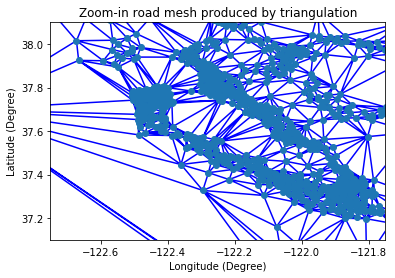

In [761]:
x = tri_prune.points[:,0]
y = tri_prune.points[:,1]
plt.triplot(x, y, tri_prune.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Zoom-in road mesh produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))
plt.show()

### (5) plot zoom-in graph

In [815]:
# convert to dictionary, b/c dictionary dict.get(key) search complexity is O(1)
displayName_to_coordinate = {}
n = len(id_to_coordinate)
for i in range(n):
    displayName_to_coordinate[id_to_coordinate.iloc[i,1]] = ((id_to_coordinate.iloc[i,2]),(id_to_coordinate.iloc[i,3]))
    

In [816]:
displayName_to_coordinate

{'Sargent Creek, San Ardo': (-120.78868462095731, 36.07162944372576),
 '400 Northumberland Avenue, Redwood Oaks, Redwood City': (-122.2194057368421,
  37.469584947368425),
 '18300 Sutter Boulevard, Morgan Hill': (-121.66021547058824,
  37.15047594117647),
 '2700 Stoughton Way, Sheffield, Sacramento': (-121.34284589999997,
  38.57307385),
 '3200 Huntsman Drive, Rosemont Park, Sacramento': (-121.36171355000002,
  38.554434699999995),
 '100 Carlsbad Circle, Vacaville': (-121.94843240909091, 38.36665327272727),
 'Unnamed Road, Vacaville': (-121.99610391304344, 38.325846847826085),
 '700 Carlsbad Court, Petaluma': (-122.64497177272729, 38.26187654545455),
 '500 Hyde Street, Tenderloin, San Francisco': (-122.416533, 37.785702625),
 '3200 Nightingale Drive, Modesto': (-121.06001984615384, 37.69417707692308),
 '0 Mesa Vista Court, San Ramon': (-121.97494123076923, 37.76418646153845),
 'Gate 1 Entrance Road, Calistoga': (-122.57882833333332, 38.58127611111111),
 '1400 Eureka Road, Lead Hill, Ro

In [817]:
displayName_to_coordinate.get("100 Campus Drive, Stanford")

(-122.1759822222222, 37.42968588888888)

In [818]:
displayName_to_coordinate.get("700 Meder Street, Santa Cruz")

(-122.06456181081083, 36.97416881081081)

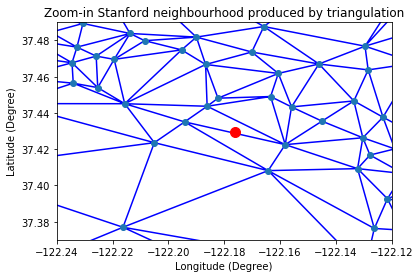

In [824]:
# (-122.1759822222222, 37.42968588888888)
x = tri_prune.points[:,0]
y = tri_prune.points[:,1]
plt.triplot(x, y, tri_prune.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Zoom-in Stanford neighbourhood produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((37.43-0.06,37.43+0.06))
plt.xlim((-122.18-0.06,-122.18+0.06))

plt.plot(-122.1759822222222, 37.42968588888888, 'r.', ms = 20)
plt.show()

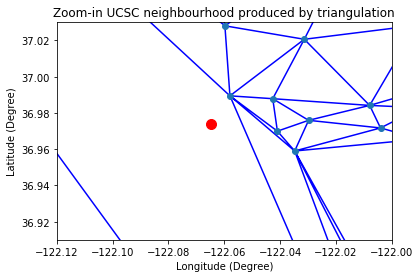

In [823]:
# (-122.06456181081083, 36.97416881081081)
x = tri_prune.points[:,0]
y = tri_prune.points[:,1]
plt.triplot(x, y, tri_prune.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Zoom-in UCSC neighbourhood produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((36.97-0.06,36.97+0.06))
plt.xlim((-122.06-0.06,-122.06+0.06))

plt.plot(-122.06456181081083, 36.97416881081081, 'r.', ms = 20)
plt.show()

### (6) plot pruned graph

In [650]:
# from Q11 
# coordinates extracted from the Geo json file
# dataframe of coordinates of different vertex indices
coordinates_df.head()

Latitude Logitude
0 -120.789  36.0716
1 -122.219  37.4696
2  -121.66  37.1505
3 -121.343  38.5731
4 -121.362  38.5544

In [651]:
coordinates_df.iloc[0,1]

36.07162944372576

In [652]:
threshold_triEdge_to_time

{(978, 1649): 328.1,
 (808, 994): 419.55,
 (137, 458): 342.59,
 (522, 1630): 321.09,
 (394, 507): 166.48,
 (375, 590): 189.13,
 (514, 1087): 361.5,
 (462, 1120): 226.71,
 (1248, 1283): 196.35,
 (239, 1312): 291.92,
 (834, 1075): 410.19,
 (74, 449): 50.22,
 (9, 345): 251.29,
 (1506, 1626): 266.85,
 (842, 1247): 209.34,
 (1706, 1764): 388.57,
 (777, 1696): 339.66,
 (408, 1085): 173.6,
 (1657, 1674): 314.39,
 (1093, 1130): 211.66,
 (1187, 1517): 231.84,
 (1225, 1611): 501.95,
 (198, 478): 160.85,
 (58, 496): 282.9,
 (522, 1396): 183.48,
 (1394, 1490): 96.21,
 (61, 974): 161.04,
 (63, 297): 104.24,
 (1647, 1812): 99.8,
 (848, 1292): 84.62,
 (511, 1712): 161.75,
 (1310, 1396): 420.66,
 (509, 1402): 147.49,
 (204, 1627): 228.7,
 (378, 933): 224.77,
 (1286, 1293): 121.29,
 (1055, 1467): 186.21,
 (275, 1289): 231.22,
 (145, 611): 72.68,
 (1152, 1249): 269.9,
 (1325, 1330): 222.5,
 (738, 1620): 150.64,
 (890, 1267): 308.76,
 (174, 992): 364.57,
 (115, 624): 330.44,
 (1145, 1769): 290.53,
 (148,

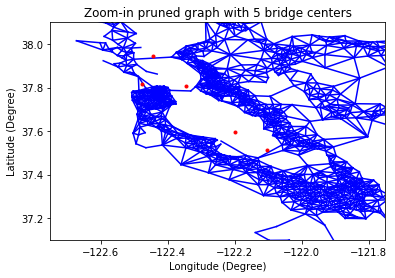

In [764]:
plt.figure()
gVertexSeq = g_giant.vs()
for edge_key in threshold_triEdge_to_time:
    point1_idx = edge_key[0]
    point1_idx_original = int(gVertexSeq[point1_idx]["name"])-1
    point1_coordinate = [coordinates_df.iloc[point1_idx_original,0], coordinates_df.iloc[point1_idx_original,1]]
    point2_idx = edge_key[1]
    point2_idx_original = int(gVertexSeq[point2_idx]["name"])-1
    point2_coordinate = [coordinates_df.iloc[point2_idx_original,0], coordinates_df.iloc[point2_idx_original,1]]
    
    points = np.array([point1_coordinate, point2_coordinate])
    plt.plot(points[:,0], points[:,1], color = "b")

plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))


# add centers of the bridges
center_1 = [(-122.475+-122.479)/2, (37.806+37.83)/2]
center_2 = [(-122.501+-122.387)/2, (37.956+37.93)/2]
center_3 = [(-122.273+-122.122)/2, (37.563+37.627)/2]
center_4 = [(-122.142+-122.067)/2, (37.486+37.54)/2]
center_5 = [(-122.388+-122.302)/2, (37.788+37.825)/2]

centers = np.array([center_1, center_2, center_3, center_4, center_5])
plt.plot(centers[:,0], centers[:,1], 'r.')
plt.title("Zoom-in pruned graph with 5 bridge centers")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.show()


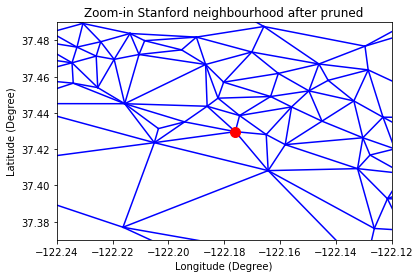

In [830]:
# (-122.1759822222222, 37.42968588888888)
# zoom in Stanford
gVertexSeq = g_giant.vs()
for edge_key in threshold_triEdge_to_time:
    point1_idx = edge_key[0]
    point1_idx_original = int(gVertexSeq[point1_idx]["name"])-1
    point1_coordinate = [coordinates_df.iloc[point1_idx_original,0], coordinates_df.iloc[point1_idx_original,1]]
    point2_idx = edge_key[1]
    point2_idx_original = int(gVertexSeq[point2_idx]["name"])-1
    point2_coordinate = [coordinates_df.iloc[point2_idx_original,0], coordinates_df.iloc[point2_idx_original,1]]
    
    points = np.array([point1_coordinate, point2_coordinate])
    plt.plot(points[:,0], points[:,1], color = "b")
    

plt.title("Zoom-in Stanford neighbourhood after pruned")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((37.43-0.06,37.43+0.06))
plt.xlim((-122.18-0.06,-122.18+0.06))

plt.plot(-122.1759822222222, 37.42968588888888, 'r.', ms = 20)
plt.show()

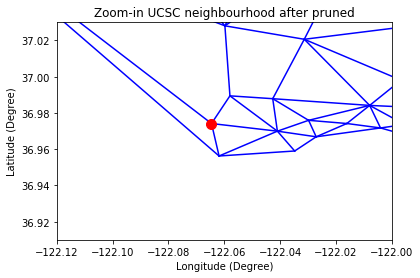

In [831]:
# (-122.06456181081083, 36.97416881081081)
# zoom in UCSC
gVertexSeq = g_giant.vs()
for edge_key in threshold_triEdge_to_time:
    point1_idx = edge_key[0]
    point1_idx_original = int(gVertexSeq[point1_idx]["name"])-1
    point1_coordinate = [coordinates_df.iloc[point1_idx_original,0], coordinates_df.iloc[point1_idx_original,1]]
    point2_idx = edge_key[1]
    point2_idx_original = int(gVertexSeq[point2_idx]["name"])-1
    point2_coordinate = [coordinates_df.iloc[point2_idx_original,0], coordinates_df.iloc[point2_idx_original,1]]
    
    points = np.array([point1_coordinate, point2_coordinate])
    plt.plot(points[:,0], points[:,1], color = "b")
    

plt.title("Zoom-in UCSC neighbourhood after pruned")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((36.97-0.06,36.97+0.06))
plt.xlim((-122.06-0.06,-122.06+0.06))

plt.plot(-122.06456181081083, 36.97416881081081, 'r.', ms = 20)
plt.show()

In [602]:
coordinates_df.iloc[74,0]

-122.46411223076923

In [564]:
EdgeSeq_prune = igraph.EdgeSeq(g_giant_prune)
EdgeSeq_prune[0].tuple

(0, 1)

(-122.75, -121.75)

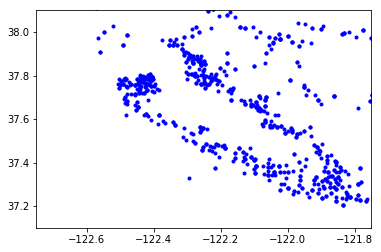

In [596]:
plt.figure()
EdgeSeq_prune = igraph.EdgeSeq(g_giant_prune)
VetexSeq_prune = g_giant_prune.vs()
for es in EdgeSeq_prune:
    v1_idx = es.tuple[0]
    v2_idx = es.tuple[1]
    v1_coordinate = VetexSeq_prune[v1_idx]["Coordinate"]
    v2_coordinate = VetexSeq_prune[v2_idx]["Coordinate"]
    points = np.array([v1_coordinate, v2_coordinate])
    plt.plot(points[:,0], points[:,1], "b.")

plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))

In [563]:
for edge_key in threshold_triEdge_to_time:
    x_idx = edge_key[0]
    x = [coordinates_df.iloc[x_idx,0], coordinates_df.iloc[x_idx,1]]
    y_idx = edge_key[1]
    y = [coordinates_df.iloc[y_idx,0], coordinates_df.iloc[y_idx,1]]
    print(x,y)

[-121.29664763636364, 37.99817263636363] [-122.47017734999997, 37.752123600000004]
[-122.24890423076924, 37.817374] [-120.47588020618562, 36.87490118556702]
[-122.61891066666665, 38.25354376666666] [-122.24104264285712, 37.79130535714285]
[-121.29196078571428, 37.96394500000001] [-121.92815610909089, 37.76575067272727]
[-122.22529319230767, 37.45399473076923] [-121.45146594117648, 38.530277647058824]
[-121.02396189999999, 37.675258450000015] [-122.23789377777777, 37.80058011111112]
[-121.30063553333333, 38.657123999999996] [-122.1568991875, 37.732926437500005]
[-122.26893463636365, 37.86807690909091] [-122.5482637631579, 37.89476132894737]
[-121.78720288000001, 37.3065382] [-121.87793664285714, 37.383797785714286]
[-121.78432372222223, 36.95744969444446] [-123.09819497235014, 38.76923599539172]
[-121.7694892, 38.67038599999999] [-121.00719763709675, 38.7360674919355]
[-122.46411223076923, 38.280859807692316] [-121.10623145454547, 38.6722194090909]
[-121.06001984615384, 37.6941770769230

[-121.85239360000001, 37.26174533333333] [-121.66435007142856, 36.670510285714286]
[-121.35901868965517, 38.64735686206897] [-122.45677954545454, 37.743491818181816]
[-122.1568991875, 37.732926437500005] [-122.46241076923077, 37.70482249999999]
[-122.00237054545455, 37.299402727272714] [-122.41967828205128, 37.669137871794874]
[-122.1081821632653, 37.70568771428571] [-121.29664763636364, 37.99817263636363]
[-121.6908687159091, 38.0991085625] [-120.62241370370367, 37.360447666666666]
[-122.74810288888891, 38.47985407407408] [-121.4448035714286, 37.74407257142857]
[-122.28107779999998, 38.31704404999999] [-121.6734414, 37.118643171428566]
[-121.29757514285714, 38.13972285714285] [-122.18432277272723, 37.804283409090914]
[-122.34669984999998, 37.97505545] [-121.03815246268658, 39.06829923134326]
[-122.43822723076923, 37.781426846153856] [-121.40267655555554, 38.489944666666666]
[-122.12388003636364, 37.72117892727272] [-122.40702833333336, 37.66195233333334]
[-121.29664763636364, 37.99817

[-121.83531116666667, 37.368067583333335] [-121.49823641666666, 38.48870916666667]
[-122.43979, 37.80245875] [-121.89918044999997, 37.66929085000001]
[-122.68599361403511, 38.406502350877204] [-121.25448665909094, 37.91756706818183]
[-121.35632691666666, 38.03993066666666] [-121.52607490804596, 39.43689355172413]
[-122.12627299999998, 37.671056470588226] [-121.47067342857143, 38.51967700000001]
[-121.8164064761905, 37.29342476190476] [-122.55000263013697, 37.947868821917815]
[-122.05975639361704, 37.02809177659573] [-120.65326649166668, 38.393329683333334]
[-122.07389638888887, 37.57010038888889] [-122.1834913125, 37.751060875]
[-121.43293494444447, 38.42966577777778] [-121.50265611111111, 38.620147333333335]
[-122.41599861538461, 37.802103076923075] [-121.91005004761902, 37.689188]
[-121.83411196296294, 37.2050757037037] [-121.81302636363638, 37.24033218181819]
[-122.17808107142858, 37.72840157142857] [-121.44109064285713, 38.469112571428575]
[-121.12486442105264, 36.21285226315789] [

[-122.10699568421055, 37.68244226315789] [-121.8952391764706, 38.02699782352941]
[-122.48681712698414, 37.58269379365079] [-121.29878791666668, 38.10727283333333]
[-120.61870555555555, 37.39467238888889] [-122.10920729411767, 37.42621323529413]
[-121.61218945, 39.786375487499996] [-122.20354979411768, 38.074474705882345]
[-121.7055615, 38.54004867857143] [-122.068416, 37.585316999999996]
[-120.94396612820513, 39.30366566666663] [-121.85239360000001, 37.26174533333333]
[-121.90988181818184, 37.26031981818182] [-121.49271100000001, 38.6318307]
[-122.4678544, 37.763049699999996] [-122.2831828615384, 37.497464984615384]
[-122.41280455555554, 37.7886901111111] [-121.16499957142857, 38.66694328571428]
[-122.420209, 37.73419255] [-121.31732710000001, 38.0239143]
[-120.97058644736842, 38.58225353289471] [-122.48878553846151, 37.782561923076926]
[-122.34669984999998, 37.97505545] [-122.67223882733816, 38.01553251798562]
[-121.2415853, 38.75506963333332] [-121.89918044999997, 37.66929085000001]


[-122.2812146842105, 37.83279057894737] [-122.21905294117647, 37.77855529411765]
[-121.78954715384617, 37.25094653846154] [-122.44994391666665, 37.67626838888889]
[-121.00314607142856, 37.59787642857143] [-122.30237833333332, 37.90972958333334]
[-122.34157718181818, 37.939333636363635] [-122.31653948148147, 37.92312355555556]
[-122.18218993333332, 37.44815759999999] [-121.79928446153848, 39.75026087179486]
[-121.61218945, 39.786375487499996] [-121.97522753299494, 37.644558116751284]
[-122.73750430434782, 38.46703491304348] [-121.544128, 38.490712058823526]
[-122.48589955555556, 37.7035453888889] [-121.94079772499997, 38.32153377499999]
[-122.08989175000004, 37.93430569444444] [-120.26523482352944, 37.11257114705882]
[-122.4050811, 37.795679099999994] [-121.74776037142856, 37.709608628571424]
[-122.36461977777779, 37.58138705555555] [-121.33080918181817, 38.696205954545455]
[-120.36609600000001, 36.15253460869565] [-121.92815610909089, 37.76575067272727]
[-122.30337707692307, 37.5658524

[-121.94183662162165, 37.257928864864866] [-121.6644701818182, 37.124840363636366]
[-121.30757129411762, 38.68292476470588] [-122.04818117647058, 37.59178282352941]
[-121.40362311111113, 36.848219] [-122.32055918181817, 38.322844545454544]
[-122.16620275, 37.73216555] [-122.28966384615386, 37.88129]
[-122.28154418181816, 37.81648881818182] [-122.31701962499999, 37.99438356249998]
[-121.28197709999999, 38.6123833] [-122.14632414285714, 37.7154875]
[-122.4207440909091, 37.79836090909091] [-121.48289069230769, 38.55359430769231]
[-122.1020932857143, 37.62953957142857] [-122.08599096153847, 37.580005115384616]
[-121.37540918181817, 38.624742272727275] [-121.31596506000001, 38.16838299999999]
[-121.88055433333334, 37.354670733333336] [-121.82063914285716, 39.7041901142857]
[-121.82524062499998, 37.264038875] [-121.90486258823528, 37.80530823529412]
[-122.418912, 37.787914375] [-121.46034018181817, 38.478320272727274]
[-121.74542264705882, 38.54954835294118] [-122.63894991666666, 38.95734263

## Q15

In [683]:
# repeat Q12 to add flow attribute to the pruned graph g_giant_prune
gcc_EdgeSeq = igraph.EdgeSeq(g_giant_prune)
i = 0
for es in gcc_EdgeSeq:
    vertex_id_1 = es.tuple[0]
    vertex_id_2 = es.tuple[1]
    coordinate_1 = g_giant_prune.vs[vertex_id_1]["Coordinate"]
    coordinate_2 = g_giant_prune.vs[vertex_id_2]["Coordinate"]
    dist = 69*distance.euclidean(coordinate_1, coordinate_2)# each degree of latitude and longitude is about 69 miles
    time = es["mean_travel_time"]/3600 # convert second to hour
    if dist == 0:
        continue
    flow = calculate_flow(dist, time)
    es["Flow"] = flow
    i = i+1
    
g_giant_prune.summary()

'IGRAPH UN-- 1887 4962 -- \n+ attr: Coordinate (v), Display_Name (v), name (v), Flow (e), mean_travel_time (e)'

In [684]:
# repeat Q13 with the pruned graph g_giant_prune
ggcVertexSeq = g_giant_prune.vs()
for i in range(len(g_giant_prune.vs())):
    if g_giant_prune.vs[i]["Display_Name"] == "100 Campus Drive, Stanford":
        source_vertex_id = i
    elif g_giant_prune.vs[i]["Display_Name"] == "700 Meder Street, Santa Cruz":
        destination_vertex_id = i

In [660]:
g_giant_prune.maxflow(source_vertex_id, destination_vertex_id, capacity = "Flow")

Flow(<igraph.Graph object at 0x66bda1d68>, 21362.96090873116, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.60380309034872, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3461.4165401917835, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3177.2323875438465, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -33.756394990141416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.53804398344937, 0.0, 0.0, 3550.6445468152597, 0.0, 0.0, 3444.8441273866747, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3595.85305650356, -260.3867715961087, 0.0, 3537.6676244617474, 0.0, 0.0, 0.0, 0.0, 0.0, 3587.6470447655224, 18.00250102849077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.31901739962677, -178.69153183405388, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3029.2264559484197, 0.0, 0.0, 0.0, 0.0, -3451.5948426398104, 0.0, 0.0, 0.0, 3564.9354353663443, 301.23095749648655, 0.0, 0.0, 0.0, -70.08315169382013, 0.0, 0.0, 0.0, -3444.728539621603, 0.0, 0.0, 0.0, -114.24430310947992, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3383.73659202962

In [685]:
ggc_maxflow_value = g_giant_prune.maxflow_value(source_vertex_id, destination_vertex_id, capacity = "Flow")
print("The maxflow value is {}".format(ggc_maxflow_value))

The maxflow value is 21362.96090873116


In [686]:
gcc_edge_disjoint_paths = g_giant_prune.edge_disjoint_paths(source_vertex_id, destination_vertex_id)
print("The number of edge-disjoint paths is {}".format(gcc_edge_disjoint_paths))

The number of edge-disjoint paths is 6


## Q10

### (1) trajectory by 1-approximate algorithm

In [699]:
tour_data = pd.read_csv("tour_path_coordinates.csv", sep = ",", header = None)

In [700]:
tour_data.head()

0          1
0 -122.219406  37.469585
1 -122.210497  37.472262
2 -122.195237  37.474809
3 -122.186631  37.466754
4 -122.180167  37.456985

In [701]:
tour_data.values

array([[-122.21940574,   37.46958495],
       [-122.21049658,   37.47226242],
       [-122.1952371 ,   37.474809  ],
       ...,
       [-122.28962578,   37.5361905 ],
       [-122.25615403,   37.52804726],
       [-122.24142413,   37.53984703]])

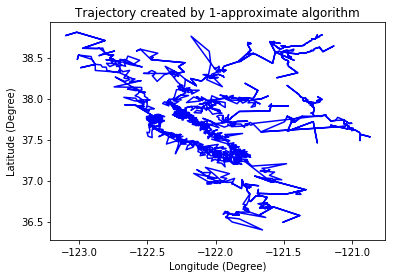

In [758]:
plt.figure()
plt.plot(tour_data.values[:,0], tour_data.values[:,1], color = "b")
plt.title("Trajectory created by 1-approximate algorithm")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.show()

In [726]:
g_giant_mst = g_giant.spanning_tree(weights = g_giant.es["mean_travel_time"])

In [727]:
g_giant_mst.vs[0]

igraph.Vertex(<igraph.Graph object at 0x66c7eb7c8>, 0, {'name': '1982', 'Display_Name': '100 Monte Verde Drive, Vacaville', 'Coordinate': (-122.00124636111111, 38.352439888888895)})

In [729]:
id_to_coordinate.loc[1981]

ID                                          1982
Display_Name    100 Monte Verde Drive, Vacaville
Logitude                                -122.001
Latitude                                 38.3524
Name: 1981, dtype: object

In [765]:
id_to_coordinate.head()

ID                                       Display_Name Logitude Latitude
0  1                            Sargent Creek, San Ardo -120.789  36.0716
1  2  400 Northumberland Avenue, Redwood Oaks, Redwo... -122.219  37.4696
2  3                18300 Sutter Boulevard, Morgan Hill  -121.66  37.1505
3  4          2700 Stoughton Way, Sheffield, Sacramento -121.343  38.5731
4  5     3200 Huntsman Drive, Rosemont Park, Sacramento -121.362  38.5544

In [770]:
# convert to dictionary, b/c dictionary dict.get(key) search complexity is O(1)
coordinate_to_displayName = {}
n = len(id_to_coordinate)
for i in range(n):
    coordinate_to_displayName[(round(id_to_coordinate.iloc[i,2],2),round(id_to_coordinate.iloc[i,3],2))] = id_to_coordinate.iloc[i,1]

In [771]:
coordinate_to_displayName

{(-120.79, 36.07): 'Sargent Creek, San Ardo',
 (-122.22, 37.47): '400 Northumberland Avenue, Redwood Oaks, Redwood City',
 (-121.66, 37.15): '18300 Sutter Boulevard, Morgan Hill',
 (-121.34, 38.57): '2700 Stoughton Way, Sheffield, Sacramento',
 (-121.36, 38.55): '3500 Mignon Street, Sacramento',
 (-121.95, 38.37): '100 Carlsbad Circle, Vacaville',
 (-122.0, 38.33): 'Unnamed Road, Vacaville',
 (-122.64, 38.26): '700 Carlsbad Court, Petaluma',
 (-122.42, 37.79): '200 Myrtle Street, Tenderloin, San Francisco',
 (-121.06, 37.69): '3200 Nightingale Drive, Modesto',
 (-121.97, 37.76): '0 Mesa Vista Court, San Ramon',
 (-122.58, 38.58): 'Gate 1 Entrance Road, Calistoga',
 (-121.24, 38.76): '1400 Rose Glen Drive, East Roseville Parkway, Roseville',
 (-121.61, 36.71): '900 Crestview Street, Salinas',
 (-121.38, 36.47): 'Unnamed Road, Soledad',
 (-121.92, 36.62): '600 9th Street, Pacific Grove',
 (-121.91, 36.59): '200 Vía Gayuba, Monterey',
 (-121.26, 38.79): '3800 Diamond Court, Rocklin',
 (-1

In [793]:
# print the first 10 nodes of the trajectory sequence
# need to round to 2 decimal places or the get key function is hard to match the exact value

# create an empty dataframe
col_names = ["Step", "Trajectory node address"]
tour_nodes_df = pd.DataFrame(columns = col_names)

# put the trajectory nodes into the dataframe
for i in range(60):
    tour_node = coordinate_to_displayName.get((round(tour_data.values[i][0],2), round(tour_data.values[i][1],2)))
    tour_nodes_df.loc[i,"Step"] = int(i+1)
    tour_nodes_df.loc[i,"Trajectory node address"] = tour_node

tour_nodes_df

Step                            Trajectory node address
0     1  400 Northumberland Avenue, Redwood Oaks, Redwo...
1     2    100 Fifth Avenue, South Fair Oaks, Redwood City
2     3          400 Seventh Avenue, Fair Oaks, Menlo Park
3     4               0 Flood Circle, Lindenwood, Atherton
4     5        300 Sherwood Way, Linfield Oaks, Menlo Park
5     6  800 Live Oak Avenue, Downtown Menlo Park, Menl...
6     7                     1700 Oakdell Drive, Menlo Park
7     8                     1700 Oakdell Drive, Menlo Park
8     9  2100 Camino De Los Robles, University Heights,...
9    10    2500 Sand Hill Road, Sharon Heights, Menlo Park
10   11  700 Westridge Drive, Central Portola Valley, P...
11   12                           Reservoir Road, Stanford
12   13                          700 Welch Road, Palo Alto
13   14                         100 Campus Drive, Stanford
14   15                         600 Campus Drive, Stanford
15   16                             0 Ryan Court, Stanford
16   17      700 Bay Road, Staumbaugh Heller, Redwood City
17   18     3600 Page Street, Friendly Acres, Redwood City
18   19                    Bayfront Expressway, Menlo Park
19   20                 2200 Euclid Avenue, East Palo Alto
20   21      300 O' Connor Street, The Willows, Menlo Park
21   22            0 Kirby Place, Crescent Park, Palo Alto
22   23                  1000 Beech Street, East Palo Alto
23   24      3100 North Shoreline Boulevard, Mountain View
24   25             900 Sycamore Drive, Midtown, Palo Alto
25   26           3000 Waverley Street, Midtown, Palo Alto
26   27            3600 South Court, Fairmeadow, Palo Alto
27   28            300 Tioga Court, Greenmeadow, Palo Alto
28   29         300 Ruth Avenue, Monta Loma, Mountain View
29   30                 1900 Hackett Avenue, Mountain View
30   31     1600 San Luis Avenue, Rex Manor, Mountain View
31   32               2200 Wyandotte Street, Mountain View
32   33               800 Aspen Way, Palo Verde, Palo Alto
33   34               400 Moffett Boulevard, Mountain View
34   35                    500 Logue Avenue, Mountain View
35   36           100 Whisman Station Drive, Mountain View
36   37                  500 Sullivan Drive, Mountain View
37   38    500 Chesley Avenue, Waverly Park, Mountain View
38   39        600 Hans Avenue, Cuesta Park, Mountain View
39   40    2400 Hospital Drive, Cuesta Park, Mountain View
40   41  1000 Barbara Avenue, Blossom Valley, Mountain ...
41   42  400 Mariposa Avenue, Shoreline West, Mountain ...
42   43              2000 California Street, Mountain View
43   44              2200 California Street, Mountain View
44   45    200 Alvarado Avenue, North Los Altos, Los Altos
45   46  100 Nancy Court, Old Mountain View, Mountain View
46   47  500 Castro Street, Old Mountain View, Mountain...
47   48    1100 Jamestown Drive, Sunnyvale West, Sunnyvale
48   49                       1300 Holly Avenue, Los Altos
49   50                    1500 Dominion Avenue, Sunnyvale
50   51                  Junipero Serra Freeway, Cupertino
51   52  1900 Scott Lane, Woodland Acres - The Highland...
52   53    1400 Club View Terrace, Country Club, Los Altos
53   54                Monte Bello Road (Trail), Cupertino
54   55                      22600 Alcalde Road, Cupertino
55   56               12900 Tripoli Court, Los Altos Hills
56   57             26200 Catharine Court, Los Altos Hills
57   58        4100 Coulombe Drive, Green Acres, Palo Alto
58   59      4200 Wilkie Way, Charleston Meadow, Palo Alto
59   60               10300 North Stelling Road, Cupertino

### (2) trajectory by mst

In [730]:
mst_array = []
mst_VertexSeq = g_giant_mst.vs()
for v in mst_VertexSeq:
    mst_array.append(list(v["Coordinate"]))

In [751]:
mst_EdgeSeq = igraph.EdgeSeq(g_giant_mst)

In [753]:
mst_EdgeSeq[0].tuple

(453, 961)

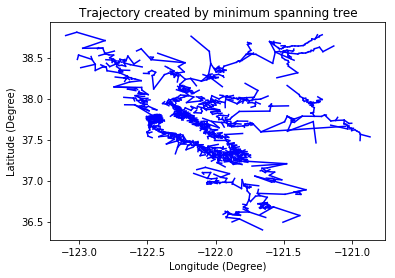

In [757]:
plt.figure()
gVertexSeq = g_giant.vs()
for edge in mst_EdgeSeq:
    point1_idx = edge.tuple[0]
    point1_idx_original = int(gVertexSeq[point1_idx]["name"])-1
    point1_coordinate = [coordinates_df.iloc[point1_idx_original,0], coordinates_df.iloc[point1_idx_original,1]]
    point2_idx = edge.tuple[1]
    point2_idx_original = int(gVertexSeq[point2_idx]["name"])-1
    point2_coordinate = [coordinates_df.iloc[point2_idx_original,0], coordinates_df.iloc[point2_idx_original,1]]
    
    points = np.array([point1_coordinate, point2_coordinate])
    plt.plot(points[:,0], points[:,1], color = "b")
plt.title("Trajectory created by minimum spanning tree")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.show()

In [734]:
print(g_giant_mst)

IGRAPH UN-- 1898 1897 --
+ attr: Coordinate (v), Display_Name (v), name (v), mean_travel_time (e)
+ edges (vertex names):
623--11, 2303--1442, 1274--715, 2082--951, 953--1022, 420--1424, 1929--380,
2425--1230, 347--2155, 865--2204, 43--191, 1999--1843, 1032--385, 695--1920,
75--1223, 1445--2364, 2689--1206, 119--2455, 1440--1441, 486--485, 38--1409,
1774--210, 557--1937, 1536--287, 2593--328, 1443--1740, 2271--2113, 748--420,
1041--1039, 2244--2339, 603--169, 2247--1463, 2106--1153, 596--2401,
1472--530, 2676--2402, 1458--1744, 2639--1463, 328--980, 2329--231,
1719--1717, 1470--2352, 2245--1749, 76--834, 2349--464, 198--1558, 467--814,
549--1940, 868--1699, 1712--2501, 1291--860, 2114--1113, 567--1396,
2458--1955, 1835--1150, 858--1773, 1519--2530, 2349--1516, 1718--1297,
2709--164, 420--268, 743--1360, 272--821, 1745--1459, 1213--23, 1937--1947,
2367--1048, 870--1111, 594--1541, 1743--234, 1698--208, 762--296, 57--102,
813--843, 593--460, 1999--1845, 1495--1425, 2686--1107, 1729--528,

In [735]:
g_giant_mst.vs[0]

igraph.Vertex(<igraph.Graph object at 0x66c7eb7c8>, 0, {'name': '1982', 'Display_Name': '100 Monte Verde Drive, Vacaville', 'Coordinate': (-122.00124636111111, 38.352439888888895)})

In [736]:
g_giant_mst.vs[1]

igraph.Vertex(<igraph.Graph object at 0x66c7eb7c8>, 1, {'name': '73', 'Display_Name': '2100 Fieldcrest Avenue, Fairfield', 'Coordinate': (-122.05216156249999, 38.292827187500016)})

In [737]:
g_giant_mst.vs[2]

igraph.Vertex(<igraph.Graph object at 0x66c7eb7c8>, 2, {'name': '2213', 'Display_Name': '800 40th Street, Longfellow, Oakland', 'Coordinate': (-122.27357263157893, 37.83122173684211)})

In [738]:
g_giant_mst.vs[3]

igraph.Vertex(<igraph.Graph object at 0x66c7eb7c8>, 3, {'name': '1523', 'Display_Name': '1000 Neilson Street, Albany', 'Coordinate': (-122.28737978260868, 37.88701856521739)})

In [739]:
g_giant_mst.vs[4]

igraph.Vertex(<igraph.Graph object at 0x66c7eb7c8>, 4, {'name': '438', 'Display_Name': '1000 Manet Drive, Sunnyvale', 'Coordinate': (-122.02299647826086, 37.35561813043478)})

In [740]:
g_giant_mst.vs[5]

igraph.Vertex(<igraph.Graph object at 0x66c7eb7c8>, 5, {'name': '433', 'Display_Name': '600 Vanessa Drive, Central San Mateo, San Mateo', 'Coordinate': (-122.30933843749997, 37.5582413125)})

In [731]:
mst_array = np.array(mst_array)
mst_array

array([[-122.00124636,   38.35243989],
       [-122.05216156,   38.29282719],
       [-122.27357263,   37.83122174],
       ...,
       [-121.93967141,   38.26010534],
       [-121.00364438,   37.69934731],
       [-122.66583117,   37.92502969]])

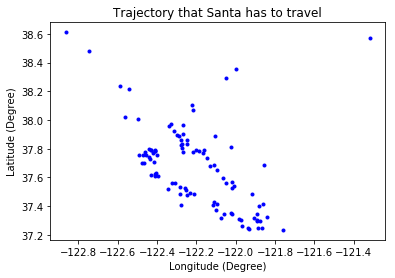

In [746]:
plt.figure()
plt.plot(mst_array[0:100,0], mst_array[0:100,1], "b.")
plt.title("Trajectory that Santa has to travel")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.show()